#Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os,sys
import numpy as np
import random
from copy import deepcopy
import math
import torch
import torch.nn as nn
from torch.optim import Optimizer
from tqdm import tqdm
from torch._six import inf
import pandas as pd
from PIL import Image
from sklearn.feature_extraction import image
import torchvision.transforms.functional as tvF
import torchvision.transforms as transforms
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
device

'cuda'

#Data

In [7]:
def get(seed=0, fixed_order=False, pc_valid=0, tasknum = 5):
    if tasknum>5:
        tasknum = 5
    data = {}
    taskcla = []
    size = [1, 28, 28]
    path = "/content/drive/MyDrive/Code/Project_1/data_mnist"
    
    # Pre-load
    # MNIST
    mean = (0.1307,)
    std = (0.3081,)
    if not os.path.isdir(path):
        print("1")
        os.makedirs(path)
        dat = {}
        dat['train'] = datasets.MNIST(path, train=True, download=True, transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean, std)]))
        dat['test'] = datasets.MNIST(path, train=False, download=True, transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean, std)]))
        for i in range(5):
            data[i] = {}
            data[i]['name'] = 'split_mnist-{:d}'.format(i)
            data[i]['ncla'] = 2
            data[i]['train'] = {'x': [], 'y': []}
            data[i]['test'] = {'x': [], 'y': []}
        for s in ['train', 'test']:
            loader = torch.utils.data.DataLoader(dat[s], batch_size=1, shuffle=False)
            for image, target in loader:
                task_idx = target.numpy()[0] // 2
                data[task_idx][s]['x'].append(image)
                data[task_idx][s]['y'].append(target.numpy()[0]%2)

        for i in range(5):
            for s in ['train', 'test']:
                data[i][s]['x'] = torch.stack(data[i][s]['x'])
                data[i][s]['y'] = torch.LongTensor(np.array(data[i][s]['y'], dtype=int)).view(-1)
                torch.save(data[i][s]['x'],os.path.join(os.path.expanduser(path), 'data'+ str(i) + s + 'x.bin'))
                torch.save(data[i][s]['y'],os.path.join(os.path.expanduser(path), 'data'+ str(i) + s + 'y.bin'))
    else:
        print("2")
        # Load binary files
        for i in range(5):
            data[i] = dict.fromkeys(['name', 'ncla', 'train', 'test'])
            data[i]['ncla'] = 2
            data[i]['name'] = 'split_mnist-{:d}'.format(i)

            # Load
            for s in ['train', 'test']:
                data[i][s] = {'x': [], 'y': []}
                data[i][s]['x'] = torch.load(os.path.join(os.path.expanduser(path), 'data'+ str(i) + s + 'x.bin'))
                data[i][s]['y'] = torch.load(os.path.join(os.path.expanduser(path), 'data'+ str(i) + s + 'y.bin'))
        
    for t in range(tasknum):
        data[t]['valid'] = {}
        data[t]['valid']['x'] = data[t]['train']['x'].clone()
        data[t]['valid']['y'] = data[t]['train']['y'].clone()

    # Others
    n = 0
    for t in range(tasknum):
        taskcla.append((t, data[t]['ncla']))
        n += data[t]['ncla']
    data['ncla'] = n
    
    return data, taskcla, size

In [65]:
def get_cifar100(seed=0,pc_valid=0.10, tasknum = 20):
    data={}
    taskcla=[]
    size=[3,32,32]
    path = "/content/drive/MyDrive/Code/Project_1/data_cifar100"

    if not os.path.isdir(path):
        os.makedirs(path)

        mean=[x/255 for x in [125.3,123.0,113.9]]
        std=[x/255 for x in [63.0,62.1,66.7]]
        
        # CIFAR100
        dat={}
        
        dat['train']=datasets.CIFAR100('/content/drive/MyDrive/Code/Project_1/',train=True,download=True,
                                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))
        dat['test']=datasets.CIFAR100('/content/drive/MyDrive/Code/Project_1/',train=False,download=True,
                                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))
        for n in range(10):
            data[n]={}
            data[n]['name']='cifar100'
            data[n]['ncla']=10
            data[n]['train']={'x': [],'y': []}
            data[n]['test']={'x': [],'y': []}
        for s in ['train','test']:
            loader=torch.utils.data.DataLoader(dat[s],batch_size=1,shuffle=False)
            for image,target in loader:
                task_idx = target.cpu().numpy()[0] // 10
                data[task_idx][s]['x'].append(image)
                data[task_idx][s]['y'].append(target.cpu().numpy()[0]%10)

        # "Unify" and save
        for t in range(10):
            for s in ['train','test']:
                data[t][s]['x']=torch.stack(data[t][s]['x']).view(-1,size[0],size[1],size[2])
                data[t][s]['y']=torch.LongTensor(np.array(data[t][s]['y'],dtype=int)).view(-1)
                torch.save(data[t][s]['x'], os.path.join(os.path.expanduser(path),
                                                         'data'+str(t+1)+s+'x.bin'))
                torch.save(data[t][s]['y'], os.path.join(os.path.expanduser(path),
                                                         'data'+str(t+1)+s+'y.bin'))
    
    # Load binary files
    data={}
    data[0] = dict.fromkeys(['name','ncla','train','test'])
    ids=list(shuffle(np.arange(10),random_state=seed)+1)
    print('Task order =',ids)
    for i in range(10):
        data[i] = dict.fromkeys(['name','ncla','train','test'])
        for s in ['train','test']:
            data[i][s]={'x':[],'y':[]}
            data[i][s]['x']=torch.load(os.path.join(os.path.expanduser(path),
                                                    'data'+str(ids[i])+s+'x.bin'))
            data[i][s]['y']=torch.load(os.path.join(os.path.expanduser(path),
                                                    'data'+str(ids[i])+s+'y.bin'))
        data[i]['ncla']=len(np.unique(data[i]['train']['y'].numpy()))
        data[i]['name']='cifar100-'+str(ids[i-1])
            
    # Validation
    for t in range(10):
        r=np.arange(data[t]['train']['x'].size(0))
        r=np.array(shuffle(r,random_state=seed),dtype=int)
        nvalid=int(pc_valid * len(r))
        ivalid=torch.LongTensor(r[:nvalid])
        itrain=torch.LongTensor(r[nvalid:])
        data[t]['valid']={}
        data[t]['valid']['x']=data[t]['train']['x'][ivalid].clone()
        data[t]['valid']['y']=data[t]['train']['y'][ivalid].clone()
        data[t]['train']['x']=data[t]['train']['x'][itrain].clone()
        data[t]['train']['y']=data[t]['train']['y'][itrain].clone()

    # Others
    n=0
    for t in range(10):
        taskcla.append((t,data[t]['ncla']))
        n+=data[t]['ncla']
    data['ncla']=n

    return data,taskcla,size

In [ ]:
data, taskcla, size = get()

In [ ]:
size

[1, 28, 28]

In [67]:
data_cf100, task_cla_cf100, input_size_cf100 = get_cifar100()

Files already downloaded and verified
Files already downloaded and verified
Task order = [3, 9, 5, 10, 2, 7, 8, 4, 1, 6]


In [73]:
data_cf100[0]['ncla']

10

# Network

### MLP



In [9]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, task_cla, num_units=400, split=True):
        super(MLP, self).__init__()
        n_channels, size, _ = input_size
        self.task_cla = task_cla
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.3)
        self.layer_1 = Linear(n_channels * size * size, num_units) 
        self.layer_2 = Linear(num_units, num_units)
        self.split = split

        if self.split: 
            self.last = torch.nn.ModuleList()
            for t, n in self.task_cla:
                self.last.append(Linear(num_units, n))
    
    def forward(self, x):
        h = x.view(x.size(0), -1)
        h = self.drop(F.relu(self.layer_1(h)))
        h = self.drop(F.relu(self.layer_2(h)))

        if self.split:
            y = []
            for t, i in self.task_cla:
                y.append(self.last[t](h))
        
        return y 
    @property
    def device(self):
        return next(self.parameters()).device
    

In [ ]:
mlp1 = MLP(
    input_size= size,
    task_cla = task_cla
)


## ConvNet

In [75]:
def compute_conv_output_size(Lin,kernel_size,stride=1,padding=0,dilation=1):
    return int(np.floor((Lin+2*padding-dilation*(kernel_size-1)-1)/float(stride)+1))

In [87]:
class ConvNet(nn.Module):
    def __init__(self, inputsize, taskcla):
        super().__init__()
        
        ncha,size,_=inputsize
        self.taskcla = taskcla
        
        self.conv1 = nn.Conv2d(ncha,32,kernel_size=3,padding=1)
        s = compute_conv_output_size(size,3, padding=1) # 32
        self.conv2 = nn.Conv2d(32,32,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 32
        s = s//2 # 16
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 16
        self.conv4 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 16
        s = s//2 # 8
        self.conv5 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 8
        self.conv6 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 8
#         self.conv7 = nn.Conv2d(128,128,kernel_size=3,padding=1)
#         s = compute_conv_output_size(s,3, padding=1) # 8
        s = s//2 # 4
        self.fc1 = nn.Linear(s*s*128,256) # 2048
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        self.MaxPool = torch.nn.MaxPool2d(2)
        
        self.last=torch.nn.ModuleList()
        
        for t,n in self.taskcla:
            self.last.append(torch.nn.Linear(256,n))
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        h=self.relu(self.conv1(x))
        h=self.relu(self.conv2(h))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv3(h))
        h=self.relu(self.conv4(h))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv5(h))
        h=self.relu(self.conv6(h))
#         h=self.relu(self.conv7(h))
        h=self.drop1(self.MaxPool(h))
        h=h.view(x.shape[0],-1)
        h = self.drop2(self.relu(self.fc1(h)))
        y = []
        for t,i in self.taskcla:
            y.append(self.last[t](h))
        
        return y

#Logger

In [23]:
class logger(object):
    def __init__(self, file_name='pmnist2', resume=False, path='/content/drive/MyDrive/Code/Project_1/log/si', data_format='csv'):

        self.data_name = os.path.join(path, file_name)
        self.data_path = '{}.csv'.format(self.data_name)
        self.log = None
        if os.path.isfile(self.data_path):
            if resume:
                self.load(self.data_path)
            else:
                os.remove(self.data_path)
                self.log = pd.DataFrame()
        else:
            self.log = pd.DataFrame()

        self.data_format = data_format


    def add(self, **kwargs):
        """Add a new row to the dataframe
        example:
            resultsLog.add(epoch=epoch_num, train_loss=loss,
                           test_loss=test_loss)
        """
        df = pd.DataFrame([kwargs.values()], columns=kwargs.keys())
        self.log = self.log.append(df, ignore_index=True)


    def save(self):
        return self.log.to_csv(self.data_path, index=False, index_label=False)

    def load(self, path=None):
        path = path or self.data_path
        if os.path.isfile(path):
            self.log.read_csv(path)
        else:
            raise ValueError('{} isn''t a file'.format(path))

#Method

In [108]:
def get_model(model):
    return deepcopy(model.state_dict())

def set_model_(model,state_dict):
    model.load_state_dict(deepcopy(state_dict))
    return

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return


class SI():
    def __init__(
        self,
        model,
        c,
        num_epochs=20,
        batch_size=256,
        lr= 0.001,
        lr_min=1e-6,
        
        lr_factor=3,lr_patience=5,clipgrad=100, log_name='mnist_si', split=False
    ):
        self.model = model
        self.old_model = model
        self.batch_size = batch_size
        self.num_epochs = num_epochs 
        self.lr = lr 
        self.lr_min = lr_min
        self.lr_factor = lr_factor
        self.split = split 
        self.logger = logger(file_name=log_name, resume=False, data_format='csv')
        self.lr_patience = lr_patience
        self.ce = torch.nn.CrossEntropyLoss()
        self.optimizer = self._get_optimizer()
        self.c = c 
        self.eps = 0.01 
        self.omega = {}
        self.W = {}
        self.p_old = {}

        n = 0
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')
                self.model.register_buffer('{}_SI_prev_task'.format(n), p.data.clone())
        return

    def _get_optimizer(self, lr=None):
        if lr is None:
            lr = self.lr
        return torch.optim.Adam(self.model.parameters(), lr=lr)
        
    def train(self, t, x_train, y_train, x_val, y_val, data, input_size, task_cla):
        best_loss = np.inf
        best_model = deepcopy(self.
                              model.state_dict())
        lr = self.lr
        patience = self.lr_patience
        self.optimizer = self._get_optimizer(lr)
        self.omega = {}
        self.W = {}
        self.p_old = {}

        n = 0
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')
                self.W[n] = p.data.clone().zero_()
                self.p_old[n] = p.data.clone()

        
        for ep in tqdm(range(self.num_epochs)):
            num_batch = x_train.size(0)
            self.train_epoch(t, x_train, y_train)

            train_loss, train_acc = self.eval(t, x_train, y_train)
            print('train_loss: {:.4f}, train_acc: {:.4f}'.format(train_loss, train_acc))
            val_loss, val_acc = self.eval(t, x_val, y_val)
            print('val_loss: {:.4f}, val_acc: {:.4f}'.format(val_loss, val_acc))

            for task in range(t):
                x_val_t = data[task]['valid']['x'].cuda()
                y_val_t = data[task]['valid']['y'].cuda()

                val_loss_t, val_acc_t = self.eval(task, x_val_t, y_val_t)
                self.logger.add(
                    epoch= (t * self.num_epochs) + ep,
                    task_num= task + 1,
                    valid_loss= val_loss_t,
                    valid_acc=val_acc_t 
                )

            if val_loss < best_loss:
                best_loss = val_loss
                best_model = get_model(self.model)
                patience = self.lr_patience
                print(' *', end='')
            else:
                patience -= 1
                if patience <= 0:
                    lr /= self.lr_factor
                    # print(' lr={:.1e}'.format(lr), end='')
                    if lr < self.lr_min:
                        lr = self.lr_min
                            
                    patience = self.lr_patience
                    self.optimizer = self._get_optimizer(lr)
            
            set_model_(self.model, best_model)


            self.logger.save()
            self.update_omega(self.W, self.eps)
            self.old_model = deepcopy(self.model)
            freeze_model(self.old_model)





    def train_epoch(self, t, x, y):
        self.model.train()

        r = np.arange(x.size(0))
        np.random.shuffle(r)
        r = torch.LongTensor(r).to(device)

        for i in range(0, len(r), self.batch_size):
            if i + self.batch_size <= len(r):
                b = r[i: i + self.batch_size]
            else:
                b = r[i:]
            
            x_batch = x[b]
            y_batch = y[b]

            if self.split:
                output = self.model.forward(x_batch)[t]
            
            # print(type(output))
            # print(type(y_batch))

            loss = self.criterion(t, output, y_batch)
            n = 0
            #backward
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    n = n.replace('.', '__')
                    if p.grad is not None:
                        self.W[n].add_(-p.grad * (p.detach() - self.p_old[n]))
                    self.p_old[n] = p.detach().clone()
        return
    
    def eval(self, t, x, y):
        total_loss = 0
        total_acc = 0
        total_num = 0
        self.model.eval()

        r = np.arange(x.size(0))
        r = torch.LongTensor(r).cuda()

        # Loop batches
        for i in range(0,len(r),self.batch_size):
            if i + self.batch_size <= len(r): b=r[i : i + self.batch_size]
            else: b=r[i:]
            x_batch = x[b]
            y_batch = y[b]
            
            # Forward
            if self.split:
                output = self.model.forward(x_batch)[t]
            else:
                output = self.model.forward(x_batch)
                
            loss = self.criterion(t,output,y_batch)
            _, pred = output.max(1)
            hits = (pred == y_batch).float()

            total_loss += loss.data.cpu().numpy() * len(b)
            total_acc += hits.sum().data.cpu().numpy()
            total_num += len(b)

        return total_loss/total_num ,total_acc/total_num
    def criterion(self, t, output, targets):
        loss_reg = 0
        if (t > 0):
            loss_reg = self.surrogate_loss()
        
        return self.ce(output, targets) + self.c * loss_reg

    def update_omega(self, W, eps):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')

                p_prev = getattr(self.model, '{}_SI_prev_task'.format(n))
                p_current = p.detach().clone()
                p_change = p_current - p_prev 

                omega_add = W[n] / (p_change ** 2 + eps)

                try:
                    omega = getattr(self.model, '{}_SI_omega'.format(n))
                except AttributeError:
                    omega = p.detach().clone().zero_()
                omega_new = omega + omega_add
                self.model.register_buffer('{}_SI_prev_task'.format(n), p_current)
                self.model.register_buffer('{}_SI_omega'.format(n), omega_new)


    def surrogate_loss(self):
        try:
            losses = []
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    n = n.replace('.', '__')
                    prev_values = getattr(self.model, '{}_SI_prev_task'.format(n))
                    omega = getattr(self.model, '{}_SI_omega'.format(n))
                    losses.append((omega * (p - prev_values) ** 2).sum())
            return sum(losses)
        except AttributeError:
            return 0

In [ ]:
model = MLP()

#Training and experiments

##Training on MLP network and MNIST dataset

In [12]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [13]:
data, task_cla, input_size = get()

2


In [26]:
next(mlp.parameters()).is_cuda

True

In [40]:
def train_mode(c=1):
    mlp = MLP(
    input_size= size,
    task_cla = task_cla
    ).to(device)

    si = SI(mlp, split=True, c= c)

    acc_res = np.zeros((len(task_cla), len(task_cla)), dtype=np)
    loss_res = np.zeros((len(task_cla), len(task_cla)), dtype=np)

    for t, n_class in task_cla:
        print("Task {:d}:, data name: {:s}".format(t, data[t]['name']))
        
        x_train = data[t]['train']['x'].to(device)
        y_train = data[t]['train']['y'].to(device)
        x_val = data[t]['valid']['x'].to(device)
        y_val = data[t]['valid']['y'].to(device)
        # x_train = data[t]['train']['x']
        # y_train = data[t]['train']['y']
        # x_val = data[t]['valid']['x']
        # y_val = data[t]['valid']['y']
        task = t

        #train
        print('TRAINING PHASE...')
        si.train(
            task,
            x_train= x_train, 
            y_train= y_train,
            x_val= x_val,
            y_val= y_val,
            data= data, input_size= size, task_cla= task_cla
        )

        #test
        print('TESTING PHASE...')
        for u in range(t + 1):
            x_test = data[u]['test']['x'].to(device)
            y_test = data[u]['test']['y'].to(device)

            test_loss, test_acc = si.eval(u, x_test, y_test)
            print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                        100 * test_acc))

            acc_res[t, u] = test_acc
            loss_res[t, u] = test_loss
    
    return acc_res, loss_res



In [41]:
acc_res_with_consolidation, loss_res_with_consolidation = train_mode(c=1)


Task 0:, data name: split_mnist-0
TRAINING PHASE...


  5%|▌         | 1/20 [00:00<00:03,  6.29it/s]

train_loss: 0.0063, train_acc: 0.9985
val_loss: 0.0063, val_acc: 0.9985
train_loss: 0.0019, train_acc: 0.9995


 10%|█         | 2/20 [00:00<00:03,  5.91it/s]

val_loss: 0.0019, val_acc: 0.9995
train_loss: 0.0008, train_acc: 0.9997


 15%|█▌        | 3/20 [00:00<00:02,  5.98it/s]

val_loss: 0.0008, val_acc: 0.9997


 20%|██        | 4/20 [00:00<00:02,  6.07it/s]

train_loss: 0.0053, train_acc: 0.9983
val_loss: 0.0053, val_acc: 0.9983


 25%|██▌       | 5/20 [00:00<00:02,  6.11it/s]

train_loss: 0.0008, train_acc: 0.9998
val_loss: 0.0008, val_acc: 0.9998
train_loss: 0.0012, train_acc: 0.9995
val_loss: 0.0012, val_acc: 0.9995


 30%|███       | 6/20 [00:00<00:02,  6.00it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 35%|███▌      | 7/20 [00:01<00:02,  6.00it/s]

train_loss: 0.0006, train_acc: 0.9997


 40%|████      | 8/20 [00:01<00:02,  5.75it/s]

val_loss: 0.0006, val_acc: 0.9997
train_loss: 0.0012, train_acc: 0.9997


 45%|████▌     | 9/20 [00:01<00:01,  5.68it/s]

val_loss: 0.0012, val_acc: 0.9997


 50%|█████     | 10/20 [00:01<00:01,  5.64it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 60%|██████    | 12/20 [00:02<00:01,  5.87it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0009, train_acc: 0.9996
val_loss: 0.0009, val_acc: 0.9996


 65%|██████▌   | 13/20 [00:02<00:01,  5.91it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 70%|███████   | 14/20 [00:02<00:01,  5.90it/s]

train_loss: 0.0000, train_acc: 1.0000


 75%|███████▌  | 15/20 [00:02<00:00,  5.91it/s]

val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 18/20 [00:03<00:00,  6.02it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999
train_loss: 0.0139, train_acc: 0.9964
val_loss: 0.0139, val_acc: 0.9964


 95%|█████████▌| 19/20 [00:03<00:00,  6.05it/s]

train_loss: 0.0011, train_acc: 0.9997
val_loss: 0.0011, val_acc: 0.9997
train_loss: 0.0019, train_acc: 0.9994
val_loss: 0.0019, val_acc: 0.9994


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.003, acc= 99.9% <<<
Task 1:, data name: split_mnist-1
TRAINING PHASE...


  5%|▌         | 1/20 [00:00<00:07,  2.52it/s]

train_loss: -5.1315, train_acc: 0.9751
val_loss: -5.1315, val_acc: 0.9751


 10%|█         | 2/20 [00:00<00:07,  2.48it/s]

train_loss: -0.2263, train_acc: 0.9846
val_loss: -0.2263, val_acc: 0.9846


 15%|█▌        | 3/20 [00:01<00:06,  2.44it/s]

train_loss: -0.0312, train_acc: 0.9911
val_loss: -0.0312, val_acc: 0.9911


 20%|██        | 4/20 [00:01<00:06,  2.43it/s]

train_loss: -0.0397, train_acc: 0.9932
val_loss: -0.0397, val_acc: 0.9932


 25%|██▌       | 5/20 [00:02<00:06,  2.41it/s]

train_loss: -0.1139, train_acc: 0.9916
val_loss: -0.1139, val_acc: 0.9916


 30%|███       | 6/20 [00:02<00:05,  2.41it/s]

train_loss: -0.2318, train_acc: 0.9958
val_loss: -0.2318, val_acc: 0.9958


 35%|███▌      | 7/20 [00:02<00:05,  2.42it/s]

train_loss: -0.3465, train_acc: 0.9940
val_loss: -0.3465, val_acc: 0.9940


 40%|████      | 8/20 [00:03<00:05,  2.40it/s]

train_loss: -0.4256, train_acc: 0.9953
val_loss: -0.4256, val_acc: 0.9953


 45%|████▌     | 9/20 [00:03<00:04,  2.41it/s]

train_loss: -0.6711, train_acc: 0.9961
val_loss: -0.6711, val_acc: 0.9961


 50%|█████     | 10/20 [00:04<00:04,  2.40it/s]

train_loss: -1.0757, train_acc: 0.9968
val_loss: -1.0757, val_acc: 0.9968


 55%|█████▌    | 11/20 [00:04<00:03,  2.41it/s]

train_loss: -0.9958, train_acc: 0.9966
val_loss: -0.9958, val_acc: 0.9966


 60%|██████    | 12/20 [00:04<00:03,  2.43it/s]

train_loss: -1.1969, train_acc: 0.9931
val_loss: -1.1969, val_acc: 0.9931


 65%|██████▌   | 13/20 [00:05<00:02,  2.42it/s]

train_loss: -1.9706, train_acc: 0.9965
val_loss: -1.9706, val_acc: 0.9965


 70%|███████   | 14/20 [00:05<00:02,  2.43it/s]

train_loss: -1.8570, train_acc: 0.9981
val_loss: -1.8570, val_acc: 0.9981


 75%|███████▌  | 15/20 [00:06<00:02,  2.42it/s]

train_loss: -2.3587, train_acc: 0.9973
val_loss: -2.3587, val_acc: 0.9973


 80%|████████  | 16/20 [00:06<00:01,  2.40it/s]

train_loss: -2.4441, train_acc: 0.9985
val_loss: -2.4441, val_acc: 0.9985


 85%|████████▌ | 17/20 [00:07<00:01,  2.39it/s]

train_loss: -3.6520, train_acc: 0.9984
val_loss: -3.6520, val_acc: 0.9984


 90%|█████████ | 18/20 [00:07<00:00,  2.38it/s]

train_loss: -7.1310, train_acc: 0.9985
val_loss: -7.1310, val_acc: 0.9985


 95%|█████████▌| 19/20 [00:07<00:00,  2.40it/s]

train_loss: -4.6584, train_acc: 0.9986
val_loss: -4.6584, val_acc: 0.9986


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


train_loss: -14.3433, train_acc: 0.9988
val_loss: -14.3433, val_acc: 0.9988
TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.005, acc= 99.9% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.015, acc= 99.4% <<<
Task 2:, data name: split_mnist-2
TRAINING PHASE...


  5%|▌         | 1/20 [00:00<00:08,  2.16it/s]

train_loss: -0.5504, train_acc: 0.9879
val_loss: -0.5504, val_acc: 0.9879


 10%|█         | 2/20 [00:00<00:08,  2.15it/s]

train_loss: -0.0404, train_acc: 0.9944
val_loss: -0.0404, val_acc: 0.9944
train_loss: 0.0098, train_acc: 0.9967
val_loss: 0.0098, val_acc: 0.9967


 15%|█▌        | 3/20 [00:01<00:07,  2.13it/s]

train_loss: -0.0052, train_acc: 0.9974
val_loss: -0.0052, val_acc: 0.9974


 25%|██▌       | 5/20 [00:02<00:07,  2.13it/s]

train_loss: -0.0526, train_acc: 0.9983
val_loss: -0.0526, val_acc: 0.9983
train_loss: -0.0591, train_acc: 0.9989
val_loss: -0.0591, val_acc: 0.9989


 35%|███▌      | 7/20 [00:03<00:06,  2.15it/s]

train_loss: -0.0775, train_acc: 0.9990
val_loss: -0.0775, val_acc: 0.9990


 40%|████      | 8/20 [00:03<00:05,  2.15it/s]

train_loss: -0.1623, train_acc: 0.9994
val_loss: -0.1623, val_acc: 0.9994


 45%|████▌     | 9/20 [00:04<00:05,  2.16it/s]

train_loss: -0.1378, train_acc: 0.9993
val_loss: -0.1378, val_acc: 0.9993


 50%|█████     | 10/20 [00:04<00:04,  2.16it/s]

train_loss: -0.2575, train_acc: 0.9996
val_loss: -0.2575, val_acc: 0.9996


 55%|█████▌    | 11/20 [00:05<00:04,  2.16it/s]

train_loss: -0.3998, train_acc: 0.9996
val_loss: -0.3998, val_acc: 0.9996


 60%|██████    | 12/20 [00:05<00:03,  2.15it/s]

train_loss: -0.2624, train_acc: 0.9995
val_loss: -0.2624, val_acc: 0.9995


 65%|██████▌   | 13/20 [00:06<00:03,  2.13it/s]

train_loss: -0.4809, train_acc: 0.9996
val_loss: -0.4809, val_acc: 0.9996


 70%|███████   | 14/20 [00:06<00:02,  2.15it/s]

train_loss: -0.8324, train_acc: 0.9996
val_loss: -0.8324, val_acc: 0.9996
train_loss: -0.5308, train_acc: 0.9999
val_loss: -0.5308, val_acc: 0.9999


 80%|████████  | 16/20 [00:07<00:01,  2.14it/s]

train_loss: -0.4875, train_acc: 1.0000
val_loss: -0.4875, val_acc: 1.0000
train_loss: -0.5548, train_acc: 0.9990
val_loss: -0.5548, val_acc: 0.9990


 90%|█████████ | 18/20 [00:08<00:00,  2.11it/s]

train_loss: -0.6461, train_acc: 1.0000
val_loss: -0.6461, val_acc: 1.0000


 95%|█████████▌| 19/20 [00:08<00:00,  2.12it/s]

train_loss: -0.6956, train_acc: 0.9998
val_loss: -0.6956, val_acc: 0.9998


100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

train_loss: -3.8623, train_acc: 0.9998
val_loss: -3.8623, val_acc: 0.9998


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.009, acc= 99.9% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.098, acc= 96.9% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.003, acc= 99.9% <<<
Task 3:, data name: split_mnist-3
TRAINING PHASE...


  0%|          | 0/20 [00:00<?, ?it/s]

train_loss: -0.2476, train_acc: 0.9968
val_loss: -0.2476, val_acc: 0.9968


  5%|▌         | 1/20 [00:00<00:10,  1.73it/s]

train_loss: -0.0203, train_acc: 0.9985
val_loss: -0.0203, val_acc: 0.9985


 10%|█         | 2/20 [00:01<00:10,  1.75it/s]

train_loss: 0.0058, train_acc: 0.9993
val_loss: 0.0058, val_acc: 0.9993


 15%|█▌        | 3/20 [00:01<00:09,  1.76it/s]

train_loss: 0.0064, train_acc: 0.9992
val_loss: 0.0064, val_acc: 0.9992


 20%|██        | 4/20 [00:02<00:09,  1.75it/s]

train_loss: -0.0041, train_acc: 0.9993
val_loss: -0.0041, val_acc: 0.9993


 25%|██▌       | 5/20 [00:02<00:08,  1.75it/s]

train_loss: -0.0023, train_acc: 0.9996
val_loss: -0.0023, val_acc: 0.9996


 30%|███       | 6/20 [00:03<00:08,  1.75it/s]

train_loss: -0.0106, train_acc: 0.9997
val_loss: -0.0106, val_acc: 0.9997


 35%|███▌      | 7/20 [00:04<00:07,  1.75it/s]

train_loss: -0.0180, train_acc: 0.9998
val_loss: -0.0180, val_acc: 0.9998


 40%|████      | 8/20 [00:04<00:06,  1.75it/s]

train_loss: -0.0358, train_acc: 0.9998
val_loss: -0.0358, val_acc: 0.9998


 45%|████▌     | 9/20 [00:05<00:06,  1.75it/s]

train_loss: -0.0721, train_acc: 0.9998
val_loss: -0.0721, val_acc: 0.9998


 50%|█████     | 10/20 [00:05<00:05,  1.75it/s]

train_loss: -0.0879, train_acc: 0.9998
val_loss: -0.0879, val_acc: 0.9998


 55%|█████▌    | 11/20 [00:06<00:05,  1.76it/s]

train_loss: -0.1387, train_acc: 0.9997
val_loss: -0.1387, val_acc: 0.9997


 60%|██████    | 12/20 [00:06<00:04,  1.75it/s]

train_loss: -0.1215, train_acc: 0.9998
val_loss: -0.1215, val_acc: 0.9998


 65%|██████▌   | 13/20 [00:07<00:04,  1.75it/s]

train_loss: -0.1569, train_acc: 0.9999
val_loss: -0.1569, val_acc: 0.9999


 70%|███████   | 14/20 [00:07<00:03,  1.75it/s]

train_loss: -0.2223, train_acc: 0.9999
val_loss: -0.2223, val_acc: 0.9999


 75%|███████▌  | 15/20 [00:08<00:02,  1.74it/s]

train_loss: -0.2054, train_acc: 0.9998
val_loss: -0.2054, val_acc: 0.9998


 80%|████████  | 16/20 [00:09<00:02,  1.74it/s]

train_loss: -0.2441, train_acc: 0.9998
val_loss: -0.2441, val_acc: 0.9998


 85%|████████▌ | 17/20 [00:09<00:01,  1.74it/s]

train_loss: -0.3932, train_acc: 0.9999
val_loss: -0.3932, val_acc: 0.9999


 90%|█████████ | 18/20 [00:10<00:01,  1.74it/s]

train_loss: -0.3909, train_acc: 0.9999
val_loss: -0.3909, val_acc: 0.9999


 95%|█████████▌| 19/20 [00:10<00:00,  1.75it/s]

train_loss: -0.3991, train_acc: 0.9999
val_loss: -0.3991, val_acc: 0.9999


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.035, acc= 98.8% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.119, acc= 96.7% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.007, acc= 99.8% <<<
>>> Test on task  3 - split_mnist-3  : loss=0.004, acc= 99.8% <<<
Task 4:, data name: split_mnist-4
TRAINING PHASE...


  0%|          | 0/20 [00:00<?, ?it/s]

train_loss: 0.0143, train_acc: 0.9781
val_loss: 0.0143, val_acc: 0.9781


  5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

train_loss: 0.0583, train_acc: 0.9833
val_loss: 0.0583, val_acc: 0.9833


 10%|█         | 2/20 [00:01<00:11,  1.54it/s]

train_loss: 0.0542, train_acc: 0.9871
val_loss: 0.0542, val_acc: 0.9871


 15%|█▌        | 3/20 [00:01<00:11,  1.52it/s]

train_loss: 0.0457, train_acc: 0.9895
val_loss: 0.0457, val_acc: 0.9895


 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

train_loss: 0.0382, train_acc: 0.9899
val_loss: 0.0382, val_acc: 0.9899


 25%|██▌       | 5/20 [00:03<00:09,  1.52it/s]

train_loss: 0.0239, train_acc: 0.9914
val_loss: 0.0239, val_acc: 0.9914


 30%|███       | 6/20 [00:03<00:09,  1.53it/s]

train_loss: 0.0154, train_acc: 0.9919
val_loss: 0.0154, val_acc: 0.9919


 35%|███▌      | 7/20 [00:04<00:08,  1.53it/s]

train_loss: -0.0611, train_acc: 0.9926
val_loss: -0.0611, val_acc: 0.9926


 40%|████      | 8/20 [00:05<00:07,  1.54it/s]

train_loss: -0.0454, train_acc: 0.9939
val_loss: -0.0454, val_acc: 0.9939


 45%|████▌     | 9/20 [00:05<00:07,  1.54it/s]

train_loss: -0.0262, train_acc: 0.9912
val_loss: -0.0262, val_acc: 0.9912


 50%|█████     | 10/20 [00:06<00:06,  1.54it/s]

train_loss: -0.0747, train_acc: 0.9932
val_loss: -0.0747, val_acc: 0.9932


 55%|█████▌    | 11/20 [00:07<00:05,  1.54it/s]

train_loss: -0.2342, train_acc: 0.9944
val_loss: -0.2342, val_acc: 0.9944


 60%|██████    | 12/20 [00:07<00:05,  1.54it/s]

train_loss: -0.2518, train_acc: 0.9943
val_loss: -0.2518, val_acc: 0.9943


 65%|██████▌   | 13/20 [00:08<00:04,  1.54it/s]

train_loss: -0.3170, train_acc: 0.9963
val_loss: -0.3170, val_acc: 0.9963


 70%|███████   | 14/20 [00:09<00:03,  1.54it/s]

train_loss: -0.5298, train_acc: 0.9968
val_loss: -0.5298, val_acc: 0.9968


 75%|███████▌  | 15/20 [00:09<00:03,  1.54it/s]

train_loss: -0.5221, train_acc: 0.9964
val_loss: -0.5221, val_acc: 0.9964


 80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

train_loss: -0.6706, train_acc: 0.9971
val_loss: -0.6706, val_acc: 0.9971


 85%|████████▌ | 17/20 [00:11<00:01,  1.53it/s]

train_loss: -6.5970, train_acc: 0.9972
val_loss: -6.5970, val_acc: 0.9972


 90%|█████████ | 18/20 [00:11<00:01,  1.54it/s]

train_loss: -1.1528, train_acc: 0.9965
val_loss: -1.1528, val_acc: 0.9965


 95%|█████████▌| 19/20 [00:12<00:00,  1.52it/s]

train_loss: -1.5982, train_acc: 0.9974
val_loss: -1.5982, val_acc: 0.9974


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]

TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.061, acc= 97.6% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.080, acc= 97.5% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.026, acc= 99.1% <<<
>>> Test on task  3 - split_mnist-3  : loss=0.008, acc= 99.7% <<<
>>> Test on task  4 - split_mnist-4  : loss=0.020, acc= 99.1% <<<


In [31]:
acc_res_with_consolidation

array([[0.9985815602836879, 0, 0, 0, 0],
       [0.9966903073286052, 0.9931439764936337, 0, 0, 0],
       [0.9990543735224586, 0.9828599412340843, 0.9983991462113126, 0, 0],
       [0.9891252955082742, 0.9838393731635652, 0.9983991462113126,
        0.9984894259818731, 0],
       [0.9839243498817967, 0.930460333006856, 0.9797225186766275,
        0.9818731117824774, 0.9858799798285426]], dtype=object)

In [42]:
acc_res_without_consolidation, loss_res_without_consolidation = train_mode(0)

Task 0:, data name: split_mnist-0
TRAINING PHASE...


  5%|▌         | 1/20 [00:00<00:03,  6.21it/s]

train_loss: 0.0035, train_acc: 0.9987
val_loss: 0.0035, val_acc: 0.9987
train_loss: 0.0015, train_acc: 0.9994
val_loss: 0.0015, val_acc: 0.9994


 10%|█         | 2/20 [00:00<00:02,  6.14it/s]

train_loss: 0.0015, train_acc: 0.9994
val_loss: 0.0015, val_acc: 0.9994


 20%|██        | 4/20 [00:00<00:02,  6.22it/s]

train_loss: 0.0009, train_acc: 0.9996
val_loss: 0.0009, val_acc: 0.9996
train_loss: 0.0013, train_acc: 0.9993
val_loss: 0.0013, val_acc: 0.9993


 25%|██▌       | 5/20 [00:00<00:02,  6.09it/s]

train_loss: 0.0005, train_acc: 0.9998


 30%|███       | 6/20 [00:00<00:02,  5.97it/s]

val_loss: 0.0005, val_acc: 0.9998
train_loss: 0.0020, train_acc: 0.9992


 35%|███▌      | 7/20 [00:01<00:02,  5.95it/s]

val_loss: 0.0020, val_acc: 0.9992


 40%|████      | 8/20 [00:01<00:01,  6.02it/s]

train_loss: 0.0004, train_acc: 0.9998
val_loss: 0.0004, val_acc: 0.9998
train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 45%|████▌     | 9/20 [00:01<00:01,  5.98it/s]

train_loss: 0.0004, train_acc: 0.9998
val_loss: 0.0004, val_acc: 0.9998


 50%|█████     | 10/20 [00:01<00:01,  6.05it/s]

train_loss: 0.0003, train_acc: 0.9998
val_loss: 0.0003, val_acc: 0.9998


 55%|█████▌    | 11/20 [00:01<00:01,  6.04it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 60%|██████    | 12/20 [00:01<00:01,  5.98it/s]

train_loss: 0.0011, train_acc: 0.9994
val_loss: 0.0011, val_acc: 0.9994


 65%|██████▌   | 13/20 [00:02<00:01,  6.07it/s]

train_loss: 0.0005, train_acc: 0.9997
val_loss: 0.0005, val_acc: 0.9997


 70%|███████   | 14/20 [00:02<00:01,  5.90it/s]

train_loss: 0.0003, train_acc: 0.9998


 75%|███████▌  | 15/20 [00:02<00:00,  5.93it/s]

val_loss: 0.0003, val_acc: 0.9998
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 85%|████████▌ | 17/20 [00:02<00:00,  6.06it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 95%|█████████▌| 19/20 [00:03<00:00,  6.03it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.004, acc=100.0% <<<
Task 1:, data name: split_mnist-1
TRAINING PHASE...


  5%|▌         | 1/20 [00:00<00:07,  2.41it/s]

train_loss: 0.0501, train_acc: 0.9830
val_loss: 0.0501, val_acc: 0.9830


 10%|█         | 2/20 [00:00<00:07,  2.39it/s]

train_loss: 0.0234, train_acc: 0.9920
val_loss: 0.0234, val_acc: 0.9920


 15%|█▌        | 3/20 [00:01<00:07,  2.39it/s]

train_loss: 0.0150, train_acc: 0.9949
val_loss: 0.0150, val_acc: 0.9949


 20%|██        | 4/20 [00:01<00:06,  2.36it/s]

train_loss: 0.0084, train_acc: 0.9974
val_loss: 0.0084, val_acc: 0.9974


 25%|██▌       | 5/20 [00:02<00:06,  2.37it/s]

train_loss: 0.0054, train_acc: 0.9987
val_loss: 0.0054, val_acc: 0.9987


 30%|███       | 6/20 [00:02<00:05,  2.38it/s]

train_loss: 0.0051, train_acc: 0.9985
val_loss: 0.0051, val_acc: 0.9985


 35%|███▌      | 7/20 [00:02<00:05,  2.38it/s]

train_loss: 0.0067, train_acc: 0.9982
val_loss: 0.0067, val_acc: 0.9982


 40%|████      | 8/20 [00:03<00:05,  2.39it/s]

train_loss: 0.0035, train_acc: 0.9992
val_loss: 0.0035, val_acc: 0.9992


 45%|████▌     | 9/20 [00:03<00:04,  2.39it/s]

train_loss: 0.0021, train_acc: 0.9996
val_loss: 0.0021, val_acc: 0.9996


 50%|█████     | 10/20 [00:04<00:04,  2.39it/s]

train_loss: 0.0008, train_acc: 0.9998
val_loss: 0.0008, val_acc: 0.9998


 55%|█████▌    | 11/20 [00:04<00:03,  2.39it/s]

train_loss: 0.0013, train_acc: 0.9994
val_loss: 0.0013, val_acc: 0.9994


 60%|██████    | 12/20 [00:05<00:03,  2.38it/s]

train_loss: 0.0021, train_acc: 0.9997
val_loss: 0.0021, val_acc: 0.9997


 65%|██████▌   | 13/20 [00:05<00:02,  2.37it/s]

train_loss: 0.0015, train_acc: 0.9998
val_loss: 0.0015, val_acc: 0.9998


 70%|███████   | 14/20 [00:05<00:02,  2.37it/s]

train_loss: 0.0010, train_acc: 0.9997
val_loss: 0.0010, val_acc: 0.9997


 75%|███████▌  | 15/20 [00:06<00:02,  2.39it/s]

train_loss: 0.0024, train_acc: 0.9991
val_loss: 0.0024, val_acc: 0.9991


 80%|████████  | 16/20 [00:06<00:01,  2.40it/s]

train_loss: 0.0009, train_acc: 0.9998
val_loss: 0.0009, val_acc: 0.9998


 85%|████████▌ | 17/20 [00:07<00:01,  2.39it/s]

train_loss: 0.0003, train_acc: 0.9999
val_loss: 0.0003, val_acc: 0.9999


 90%|█████████ | 18/20 [00:07<00:00,  2.39it/s]

train_loss: 0.0006, train_acc: 0.9998
val_loss: 0.0006, val_acc: 0.9998


 95%|█████████▌| 19/20 [00:07<00:00,  2.38it/s]

train_loss: 0.0009, train_acc: 0.9995
val_loss: 0.0009, val_acc: 0.9995


100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


train_loss: 0.0004, train_acc: 0.9999
val_loss: 0.0004, val_acc: 0.9999
TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.004, acc=100.0% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.010, acc= 99.7% <<<
Task 2:, data name: split_mnist-2
TRAINING PHASE...


  0%|          | 0/20 [00:00<?, ?it/s]

train_loss: 0.0084, train_acc: 0.9974
val_loss: 0.0084, val_acc: 0.9974


 10%|█         | 2/20 [00:00<00:08,  2.16it/s]

train_loss: 0.0032, train_acc: 0.9989
val_loss: 0.0032, val_acc: 0.9989
train_loss: 0.0009, train_acc: 0.9999
val_loss: 0.0009, val_acc: 0.9999


 20%|██        | 4/20 [00:01<00:07,  2.12it/s]

train_loss: 0.0008, train_acc: 0.9996
val_loss: 0.0008, val_acc: 0.9996


 25%|██▌       | 5/20 [00:02<00:07,  2.13it/s]

train_loss: 0.0005, train_acc: 0.9999
val_loss: 0.0005, val_acc: 0.9999


 30%|███       | 6/20 [00:02<00:06,  2.11it/s]

train_loss: 0.0004, train_acc: 0.9999
val_loss: 0.0004, val_acc: 0.9999


 35%|███▌      | 7/20 [00:03<00:06,  2.13it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000


 40%|████      | 8/20 [00:03<00:05,  2.11it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
train_loss: 0.0005, train_acc: 0.9999
val_loss: 0.0005, val_acc: 0.9999


 50%|█████     | 10/20 [00:04<00:04,  2.11it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 55%|█████▌    | 11/20 [00:05<00:04,  2.12it/s]

train_loss: 0.0008, train_acc: 0.9998
val_loss: 0.0008, val_acc: 0.9998
train_loss: 0.0004, train_acc: 0.9999
val_loss: 0.0004, val_acc: 0.9999


 60%|██████    | 12/20 [00:05<00:03,  2.12it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 65%|██████▌   | 13/20 [00:06<00:03,  2.12it/s]

train_loss: 0.0006, train_acc: 0.9998
val_loss: 0.0006, val_acc: 0.9998


 75%|███████▌  | 15/20 [00:07<00:02,  2.14it/s]

train_loss: 0.0003, train_acc: 0.9999
val_loss: 0.0003, val_acc: 0.9999
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 85%|████████▌ | 17/20 [00:08<00:01,  2.13it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 95%|█████████▌| 19/20 [00:08<00:00,  2.14it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.205, acc= 93.4% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.176, acc= 96.5% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.005, acc= 99.8% <<<
Task 3:, data name: split_mnist-3
TRAINING PHASE...


  0%|          | 0/20 [00:00<?, ?it/s]

train_loss: 0.0026, train_acc: 0.9991
val_loss: 0.0026, val_acc: 0.9991


  5%|▌         | 1/20 [00:00<00:10,  1.75it/s]

train_loss: 0.0010, train_acc: 0.9997
val_loss: 0.0010, val_acc: 0.9997


 10%|█         | 2/20 [00:01<00:10,  1.76it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000


 15%|█▌        | 3/20 [00:01<00:09,  1.76it/s]

train_loss: 0.0001, train_acc: 0.9999
val_loss: 0.0001, val_acc: 0.9999


 20%|██        | 4/20 [00:02<00:09,  1.75it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 25%|██▌       | 5/20 [00:02<00:08,  1.76it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 30%|███       | 6/20 [00:03<00:08,  1.75it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 35%|███▌      | 7/20 [00:04<00:07,  1.72it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 40%|████      | 8/20 [00:04<00:07,  1.71it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 45%|████▌     | 9/20 [00:05<00:06,  1.71it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 50%|█████     | 10/20 [00:05<00:05,  1.71it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 55%|█████▌    | 11/20 [00:06<00:05,  1.71it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 60%|██████    | 12/20 [00:06<00:04,  1.72it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 65%|██████▌   | 13/20 [00:07<00:04,  1.72it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 70%|███████   | 14/20 [00:08<00:03,  1.73it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 75%|███████▌  | 15/20 [00:08<00:02,  1.73it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 16/20 [00:09<00:02,  1.73it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 85%|████████▌ | 17/20 [00:09<00:01,  1.74it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 18/20 [00:10<00:01,  1.74it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 95%|█████████▌| 19/20 [00:10<00:00,  1.74it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.230, acc= 91.0% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.460, acc= 92.4% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.064, acc= 98.6% <<<
>>> Test on task  3 - split_mnist-3  : loss=0.000, acc=100.0% <<<
Task 4:, data name: split_mnist-4
TRAINING PHASE...


  0%|          | 0/20 [00:00<?, ?it/s]

train_loss: 0.0339, train_acc: 0.9894
val_loss: 0.0339, val_acc: 0.9894


  5%|▌         | 1/20 [00:00<00:12,  1.51it/s]

train_loss: 0.0202, train_acc: 0.9936
val_loss: 0.0202, val_acc: 0.9936


 10%|█         | 2/20 [00:01<00:11,  1.53it/s]

train_loss: 0.0122, train_acc: 0.9965
val_loss: 0.0122, val_acc: 0.9965


 15%|█▌        | 3/20 [00:01<00:11,  1.54it/s]

train_loss: 0.0078, train_acc: 0.9981
val_loss: 0.0078, val_acc: 0.9981


 20%|██        | 4/20 [00:02<00:10,  1.54it/s]

train_loss: 0.0066, train_acc: 0.9981
val_loss: 0.0066, val_acc: 0.9981


 25%|██▌       | 5/20 [00:03<00:09,  1.53it/s]

train_loss: 0.0043, train_acc: 0.9993
val_loss: 0.0043, val_acc: 0.9993


 30%|███       | 6/20 [00:03<00:09,  1.52it/s]

train_loss: 0.0028, train_acc: 0.9992
val_loss: 0.0028, val_acc: 0.9992


 35%|███▌      | 7/20 [00:04<00:08,  1.54it/s]

train_loss: 0.0021, train_acc: 0.9997
val_loss: 0.0021, val_acc: 0.9997


 40%|████      | 8/20 [00:05<00:07,  1.53it/s]

train_loss: 0.0015, train_acc: 0.9997
val_loss: 0.0015, val_acc: 0.9997


 45%|████▌     | 9/20 [00:05<00:07,  1.53it/s]

train_loss: 0.0009, train_acc: 0.9999
val_loss: 0.0009, val_acc: 0.9999


 50%|█████     | 10/20 [00:06<00:06,  1.53it/s]

train_loss: 0.0011, train_acc: 0.9999
val_loss: 0.0011, val_acc: 0.9999


 55%|█████▌    | 11/20 [00:07<00:05,  1.54it/s]

train_loss: 0.0004, train_acc: 0.9999
val_loss: 0.0004, val_acc: 0.9999


 60%|██████    | 12/20 [00:07<00:05,  1.52it/s]

train_loss: 0.0006, train_acc: 0.9998
val_loss: 0.0006, val_acc: 0.9998


 65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

train_loss: 0.0003, train_acc: 1.0000
val_loss: 0.0003, val_acc: 1.0000


 70%|███████   | 14/20 [00:09<00:03,  1.51it/s]

train_loss: 0.0014, train_acc: 0.9992
val_loss: 0.0014, val_acc: 0.9992


 75%|███████▌  | 15/20 [00:09<00:03,  1.52it/s]

train_loss: 0.0007, train_acc: 0.9997
val_loss: 0.0007, val_acc: 0.9997


 80%|████████  | 16/20 [00:10<00:02,  1.53it/s]

train_loss: 0.0017, train_acc: 0.9992
val_loss: 0.0017, val_acc: 0.9992


 85%|████████▌ | 17/20 [00:11<00:01,  1.54it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000


 90%|█████████ | 18/20 [00:11<00:01,  1.54it/s]

train_loss: 0.0008, train_acc: 0.9997
val_loss: 0.0008, val_acc: 0.9997


 95%|█████████▌| 19/20 [00:12<00:00,  1.54it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]

TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.090, acc= 96.4% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.144, acc= 95.6% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.053, acc= 98.7% <<<
>>> Test on task  3 - split_mnist-3  : loss=0.041, acc= 98.4% <<<
>>> Test on task  4 - split_mnist-4  : loss=0.006, acc= 99.7% <<<


In [43]:
acc_res_without_consolidation

array([[0.9995271867612293, 0, 0, 0, 0],
       [0.9995271867612293, 0.9965719882468168, 0, 0, 0],
       [0.933806146572104, 0.9647404505386875, 0.9983991462113126, 0, 0],
       [0.909692671394799, 0.9240940254652301, 0.9855923159018143, 1.0,
        0],
       [0.9640661938534278, 0.9564152791380999, 0.9866595517609391,
        0.9843907351460222, 0.9974785678265254]], dtype=object)

##Experiments on MLP network and MNIST dataset

In [52]:
def avg_acc(acc_res):
  res = []
  for i in range(len(acc_res)):
    x = [t for t in acc_res[i] if t != 0]
    res.append(np.mean(x))
  return res

In [50]:
avg_acc(acc_res_without_consolidation)

[0.961323877068558,
 0.9604554358472086,
 0.9902170046246886,
 0.9921953675730111,
 0.9974785678265254]

In [102]:
def plot_res(task_cla, acc_w_c, acc_wo_c, loss_w_c, loss_wo_c):
  for i in range(len(task_cla)):
      fig, axs = plt.subplots(1, 2)
      axs[0].plot(acc_w_c[:, i], color='blue')
      axs[0].plot(acc_wo_c[:, i], color='orange')
      axs[0].legend(['c=1', 'c=0'])
      axs[0].set_title("Accuracy over tasks of task {}".format(i+1))
      axs[1].plot(loss_w_c[:, i], color='red')
      axs[1].plot(loss_wo_c[:, i], color='green')
      axs[1].set_title("Loss over tasks of task {}".format(i+1))
      plt.show()

  plt.plot(avg_acc(acc_w_c), color='blue')
  plt.plot(avg_acc(acc_wo_c), color='orange')
  plt.legend(['c=1', 'c=0'])
  plt.title("Average accuracy")
  plt.show()


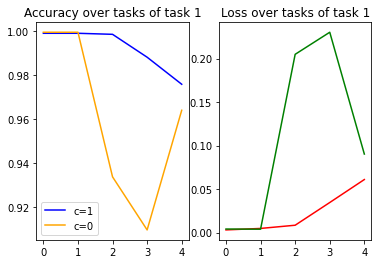

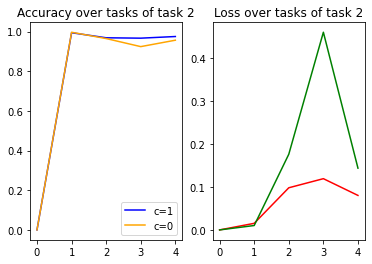

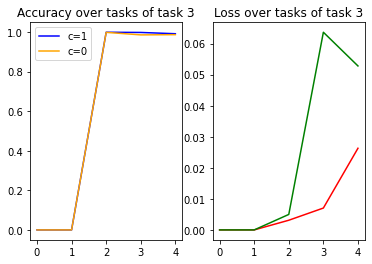

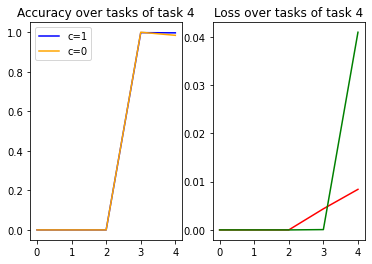

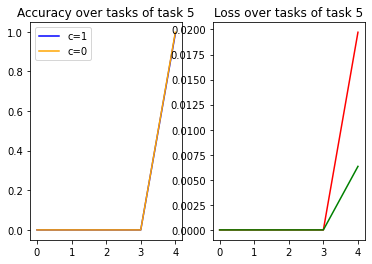

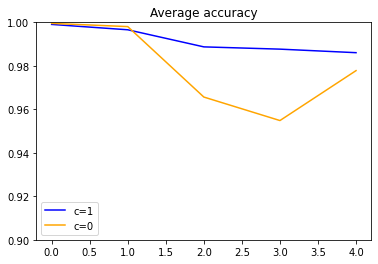

In [96]:
plot_res(
    task_cla,
    acc_res_with_consolidation,
    acc_res_without_consolidation,
    loss_res_with_consolidation,
    loss_res_without_consolidation
)

##Training on ConvNet network and CIFAR100 dataset

In [109]:
def train_convnet_mode(c, input_size, task_cla, data):
    model = ConvNet(
    inputsize= input_size,
    taskcla = task_cla
    ).to(device)

    si = SI(model, split=True, c= c, num_epochs=50)

    acc_res = np.zeros((len(task_cla), len(task_cla)), dtype=np)
    loss_res = np.zeros((len(task_cla), len(task_cla)), dtype=np)

    for t, n_class in task_cla:
        print("Task {:d}:, data name: {:s}".format(t, data[t]['name']))
        
        x_train = data[t]['train']['x'].to(device)
        y_train = data[t]['train']['y'].to(device)
        x_val = data[t]['valid']['x'].to(device)
        y_val = data[t]['valid']['y'].to(device)
        # x_train = data[t]['train']['x']
        # y_train = data[t]['train']['y']
        # x_val = data[t]['valid']['x']
        # y_val = data[t]['valid']['y']
        task = t

        #train
        print('TRAINING PHASE...')
        si.train(
            task,
            x_train= x_train, 
            y_train= y_train,
            x_val= x_val,
            y_val= y_val,
            data= data, input_size= size, task_cla= task_cla,
        )

        #test
        print('TESTING PHASE...')
        for u in range(t + 1):
            x_test = data[u]['test']['x'].to(device)
            y_test = data[u]['test']['y'].to(device)

            test_loss, test_acc = si.eval(u, x_test, y_test)
            print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                        100 * test_acc))

            acc_res[t, u] = test_acc
            loss_res[t, u] = test_loss
    
    return acc_res, loss_res

In [110]:
cf100_acc_w_c, cf100_loss_w_c = train_convnet_mode(
    c=1,
    input_size=input_size_cf100,
    task_cla=task_cla_cf100,
    data= data_cf100
)

Task 0:, data name: cifar100-6
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:29,  1.67it/s]

train_loss: 2.0283, train_acc: 0.2633
val_loss: 2.0329, val_acc: 0.2820
 *

  4%|▍         | 2/50 [00:01<00:28,  1.66it/s]

train_loss: 1.8104, train_acc: 0.3502
val_loss: 1.8312, val_acc: 0.3400
 *

  6%|▌         | 3/50 [00:01<00:28,  1.67it/s]

train_loss: 1.6690, train_acc: 0.4118
val_loss: 1.7220, val_acc: 0.4140
 *

  8%|▊         | 4/50 [00:02<00:27,  1.68it/s]

train_loss: 1.5064, train_acc: 0.4731
val_loss: 1.5735, val_acc: 0.4660
 *

 10%|█         | 5/50 [00:02<00:26,  1.68it/s]

train_loss: 1.4053, train_acc: 0.5213
val_loss: 1.5243, val_acc: 0.4840
 *

 12%|█▏        | 6/50 [00:03<00:26,  1.69it/s]

train_loss: 1.2806, train_acc: 0.5500
val_loss: 1.3945, val_acc: 0.5400
 *

 14%|█▍        | 7/50 [00:04<00:25,  1.69it/s]

train_loss: 1.1959, train_acc: 0.6122
val_loss: 1.3378, val_acc: 0.5520
 *

 16%|█▌        | 8/50 [00:04<00:24,  1.70it/s]

train_loss: 1.1741, train_acc: 0.6116
val_loss: 1.3521, val_acc: 0.5500


 18%|█▊        | 9/50 [00:05<00:24,  1.70it/s]

train_loss: 1.0462, train_acc: 0.6604
val_loss: 1.2177, val_acc: 0.5880
 *

 20%|██        | 10/50 [00:05<00:23,  1.70it/s]

train_loss: 0.9648, train_acc: 0.6767
val_loss: 1.1987, val_acc: 0.6100
 *

 22%|██▏       | 11/50 [00:06<00:23,  1.70it/s]

train_loss: 0.9241, train_acc: 0.6980
val_loss: 1.1861, val_acc: 0.6240
 *

 24%|██▍       | 12/50 [00:07<00:22,  1.69it/s]

train_loss: 0.8482, train_acc: 0.7211
val_loss: 1.1380, val_acc: 0.6180
 *

 26%|██▌       | 13/50 [00:07<00:21,  1.70it/s]

train_loss: 0.7785, train_acc: 0.7498
val_loss: 1.0963, val_acc: 0.6400
 *

 28%|██▊       | 14/50 [00:08<00:21,  1.70it/s]

train_loss: 0.7487, train_acc: 0.7480
val_loss: 1.1511, val_acc: 0.6380


 30%|███       | 15/50 [00:08<00:20,  1.70it/s]

train_loss: 0.6992, train_acc: 0.7678
val_loss: 1.0736, val_acc: 0.6220
 *

 32%|███▏      | 16/50 [00:09<00:20,  1.70it/s]

train_loss: 0.6247, train_acc: 0.7958
val_loss: 1.0654, val_acc: 0.6620
 *

 34%|███▍      | 17/50 [00:10<00:19,  1.70it/s]

train_loss: 0.6019, train_acc: 0.8173
val_loss: 1.0441, val_acc: 0.6440
 *

 36%|███▌      | 18/50 [00:10<00:18,  1.69it/s]

train_loss: 0.5794, train_acc: 0.8158
val_loss: 1.0368, val_acc: 0.6700
 *

 38%|███▊      | 19/50 [00:11<00:18,  1.69it/s]

train_loss: 0.4844, train_acc: 0.8404
val_loss: 1.0142, val_acc: 0.6820
 *

 40%|████      | 20/50 [00:11<00:17,  1.70it/s]

train_loss: 0.4593, train_acc: 0.8524
val_loss: 1.0354, val_acc: 0.6820


 42%|████▏     | 21/50 [00:12<00:17,  1.70it/s]

train_loss: 0.4394, train_acc: 0.8600
val_loss: 1.0219, val_acc: 0.6660


 44%|████▍     | 22/50 [00:13<00:16,  1.69it/s]

train_loss: 0.3990, train_acc: 0.8711
val_loss: 0.9863, val_acc: 0.7080
 *

 46%|████▌     | 23/50 [00:13<00:15,  1.69it/s]

train_loss: 0.3939, train_acc: 0.8762
val_loss: 0.9970, val_acc: 0.6880


 48%|████▊     | 24/50 [00:14<00:15,  1.70it/s]

train_loss: 0.3807, train_acc: 0.8736
val_loss: 1.0905, val_acc: 0.6920


 50%|█████     | 25/50 [00:14<00:14,  1.70it/s]

train_loss: 0.3890, train_acc: 0.8729
val_loss: 1.0157, val_acc: 0.6840


 52%|█████▏    | 26/50 [00:15<00:14,  1.71it/s]

train_loss: 0.3768, train_acc: 0.8840
val_loss: 1.0305, val_acc: 0.7040


 54%|█████▍    | 27/50 [00:15<00:13,  1.70it/s]

train_loss: 0.3732, train_acc: 0.8824
val_loss: 1.0020, val_acc: 0.6780


 56%|█████▌    | 28/50 [00:16<00:12,  1.70it/s]

train_loss: 0.3702, train_acc: 0.8838
val_loss: 0.9762, val_acc: 0.7040
 *

 58%|█████▊    | 29/50 [00:17<00:12,  1.70it/s]

train_loss: 0.3515, train_acc: 0.8900
val_loss: 1.0153, val_acc: 0.6980


 60%|██████    | 30/50 [00:17<00:11,  1.69it/s]

train_loss: 0.3458, train_acc: 0.8938
val_loss: 0.9608, val_acc: 0.6980
 *

 62%|██████▏   | 31/50 [00:18<00:11,  1.70it/s]

train_loss: 0.3174, train_acc: 0.9029
val_loss: 0.9953, val_acc: 0.7160


 64%|██████▍   | 32/50 [00:18<00:10,  1.70it/s]

train_loss: 0.3247, train_acc: 0.9009
val_loss: 0.9846, val_acc: 0.6980


 66%|██████▌   | 33/50 [00:19<00:09,  1.70it/s]

train_loss: 0.3159, train_acc: 0.9018
val_loss: 1.0056, val_acc: 0.7160


 68%|██████▊   | 34/50 [00:20<00:09,  1.71it/s]

train_loss: 0.3159, train_acc: 0.9058
val_loss: 0.9956, val_acc: 0.7140


 70%|███████   | 35/50 [00:20<00:08,  1.71it/s]

train_loss: 0.3206, train_acc: 0.8967
val_loss: 1.0299, val_acc: 0.7100


 72%|███████▏  | 36/50 [00:21<00:08,  1.71it/s]

train_loss: 0.3251, train_acc: 0.8924
val_loss: 1.0248, val_acc: 0.7060


 74%|███████▍  | 37/50 [00:21<00:07,  1.71it/s]

train_loss: 0.3242, train_acc: 0.9007
val_loss: 0.9670, val_acc: 0.7000


 76%|███████▌  | 38/50 [00:22<00:07,  1.71it/s]

train_loss: 0.3163, train_acc: 0.8973
val_loss: 0.9994, val_acc: 0.7100


 78%|███████▊  | 39/50 [00:22<00:06,  1.71it/s]

train_loss: 0.3232, train_acc: 0.9000
val_loss: 0.9966, val_acc: 0.7040


 80%|████████  | 40/50 [00:23<00:05,  1.71it/s]

train_loss: 0.3233, train_acc: 0.8967
val_loss: 0.9860, val_acc: 0.7080


 82%|████████▏ | 41/50 [00:24<00:05,  1.71it/s]

train_loss: 0.3221, train_acc: 0.8964
val_loss: 0.9947, val_acc: 0.7140


 84%|████████▍ | 42/50 [00:24<00:04,  1.71it/s]

train_loss: 0.3225, train_acc: 0.8980
val_loss: 0.9943, val_acc: 0.7100


 86%|████████▌ | 43/50 [00:25<00:04,  1.71it/s]

train_loss: 0.3220, train_acc: 0.8982
val_loss: 0.9954, val_acc: 0.7140


 88%|████████▊ | 44/50 [00:25<00:03,  1.71it/s]

train_loss: 0.3232, train_acc: 0.8969
val_loss: 0.9865, val_acc: 0.7120


 90%|█████████ | 45/50 [00:26<00:02,  1.71it/s]

train_loss: 0.3226, train_acc: 0.8962
val_loss: 0.9899, val_acc: 0.7120


 92%|█████████▏| 46/50 [00:27<00:02,  1.71it/s]

train_loss: 0.3285, train_acc: 0.8967
val_loss: 0.9778, val_acc: 0.7060


 94%|█████████▍| 47/50 [00:27<00:01,  1.71it/s]

train_loss: 0.3296, train_acc: 0.8947
val_loss: 0.9741, val_acc: 0.7100


 96%|█████████▌| 48/50 [00:28<00:01,  1.71it/s]

train_loss: 0.3290, train_acc: 0.8964
val_loss: 0.9722, val_acc: 0.7080


 98%|█████████▊| 49/50 [00:28<00:00,  1.71it/s]

train_loss: 0.3282, train_acc: 0.8964
val_loss: 0.9734, val_acc: 0.7100


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


train_loss: 0.3292, train_acc: 0.8964
val_loss: 0.9769, val_acc: 0.7100
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=0.951, acc= 70.9% <<<
Task 1:, data name: cifar100-3
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:33,  1.47it/s]

train_loss: 2.0221, train_acc: 0.3624
val_loss: 2.0930, val_acc: 0.3240
 *

  4%|▍         | 2/50 [00:01<00:32,  1.46it/s]

train_loss: 1.6770, train_acc: 0.4978
val_loss: 1.8128, val_acc: 0.4280
 *

  6%|▌         | 3/50 [00:02<00:32,  1.46it/s]

train_loss: 1.4574, train_acc: 0.5313
val_loss: 1.6088, val_acc: 0.4800
 *

  8%|▊         | 4/50 [00:02<00:31,  1.47it/s]

train_loss: 1.2631, train_acc: 0.6018
val_loss: 1.4917, val_acc: 0.5160
 *

 10%|█         | 5/50 [00:03<00:30,  1.46it/s]

train_loss: 1.2299, train_acc: 0.6144
val_loss: 1.4804, val_acc: 0.5120
 *

 12%|█▏        | 6/50 [00:04<00:30,  1.46it/s]

train_loss: 1.1205, train_acc: 0.6889
val_loss: 1.3713, val_acc: 0.5580
 *

 14%|█▍        | 7/50 [00:04<00:29,  1.47it/s]

train_loss: 1.0484, train_acc: 0.6924
val_loss: 1.3243, val_acc: 0.5820
 *

 16%|█▌        | 8/50 [00:05<00:28,  1.47it/s]

train_loss: 0.9640, train_acc: 0.7116
val_loss: 1.3509, val_acc: 0.5800


 18%|█▊        | 9/50 [00:06<00:27,  1.47it/s]

train_loss: 0.9704, train_acc: 0.7224
val_loss: 1.3053, val_acc: 0.6000
 *

 20%|██        | 10/50 [00:06<00:27,  1.46it/s]

train_loss: 0.8790, train_acc: 0.7513
val_loss: 1.2631, val_acc: 0.6180
 *

 22%|██▏       | 11/50 [00:07<00:26,  1.46it/s]

train_loss: 0.9373, train_acc: 0.7282
val_loss: 1.3361, val_acc: 0.6000


 24%|██▍       | 12/50 [00:08<00:25,  1.46it/s]

train_loss: 0.8062, train_acc: 0.7869
val_loss: 1.2276, val_acc: 0.6460
 *

 26%|██▌       | 13/50 [00:08<00:25,  1.47it/s]

train_loss: 0.7708, train_acc: 0.7991
val_loss: 1.2494, val_acc: 0.6620


 28%|██▊       | 14/50 [00:09<00:24,  1.47it/s]

train_loss: 0.7700, train_acc: 0.7922
val_loss: 1.2412, val_acc: 0.6300


 30%|███       | 15/50 [00:10<00:23,  1.47it/s]

train_loss: 0.8015, train_acc: 0.7822
val_loss: 1.2759, val_acc: 0.6060


 32%|███▏      | 16/50 [00:10<00:23,  1.47it/s]

train_loss: 0.8201, train_acc: 0.7680
val_loss: 1.3098, val_acc: 0.6240


 34%|███▍      | 17/50 [00:11<00:22,  1.48it/s]

train_loss: 0.7512, train_acc: 0.7960
val_loss: 1.2505, val_acc: 0.6480


 36%|███▌      | 18/50 [00:12<00:21,  1.47it/s]

train_loss: 0.6815, train_acc: 0.8018
val_loss: 1.1366, val_acc: 0.6380
 *

 38%|███▊      | 19/50 [00:12<00:21,  1.47it/s]

train_loss: 0.6406, train_acc: 0.8102
val_loss: 1.1158, val_acc: 0.6540
 *

 40%|████      | 20/50 [00:13<00:20,  1.47it/s]

train_loss: 0.5883, train_acc: 0.8264
val_loss: 1.1246, val_acc: 0.6340


 42%|████▏     | 21/50 [00:14<00:19,  1.47it/s]

train_loss: 0.5977, train_acc: 0.8209
val_loss: 1.1338, val_acc: 0.6540


 44%|████▍     | 22/50 [00:14<00:18,  1.48it/s]

train_loss: 0.6089, train_acc: 0.8176
val_loss: 1.1289, val_acc: 0.6580


 46%|████▌     | 23/50 [00:15<00:18,  1.48it/s]

train_loss: 0.5926, train_acc: 0.8204
val_loss: 1.1371, val_acc: 0.6360


 48%|████▊     | 24/50 [00:16<00:17,  1.48it/s]

train_loss: 0.5894, train_acc: 0.8242
val_loss: 1.1389, val_acc: 0.6460


 50%|█████     | 25/50 [00:17<00:16,  1.47it/s]

train_loss: 0.5881, train_acc: 0.8158
val_loss: 1.1122, val_acc: 0.6360
 *

 52%|█████▏    | 26/50 [00:17<00:16,  1.47it/s]

train_loss: 0.5851, train_acc: 0.8136
val_loss: 1.1292, val_acc: 0.6380


 54%|█████▍    | 27/50 [00:18<00:15,  1.47it/s]

train_loss: 0.5767, train_acc: 0.8198
val_loss: 1.1165, val_acc: 0.6520


 56%|█████▌    | 28/50 [00:19<00:14,  1.47it/s]

train_loss: 0.5611, train_acc: 0.8280
val_loss: 1.0946, val_acc: 0.6460
 *

 58%|█████▊    | 29/50 [00:19<00:14,  1.47it/s]

train_loss: 0.5409, train_acc: 0.8351
val_loss: 1.1066, val_acc: 0.6380


 60%|██████    | 30/50 [00:20<00:13,  1.48it/s]

train_loss: 0.5509, train_acc: 0.8347
val_loss: 1.1065, val_acc: 0.6460


 62%|██████▏   | 31/50 [00:21<00:12,  1.47it/s]

train_loss: 0.5451, train_acc: 0.8349
val_loss: 1.1016, val_acc: 0.6340


 64%|██████▍   | 32/50 [00:21<00:12,  1.47it/s]

train_loss: 0.5569, train_acc: 0.8278
val_loss: 1.1165, val_acc: 0.6460


 66%|██████▌   | 33/50 [00:22<00:11,  1.47it/s]

train_loss: 0.5569, train_acc: 0.8278
val_loss: 1.0934, val_acc: 0.6520
 *

 68%|██████▊   | 34/50 [00:23<00:10,  1.47it/s]

train_loss: 0.5401, train_acc: 0.8376
val_loss: 1.1021, val_acc: 0.6440


 70%|███████   | 35/50 [00:23<00:10,  1.47it/s]

train_loss: 0.5380, train_acc: 0.8373
val_loss: 1.0955, val_acc: 0.6440


 72%|███████▏  | 36/50 [00:24<00:09,  1.47it/s]

train_loss: 0.5335, train_acc: 0.8393
val_loss: 1.1056, val_acc: 0.6520


 74%|███████▍  | 37/50 [00:25<00:08,  1.48it/s]

train_loss: 0.5411, train_acc: 0.8344
val_loss: 1.1065, val_acc: 0.6460


 76%|███████▌  | 38/50 [00:25<00:08,  1.48it/s]

train_loss: 0.5351, train_acc: 0.8380
val_loss: 1.1013, val_acc: 0.6460


 78%|███████▊  | 39/50 [00:26<00:07,  1.48it/s]

train_loss: 0.5356, train_acc: 0.8384
val_loss: 1.0945, val_acc: 0.6500


 80%|████████  | 40/50 [00:27<00:06,  1.47it/s]

train_loss: 0.5352, train_acc: 0.8362
val_loss: 1.0918, val_acc: 0.6520
 *

 82%|████████▏ | 41/50 [00:27<00:06,  1.47it/s]

train_loss: 0.5329, train_acc: 0.8369
val_loss: 1.0928, val_acc: 0.6540


 84%|████████▍ | 42/50 [00:28<00:05,  1.48it/s]

train_loss: 0.5301, train_acc: 0.8373
val_loss: 1.0967, val_acc: 0.6480


 86%|████████▌ | 43/50 [00:29<00:04,  1.48it/s]

train_loss: 0.5324, train_acc: 0.8369
val_loss: 1.0970, val_acc: 0.6520


 88%|████████▊ | 44/50 [00:29<00:04,  1.48it/s]

train_loss: 0.5320, train_acc: 0.8362
val_loss: 1.0948, val_acc: 0.6540


 90%|█████████ | 45/50 [00:30<00:03,  1.48it/s]

train_loss: 0.5316, train_acc: 0.8367
val_loss: 1.0946, val_acc: 0.6520


 92%|█████████▏| 46/50 [00:31<00:02,  1.48it/s]

train_loss: 0.5334, train_acc: 0.8364
val_loss: 1.0909, val_acc: 0.6580
 *

 94%|█████████▍| 47/50 [00:31<00:02,  1.47it/s]

train_loss: 0.5301, train_acc: 0.8364
val_loss: 1.0896, val_acc: 0.6500
 *

 96%|█████████▌| 48/50 [00:32<00:01,  1.47it/s]

train_loss: 0.5300, train_acc: 0.8387
val_loss: 1.0948, val_acc: 0.6560


 98%|█████████▊| 49/50 [00:33<00:00,  1.47it/s]

train_loss: 0.5281, train_acc: 0.8387
val_loss: 1.0933, val_acc: 0.6520


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


train_loss: 0.5318, train_acc: 0.8382
val_loss: 1.0959, val_acc: 0.6560
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.390, acc= 55.0% <<<
>>> Test on task  1 - cifar100-3     : loss=1.054, acc= 64.7% <<<
Task 2:, data name: cifar100-9
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:34,  1.42it/s]

train_loss: 1.7691, train_acc: 0.5216
val_loss: 1.7778, val_acc: 0.5060
 *

  4%|▍         | 2/50 [00:01<00:33,  1.42it/s]

train_loss: 1.4969, train_acc: 0.5804
val_loss: 1.5306, val_acc: 0.5720
 *

  6%|▌         | 3/50 [00:02<00:33,  1.42it/s]

train_loss: 1.2488, train_acc: 0.6509
val_loss: 1.3171, val_acc: 0.6140
 *

  8%|▊         | 4/50 [00:02<00:32,  1.42it/s]

train_loss: 1.1403, train_acc: 0.6667
val_loss: 1.2239, val_acc: 0.6060
 *

 10%|█         | 5/50 [00:03<00:31,  1.42it/s]

train_loss: 1.0660, train_acc: 0.7087
val_loss: 1.1967, val_acc: 0.6320
 *

 12%|█▏        | 6/50 [00:04<00:30,  1.42it/s]

train_loss: 1.0545, train_acc: 0.6973
val_loss: 1.1808, val_acc: 0.6440
 *

 14%|█▍        | 7/50 [00:04<00:30,  1.42it/s]

train_loss: 0.9281, train_acc: 0.7413
val_loss: 1.1067, val_acc: 0.6700
 *

 16%|█▌        | 8/50 [00:05<00:29,  1.42it/s]

train_loss: 0.8642, train_acc: 0.7644
val_loss: 1.0722, val_acc: 0.6740
 *

 18%|█▊        | 9/50 [00:06<00:28,  1.43it/s]

train_loss: 0.8786, train_acc: 0.7482
val_loss: 1.1057, val_acc: 0.6800


 20%|██        | 10/50 [00:07<00:27,  1.43it/s]

train_loss: 0.8422, train_acc: 0.7809
val_loss: 1.0752, val_acc: 0.6940


 22%|██▏       | 11/50 [00:07<00:27,  1.43it/s]

train_loss: 0.8371, train_acc: 0.7822
val_loss: 1.0598, val_acc: 0.6960
 *

 24%|██▍       | 12/50 [00:08<00:26,  1.43it/s]

train_loss: 0.8234, train_acc: 0.7793
val_loss: 1.0789, val_acc: 0.6680


 26%|██▌       | 13/50 [00:09<00:25,  1.43it/s]

train_loss: 0.8272, train_acc: 0.7951
val_loss: 1.0765, val_acc: 0.6760


 28%|██▊       | 14/50 [00:09<00:25,  1.43it/s]

train_loss: 0.7811, train_acc: 0.7996
val_loss: 1.0370, val_acc: 0.7020
 *

 30%|███       | 15/50 [00:10<00:24,  1.43it/s]

train_loss: 0.8276, train_acc: 0.7900
val_loss: 1.0887, val_acc: 0.6820


 32%|███▏      | 16/50 [00:11<00:23,  1.43it/s]

train_loss: 0.7740, train_acc: 0.8164
val_loss: 1.0373, val_acc: 0.7020


 34%|███▍      | 17/50 [00:11<00:23,  1.43it/s]

train_loss: 0.7855, train_acc: 0.7991
val_loss: 1.0738, val_acc: 0.6940


 36%|███▌      | 18/50 [00:12<00:22,  1.43it/s]

train_loss: 0.7763, train_acc: 0.7958
val_loss: 1.0393, val_acc: 0.7020


 38%|███▊      | 19/50 [00:13<00:21,  1.43it/s]

train_loss: 0.7838, train_acc: 0.7927
val_loss: 1.0689, val_acc: 0.6920


 40%|████      | 20/50 [00:14<00:21,  1.42it/s]

train_loss: 0.6625, train_acc: 0.8120
val_loss: 0.9334, val_acc: 0.7140
 *

 42%|████▏     | 21/50 [00:14<00:20,  1.42it/s]

train_loss: 0.6244, train_acc: 0.8164
val_loss: 0.9043, val_acc: 0.7020
 *

 44%|████▍     | 22/50 [00:15<00:19,  1.43it/s]

train_loss: 0.5942, train_acc: 0.8216
val_loss: 0.9067, val_acc: 0.7100


 46%|████▌     | 23/50 [00:16<00:18,  1.43it/s]

train_loss: 0.5691, train_acc: 0.8336
val_loss: 0.8907, val_acc: 0.7180
 *

 48%|████▊     | 24/50 [00:16<00:18,  1.43it/s]

train_loss: 0.5357, train_acc: 0.8462
val_loss: 0.8842, val_acc: 0.7240
 *

 50%|█████     | 25/50 [00:17<00:17,  1.43it/s]

train_loss: 0.5221, train_acc: 0.8496
val_loss: 0.9043, val_acc: 0.7140


 52%|█████▏    | 26/50 [00:18<00:16,  1.43it/s]

train_loss: 0.5305, train_acc: 0.8502
val_loss: 0.8847, val_acc: 0.7240


 54%|█████▍    | 27/50 [00:18<00:16,  1.43it/s]

train_loss: 0.5208, train_acc: 0.8560
val_loss: 0.8818, val_acc: 0.7220
 *

 56%|█████▌    | 28/50 [00:19<00:15,  1.43it/s]

train_loss: 0.5014, train_acc: 0.8591
val_loss: 0.9000, val_acc: 0.7220


 58%|█████▊    | 29/50 [00:20<00:14,  1.43it/s]

train_loss: 0.5099, train_acc: 0.8573
val_loss: 0.8962, val_acc: 0.7140


 60%|██████    | 30/50 [00:21<00:13,  1.43it/s]

train_loss: 0.5048, train_acc: 0.8611
val_loss: 0.8708, val_acc: 0.7360
 *

 62%|██████▏   | 31/50 [00:21<00:13,  1.43it/s]

train_loss: 0.4872, train_acc: 0.8611
val_loss: 0.8781, val_acc: 0.7280


 64%|██████▍   | 32/50 [00:22<00:12,  1.43it/s]

train_loss: 0.4822, train_acc: 0.8682
val_loss: 0.8875, val_acc: 0.7300


 66%|██████▌   | 33/50 [00:23<00:11,  1.43it/s]

train_loss: 0.4974, train_acc: 0.8538
val_loss: 0.8908, val_acc: 0.7340


 68%|██████▊   | 34/50 [00:23<00:11,  1.43it/s]

train_loss: 0.4842, train_acc: 0.8720
val_loss: 0.8759, val_acc: 0.7380


 70%|███████   | 35/50 [00:24<00:10,  1.43it/s]

train_loss: 0.4934, train_acc: 0.8629
val_loss: 0.8817, val_acc: 0.7340


 72%|███████▏  | 36/50 [00:25<00:09,  1.43it/s]

train_loss: 0.4903, train_acc: 0.8509
val_loss: 0.8566, val_acc: 0.7320
 *

 74%|███████▍  | 37/50 [00:25<00:09,  1.43it/s]

train_loss: 0.4330, train_acc: 0.8700
val_loss: 0.8322, val_acc: 0.7360
 *

 76%|███████▌  | 38/50 [00:26<00:08,  1.43it/s]

train_loss: 0.4270, train_acc: 0.8720
val_loss: 0.8308, val_acc: 0.7420
 *

 78%|███████▊  | 39/50 [00:27<00:07,  1.43it/s]

train_loss: 0.4107, train_acc: 0.8811
val_loss: 0.8269, val_acc: 0.7320
 *

 80%|████████  | 40/50 [00:28<00:07,  1.42it/s]

train_loss: 0.4070, train_acc: 0.8822
val_loss: 0.8301, val_acc: 0.7340


 82%|████████▏ | 41/50 [00:28<00:06,  1.42it/s]

train_loss: 0.4151, train_acc: 0.8760
val_loss: 0.8321, val_acc: 0.7320


 84%|████████▍ | 42/50 [00:29<00:05,  1.43it/s]

train_loss: 0.4041, train_acc: 0.8856
val_loss: 0.8314, val_acc: 0.7320


 86%|████████▌ | 43/50 [00:30<00:04,  1.43it/s]

train_loss: 0.4114, train_acc: 0.8842
val_loss: 0.8352, val_acc: 0.7220


 88%|████████▊ | 44/50 [00:30<00:04,  1.43it/s]

train_loss: 0.4050, train_acc: 0.8833
val_loss: 0.8365, val_acc: 0.7440


 90%|█████████ | 45/50 [00:31<00:03,  1.43it/s]

train_loss: 0.3994, train_acc: 0.8802
val_loss: 0.8259, val_acc: 0.7400
 *

 92%|█████████▏| 46/50 [00:32<00:02,  1.43it/s]

train_loss: 0.3934, train_acc: 0.8827
val_loss: 0.8245, val_acc: 0.7360
 *

 94%|█████████▍| 47/50 [00:32<00:02,  1.43it/s]

train_loss: 0.3974, train_acc: 0.8798
val_loss: 0.8227, val_acc: 0.7420
 *

 96%|█████████▌| 48/50 [00:33<00:01,  1.43it/s]

train_loss: 0.3855, train_acc: 0.8818
val_loss: 0.8254, val_acc: 0.7400


 98%|█████████▊| 49/50 [00:34<00:00,  1.43it/s]

train_loss: 0.3850, train_acc: 0.8831
val_loss: 0.8294, val_acc: 0.7380


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]

train_loss: 0.3864, train_acc: 0.8820
val_loss: 0.8244, val_acc: 0.7380
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.632, acc= 44.9% <<<
>>> Test on task  1 - cifar100-3     : loss=1.390, acc= 49.9% <<<
>>> Test on task  2 - cifar100-9     : loss=0.915, acc= 70.5% <<<
Task 3:, data name: cifar100-5


TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:35,  1.39it/s]

train_loss: 1.8120, train_acc: 0.5640
val_loss: 1.8417, val_acc: 0.5500
 *

  4%|▍         | 2/50 [00:01<00:34,  1.39it/s]

train_loss: 1.3931, train_acc: 0.6411
val_loss: 1.4605, val_acc: 0.6060
 *

  6%|▌         | 3/50 [00:02<00:33,  1.39it/s]

train_loss: 1.1946, train_acc: 0.6680
val_loss: 1.3333, val_acc: 0.5980
 *

  8%|▊         | 4/50 [00:02<00:33,  1.39it/s]

train_loss: 1.0375, train_acc: 0.7258
val_loss: 1.2178, val_acc: 0.6460
 *

 10%|█         | 5/50 [00:03<00:32,  1.39it/s]

train_loss: 1.0261, train_acc: 0.7291
val_loss: 1.1929, val_acc: 0.6720
 *

 12%|█▏        | 6/50 [00:04<00:31,  1.39it/s]

train_loss: 0.9367, train_acc: 0.7469
val_loss: 1.1250, val_acc: 0.6760
 *

 14%|█▍        | 7/50 [00:05<00:30,  1.39it/s]

train_loss: 0.8667, train_acc: 0.7789
val_loss: 1.0845, val_acc: 0.6760
 *

 16%|█▌        | 8/50 [00:05<00:30,  1.39it/s]

train_loss: 0.8786, train_acc: 0.7760
val_loss: 1.1091, val_acc: 0.6940


 18%|█▊        | 9/50 [00:06<00:29,  1.39it/s]

train_loss: 0.8523, train_acc: 0.7749
val_loss: 1.1200, val_acc: 0.6620


 20%|██        | 10/50 [00:07<00:28,  1.39it/s]

train_loss: 0.8600, train_acc: 0.7782
val_loss: 1.1205, val_acc: 0.6600


 22%|██▏       | 11/50 [00:07<00:28,  1.39it/s]

train_loss: 0.8417, train_acc: 0.7893
val_loss: 1.0931, val_acc: 0.6740


 24%|██▍       | 12/50 [00:08<00:27,  1.39it/s]

train_loss: 0.8335, train_acc: 0.7833
val_loss: 1.0924, val_acc: 0.6960


 26%|██▌       | 13/50 [00:09<00:26,  1.39it/s]

train_loss: 0.7440, train_acc: 0.7882
val_loss: 1.0000, val_acc: 0.6760
 *

 28%|██▊       | 14/50 [00:10<00:25,  1.39it/s]

train_loss: 0.6915, train_acc: 0.7949
val_loss: 0.9621, val_acc: 0.6940
 *

 30%|███       | 15/50 [00:10<00:25,  1.39it/s]

train_loss: 0.6600, train_acc: 0.8093
val_loss: 0.9558, val_acc: 0.6860
 *

 32%|███▏      | 16/50 [00:11<00:24,  1.38it/s]

train_loss: 0.6304, train_acc: 0.8220
val_loss: 0.9491, val_acc: 0.6920
 *

 34%|███▍      | 17/50 [00:12<00:23,  1.38it/s]

train_loss: 0.6180, train_acc: 0.8189
val_loss: 0.9392, val_acc: 0.6860
 *

 36%|███▌      | 18/50 [00:12<00:23,  1.38it/s]

train_loss: 0.5888, train_acc: 0.8316
val_loss: 0.9443, val_acc: 0.6940


 38%|███▊      | 19/50 [00:13<00:22,  1.38it/s]

train_loss: 0.5735, train_acc: 0.8380
val_loss: 0.9359, val_acc: 0.6920
 *

 40%|████      | 20/50 [00:14<00:21,  1.38it/s]

train_loss: 0.5861, train_acc: 0.8329
val_loss: 0.9357, val_acc: 0.7040
 *

 42%|████▏     | 21/50 [00:15<00:20,  1.38it/s]

train_loss: 0.5373, train_acc: 0.8531
val_loss: 0.9239, val_acc: 0.6980
 *

 44%|████▍     | 22/50 [00:15<00:20,  1.39it/s]

train_loss: 0.5318, train_acc: 0.8571
val_loss: 0.9346, val_acc: 0.7040


 46%|████▌     | 23/50 [00:16<00:19,  1.39it/s]

train_loss: 0.5277, train_acc: 0.8584
val_loss: 0.9117, val_acc: 0.7140
 *

 48%|████▊     | 24/50 [00:17<00:18,  1.39it/s]

train_loss: 0.5095, train_acc: 0.8569
val_loss: 0.9356, val_acc: 0.7080


 50%|█████     | 25/50 [00:18<00:17,  1.39it/s]

train_loss: 0.5058, train_acc: 0.8633
val_loss: 0.9172, val_acc: 0.7000


 52%|█████▏    | 26/50 [00:18<00:17,  1.39it/s]

train_loss: 0.4941, train_acc: 0.8656
val_loss: 0.9126, val_acc: 0.7160


 54%|█████▍    | 27/50 [00:19<00:16,  1.39it/s]

train_loss: 0.4913, train_acc: 0.8696
val_loss: 0.9013, val_acc: 0.7080
 *

 56%|█████▌    | 28/50 [00:20<00:15,  1.39it/s]

train_loss: 0.4819, train_acc: 0.8667
val_loss: 0.9257, val_acc: 0.7060


 58%|█████▊    | 29/50 [00:20<00:15,  1.38it/s]

train_loss: 0.4808, train_acc: 0.8702
val_loss: 0.9107, val_acc: 0.7080


 60%|██████    | 30/50 [00:21<00:14,  1.38it/s]

train_loss: 0.4840, train_acc: 0.8656
val_loss: 0.9078, val_acc: 0.7100


 62%|██████▏   | 31/50 [00:22<00:13,  1.39it/s]

train_loss: 0.4742, train_acc: 0.8709
val_loss: 0.9186, val_acc: 0.7200


 64%|██████▍   | 32/50 [00:23<00:12,  1.39it/s]

train_loss: 0.4844, train_acc: 0.8702
val_loss: 0.9190, val_acc: 0.7080


 66%|██████▌   | 33/50 [00:23<00:12,  1.39it/s]

train_loss: 0.4434, train_acc: 0.8727
val_loss: 0.8708, val_acc: 0.7040
 *

 68%|██████▊   | 34/50 [00:24<00:11,  1.39it/s]

train_loss: 0.4203, train_acc: 0.8747
val_loss: 0.8620, val_acc: 0.7040
 *

 70%|███████   | 35/50 [00:25<00:10,  1.39it/s]

train_loss: 0.4080, train_acc: 0.8789
val_loss: 0.8580, val_acc: 0.7080
 *

 72%|███████▏  | 36/50 [00:25<00:10,  1.39it/s]

train_loss: 0.3975, train_acc: 0.8849
val_loss: 0.8550, val_acc: 0.7080
 *

 74%|███████▍  | 37/50 [00:26<00:09,  1.39it/s]

train_loss: 0.3903, train_acc: 0.8929
val_loss: 0.8534, val_acc: 0.7120
 *

 76%|███████▌  | 38/50 [00:27<00:08,  1.39it/s]

train_loss: 0.3836, train_acc: 0.8860
val_loss: 0.8629, val_acc: 0.7060


 78%|███████▊  | 39/50 [00:28<00:07,  1.39it/s]

train_loss: 0.3788, train_acc: 0.8924
val_loss: 0.8588, val_acc: 0.7140


 80%|████████  | 40/50 [00:28<00:07,  1.39it/s]

train_loss: 0.3829, train_acc: 0.8889
val_loss: 0.8647, val_acc: 0.7040


 82%|████████▏ | 41/50 [00:29<00:06,  1.39it/s]

train_loss: 0.3820, train_acc: 0.8922
val_loss: 0.8575, val_acc: 0.7160


 84%|████████▍ | 42/50 [00:30<00:05,  1.39it/s]

train_loss: 0.3785, train_acc: 0.8924
val_loss: 0.8554, val_acc: 0.7220


 86%|████████▌ | 43/50 [00:30<00:05,  1.39it/s]

train_loss: 0.3733, train_acc: 0.8902
val_loss: 0.8429, val_acc: 0.7160
 *

 88%|████████▊ | 44/50 [00:31<00:04,  1.39it/s]

train_loss: 0.3680, train_acc: 0.8909
val_loss: 0.8458, val_acc: 0.7160


 90%|█████████ | 45/50 [00:32<00:03,  1.39it/s]

train_loss: 0.3670, train_acc: 0.8911
val_loss: 0.8359, val_acc: 0.7140
 *

 92%|█████████▏| 46/50 [00:33<00:02,  1.39it/s]

train_loss: 0.3612, train_acc: 0.8924
val_loss: 0.8420, val_acc: 0.7120


 94%|█████████▍| 47/50 [00:33<00:02,  1.39it/s]

train_loss: 0.3641, train_acc: 0.8918
val_loss: 0.8406, val_acc: 0.7160


 96%|█████████▌| 48/50 [00:34<00:01,  1.39it/s]

train_loss: 0.3639, train_acc: 0.8900
val_loss: 0.8439, val_acc: 0.7060


 98%|█████████▊| 49/50 [00:35<00:00,  1.39it/s]

train_loss: 0.3654, train_acc: 0.8907
val_loss: 0.8471, val_acc: 0.7120


100%|██████████| 50/50 [00:36<00:00,  1.39it/s]

train_loss: 0.3689, train_acc: 0.8884
val_loss: 0.8509, val_acc: 0.7060
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.806, acc= 38.2% <<<
>>> Test on task  1 - cifar100-3     : loss=1.498, acc= 46.3% <<<


>>> Test on task  2 - cifar100-9     : loss=1.168, acc= 62.1% <<<
>>> Test on task  3 - cifar100-5     : loss=0.750, acc= 74.4% <<<
Task 4:, data name: cifar100-10
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:36,  1.34it/s]

train_loss: 2.0833, train_acc: 0.4391
val_loss: 2.0903, val_acc: 0.4000
 *

  4%|▍         | 2/50 [00:01<00:35,  1.34it/s]

train_loss: 1.6802, train_acc: 0.5238
val_loss: 1.7052, val_acc: 0.5020
 *

  6%|▌         | 3/50 [00:02<00:34,  1.35it/s]

train_loss: 1.4832, train_acc: 0.5751
val_loss: 1.5395, val_acc: 0.5300
 *

  8%|▊         | 4/50 [00:02<00:34,  1.35it/s]

train_loss: 1.4229, train_acc: 0.6060
val_loss: 1.4913, val_acc: 0.5680
 *

 10%|█         | 5/50 [00:03<00:33,  1.35it/s]

train_loss: 1.3534, train_acc: 0.6149
val_loss: 1.4469, val_acc: 0.5800
 *

 12%|█▏        | 6/50 [00:04<00:32,  1.35it/s]

train_loss: 1.3015, train_acc: 0.6484
val_loss: 1.4080, val_acc: 0.5840
 *

 14%|█▍        | 7/50 [00:05<00:31,  1.35it/s]

train_loss: 1.2315, train_acc: 0.6609
val_loss: 1.3629, val_acc: 0.6040
 *

 16%|█▌        | 8/50 [00:05<00:31,  1.35it/s]

train_loss: 1.1327, train_acc: 0.6800
val_loss: 1.2875, val_acc: 0.6080
 *

 18%|█▊        | 9/50 [00:06<00:30,  1.35it/s]

train_loss: 1.1346, train_acc: 0.6713
val_loss: 1.3521, val_acc: 0.5780


 20%|██        | 10/50 [00:07<00:29,  1.36it/s]

train_loss: 1.1092, train_acc: 0.6904
val_loss: 1.3097, val_acc: 0.6060


 22%|██▏       | 11/50 [00:08<00:28,  1.36it/s]

train_loss: 1.1444, train_acc: 0.6967
val_loss: 1.3325, val_acc: 0.5880


 24%|██▍       | 12/50 [00:08<00:28,  1.36it/s]

train_loss: 1.1507, train_acc: 0.6827
val_loss: 1.3226, val_acc: 0.6080


 26%|██▌       | 13/50 [00:09<00:27,  1.36it/s]

train_loss: 1.1546, train_acc: 0.6778
val_loss: 1.3322, val_acc: 0.6040


 28%|██▊       | 14/50 [00:10<00:26,  1.35it/s]

train_loss: 1.0194, train_acc: 0.6998
val_loss: 1.2081, val_acc: 0.6060
 *

 30%|███       | 15/50 [00:11<00:25,  1.35it/s]

train_loss: 0.9661, train_acc: 0.7029
val_loss: 1.1704, val_acc: 0.6040
 *

 32%|███▏      | 16/50 [00:11<00:25,  1.35it/s]

train_loss: 0.9378, train_acc: 0.7171
val_loss: 1.1555, val_acc: 0.6200
 *

 34%|███▍      | 17/50 [00:12<00:24,  1.35it/s]

train_loss: 0.9149, train_acc: 0.7189
val_loss: 1.1418, val_acc: 0.6300
 *

 36%|███▌      | 18/50 [00:13<00:23,  1.34it/s]

train_loss: 0.8631, train_acc: 0.7318
val_loss: 1.1333, val_acc: 0.6260
 *

 38%|███▊      | 19/50 [00:14<00:23,  1.34it/s]

train_loss: 0.8419, train_acc: 0.7513
val_loss: 1.1114, val_acc: 0.6300
 *

 40%|████      | 20/50 [00:14<00:22,  1.35it/s]

train_loss: 0.8425, train_acc: 0.7618
val_loss: 1.1060, val_acc: 0.6460
 *

 42%|████▏     | 21/50 [00:15<00:21,  1.35it/s]

train_loss: 0.8070, train_acc: 0.7616
val_loss: 1.1240, val_acc: 0.6440


 44%|████▍     | 22/50 [00:16<00:20,  1.35it/s]

train_loss: 0.8158, train_acc: 0.7616
val_loss: 1.1219, val_acc: 0.6320


 46%|████▌     | 23/50 [00:17<00:19,  1.35it/s]

train_loss: 0.8309, train_acc: 0.7544
val_loss: 1.1232, val_acc: 0.6440


 48%|████▊     | 24/50 [00:17<00:19,  1.36it/s]

train_loss: 0.7974, train_acc: 0.7631
val_loss: 1.1103, val_acc: 0.6520


 50%|█████     | 25/50 [00:18<00:18,  1.36it/s]

train_loss: 0.8104, train_acc: 0.7649
val_loss: 1.1147, val_acc: 0.6460


 52%|█████▏    | 26/50 [00:19<00:17,  1.35it/s]

train_loss: 0.7665, train_acc: 0.7618
val_loss: 1.0693, val_acc: 0.6360
 *

 54%|█████▍    | 27/50 [00:19<00:16,  1.35it/s]

train_loss: 0.7446, train_acc: 0.7642
val_loss: 1.0576, val_acc: 0.6400
 *

 56%|█████▌    | 28/50 [00:20<00:16,  1.35it/s]

train_loss: 0.7329, train_acc: 0.7751
val_loss: 1.0550, val_acc: 0.6380
 *

 58%|█████▊    | 29/50 [00:21<00:15,  1.35it/s]

train_loss: 0.7145, train_acc: 0.7793
val_loss: 1.0406, val_acc: 0.6500
 *

 60%|██████    | 30/50 [00:22<00:14,  1.35it/s]

train_loss: 0.7037, train_acc: 0.7787
val_loss: 1.0466, val_acc: 0.6440


 62%|██████▏   | 31/50 [00:22<00:14,  1.35it/s]

train_loss: 0.7008, train_acc: 0.7833
val_loss: 1.0465, val_acc: 0.6500


 64%|██████▍   | 32/50 [00:23<00:13,  1.36it/s]

train_loss: 0.6971, train_acc: 0.7818
val_loss: 1.0496, val_acc: 0.6400


 66%|██████▌   | 33/50 [00:24<00:12,  1.35it/s]

train_loss: 0.7004, train_acc: 0.7864
val_loss: 1.0379, val_acc: 0.6580
 *

 68%|██████▊   | 34/50 [00:25<00:11,  1.35it/s]

train_loss: 0.6896, train_acc: 0.7871
val_loss: 1.0362, val_acc: 0.6500
 *

 70%|███████   | 35/50 [00:25<00:11,  1.36it/s]

train_loss: 0.6798, train_acc: 0.7909
val_loss: 1.0370, val_acc: 0.6440


 72%|███████▏  | 36/50 [00:26<00:10,  1.36it/s]

train_loss: 0.6780, train_acc: 0.7949
val_loss: 1.0386, val_acc: 0.6500


 74%|███████▍  | 37/50 [00:27<00:09,  1.36it/s]

train_loss: 0.6863, train_acc: 0.7920
val_loss: 1.0360, val_acc: 0.6480
 *

 76%|███████▌  | 38/50 [00:28<00:08,  1.35it/s]

train_loss: 0.6738, train_acc: 0.7951
val_loss: 1.0370, val_acc: 0.6420


 78%|███████▊  | 39/50 [00:28<00:08,  1.35it/s]

train_loss: 0.6670, train_acc: 0.7976
val_loss: 1.0330, val_acc: 0.6560
 *

 80%|████████  | 40/50 [00:29<00:07,  1.35it/s]

train_loss: 0.6604, train_acc: 0.8011
val_loss: 1.0336, val_acc: 0.6620


 82%|████████▏ | 41/50 [00:30<00:06,  1.35it/s]

train_loss: 0.6528, train_acc: 0.7993
val_loss: 1.0363, val_acc: 0.6520


 84%|████████▍ | 42/50 [00:31<00:05,  1.36it/s]

train_loss: 0.6537, train_acc: 0.8000
val_loss: 1.0452, val_acc: 0.6420


 86%|████████▌ | 43/50 [00:31<00:05,  1.35it/s]

train_loss: 0.6588, train_acc: 0.7987
val_loss: 1.0323, val_acc: 0.6460
 *

 88%|████████▊ | 44/50 [00:32<00:04,  1.36it/s]

train_loss: 0.6552, train_acc: 0.7967
val_loss: 1.0417, val_acc: 0.6380


 90%|█████████ | 45/50 [00:33<00:03,  1.36it/s]

train_loss: 0.6447, train_acc: 0.8047
val_loss: 1.0336, val_acc: 0.6500


 92%|█████████▏| 46/50 [00:34<00:02,  1.35it/s]

train_loss: 0.6428, train_acc: 0.8058
val_loss: 1.0299, val_acc: 0.6420
 *

 94%|█████████▍| 47/50 [00:34<00:02,  1.35it/s]

train_loss: 0.6460, train_acc: 0.8111
val_loss: 1.0259, val_acc: 0.6540
 *

 96%|█████████▌| 48/50 [00:35<00:01,  1.35it/s]

train_loss: 0.6323, train_acc: 0.8104
val_loss: 1.0251, val_acc: 0.6500
 *

 98%|█████████▊| 49/50 [00:36<00:00,  1.35it/s]

train_loss: 0.6119, train_acc: 0.8204
val_loss: 1.0222, val_acc: 0.6580
 *

100%|██████████| 50/50 [00:36<00:00,  1.35it/s]

train_loss: 0.6028, train_acc: 0.8213
val_loss: 1.0309, val_acc: 0.6540
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.862, acc= 37.4% <<<
>>> Test on task  1 - cifar100-3     : loss=1.612, acc= 43.2% <<<


>>> Test on task  2 - cifar100-9     : loss=1.225, acc= 57.1% <<<
>>> Test on task  3 - cifar100-5     : loss=1.000, acc= 67.6% <<<
>>> Test on task  4 - cifar100-10    : loss=1.039, acc= 64.0% <<<
Task 5:, data name: cifar100-2
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:37,  1.32it/s]

train_loss: 1.8003, train_acc: 0.5662
val_loss: 1.7992, val_acc: 0.5540
 *

  4%|▍         | 2/50 [00:01<00:36,  1.31it/s]

train_loss: 1.2452, train_acc: 0.6584
val_loss: 1.2797, val_acc: 0.6540
 *

  6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

train_loss: 1.1804, train_acc: 0.6673
val_loss: 1.2297, val_acc: 0.6440
 *

  8%|▊         | 4/50 [00:03<00:35,  1.31it/s]

train_loss: 1.0406, train_acc: 0.7004
val_loss: 1.1016, val_acc: 0.6600
 *

 10%|█         | 5/50 [00:03<00:34,  1.32it/s]

train_loss: 1.0207, train_acc: 0.7151
val_loss: 1.1022, val_acc: 0.6640


 12%|█▏        | 6/50 [00:04<00:33,  1.32it/s]

train_loss: 1.0005, train_acc: 0.7036
val_loss: 1.0887, val_acc: 0.6700
 *

 14%|█▍        | 7/50 [00:05<00:32,  1.31it/s]

train_loss: 0.9580, train_acc: 0.7293
val_loss: 1.0402, val_acc: 0.6840
 *

 16%|█▌        | 8/50 [00:06<00:32,  1.31it/s]

train_loss: 0.9553, train_acc: 0.7347
val_loss: 1.0345, val_acc: 0.6860
 *

 18%|█▊        | 9/50 [00:06<00:31,  1.32it/s]

train_loss: 0.9405, train_acc: 0.7276
val_loss: 1.0459, val_acc: 0.6740


 20%|██        | 10/50 [00:07<00:30,  1.32it/s]

train_loss: 0.9116, train_acc: 0.7376
val_loss: 1.0266, val_acc: 0.6780
 *

 22%|██▏       | 11/50 [00:08<00:29,  1.31it/s]

train_loss: 0.9140, train_acc: 0.7233
val_loss: 1.0282, val_acc: 0.6800


 24%|██▍       | 12/50 [00:09<00:28,  1.31it/s]

train_loss: 0.8959, train_acc: 0.7429
val_loss: 1.0205, val_acc: 0.6740
 *

 26%|██▌       | 13/50 [00:09<00:28,  1.32it/s]

train_loss: 0.9137, train_acc: 0.7260
val_loss: 1.0429, val_acc: 0.6580


 28%|██▊       | 14/50 [00:10<00:27,  1.32it/s]

train_loss: 0.8537, train_acc: 0.7544
val_loss: 1.0092, val_acc: 0.6760
 *

 30%|███       | 15/50 [00:11<00:26,  1.31it/s]

train_loss: 0.8547, train_acc: 0.7620
val_loss: 1.0079, val_acc: 0.6880
 *

 32%|███▏      | 16/50 [00:12<00:25,  1.31it/s]

train_loss: 0.8701, train_acc: 0.7500
val_loss: 1.0058, val_acc: 0.7020
 *

 34%|███▍      | 17/50 [00:12<00:25,  1.31it/s]

train_loss: 0.7830, train_acc: 0.7882
val_loss: 0.9619, val_acc: 0.7040
 *

 36%|███▌      | 18/50 [00:13<00:24,  1.31it/s]

train_loss: 0.7948, train_acc: 0.7700
val_loss: 1.0161, val_acc: 0.6820


 38%|███▊      | 19/50 [00:14<00:23,  1.32it/s]

train_loss: 0.7692, train_acc: 0.7787
val_loss: 0.9998, val_acc: 0.6800


 40%|████      | 20/50 [00:15<00:22,  1.32it/s]

train_loss: 0.7920, train_acc: 0.7922
val_loss: 0.9806, val_acc: 0.7000


 42%|████▏     | 21/50 [00:15<00:22,  1.32it/s]

train_loss: 0.7810, train_acc: 0.7922
val_loss: 0.9906, val_acc: 0.6920


 44%|████▍     | 22/50 [00:16<00:21,  1.32it/s]

train_loss: 0.7885, train_acc: 0.7673
val_loss: 1.0007, val_acc: 0.6840


 46%|████▌     | 23/50 [00:17<00:20,  1.32it/s]

train_loss: 0.6580, train_acc: 0.7956
val_loss: 0.8761, val_acc: 0.7020
 *

 48%|████▊     | 24/50 [00:18<00:19,  1.31it/s]

train_loss: 0.6379, train_acc: 0.8016
val_loss: 0.8573, val_acc: 0.7100
 *

 50%|█████     | 25/50 [00:19<00:19,  1.31it/s]

train_loss: 0.6156, train_acc: 0.8113
val_loss: 0.8455, val_acc: 0.7080
 *

 52%|█████▏    | 26/50 [00:19<00:18,  1.31it/s]

train_loss: 0.5850, train_acc: 0.8196
val_loss: 0.8289, val_acc: 0.7240
 *

 54%|█████▍    | 27/50 [00:20<00:17,  1.31it/s]

train_loss: 0.5973, train_acc: 0.8142
val_loss: 0.8469, val_acc: 0.7140


 56%|█████▌    | 28/50 [00:21<00:16,  1.31it/s]

train_loss: 0.5842, train_acc: 0.8191
val_loss: 0.8402, val_acc: 0.7160


 58%|█████▊    | 29/50 [00:22<00:15,  1.31it/s]

train_loss: 0.5900, train_acc: 0.8202
val_loss: 0.8355, val_acc: 0.7120


 60%|██████    | 30/50 [00:22<00:15,  1.32it/s]

train_loss: 0.5819, train_acc: 0.8287
val_loss: 0.8402, val_acc: 0.7060


 62%|██████▏   | 31/50 [00:23<00:14,  1.32it/s]

train_loss: 0.5797, train_acc: 0.8233
val_loss: 0.8364, val_acc: 0.7120


 64%|██████▍   | 32/50 [00:24<00:13,  1.32it/s]

train_loss: 0.5480, train_acc: 0.8229
val_loss: 0.8090, val_acc: 0.7060
 *

 66%|██████▌   | 33/50 [00:25<00:12,  1.32it/s]

train_loss: 0.5328, train_acc: 0.8247
val_loss: 0.7959, val_acc: 0.7180
 *

 68%|██████▊   | 34/50 [00:25<00:12,  1.32it/s]

train_loss: 0.5176, train_acc: 0.8313
val_loss: 0.7943, val_acc: 0.7040
 *

 70%|███████   | 35/50 [00:26<00:11,  1.31it/s]

train_loss: 0.5136, train_acc: 0.8331
val_loss: 0.7933, val_acc: 0.7100
 *

 72%|███████▏  | 36/50 [00:27<00:10,  1.31it/s]

train_loss: 0.4989, train_acc: 0.8389
val_loss: 0.7929, val_acc: 0.6960
 *

 74%|███████▍  | 37/50 [00:28<00:09,  1.31it/s]

train_loss: 0.4965, train_acc: 0.8416
val_loss: 0.7928, val_acc: 0.7020
 *

 76%|███████▌  | 38/50 [00:28<00:09,  1.31it/s]

train_loss: 0.4893, train_acc: 0.8409
val_loss: 0.7881, val_acc: 0.7000
 *

 78%|███████▊  | 39/50 [00:29<00:08,  1.31it/s]

train_loss: 0.4817, train_acc: 0.8449
val_loss: 0.7827, val_acc: 0.7100
 *

 80%|████████  | 40/50 [00:30<00:07,  1.32it/s]

train_loss: 0.4822, train_acc: 0.8422
val_loss: 0.7917, val_acc: 0.7180


 82%|████████▏ | 41/50 [00:31<00:06,  1.31it/s]

train_loss: 0.4708, train_acc: 0.8522
val_loss: 0.7825, val_acc: 0.7060
 *

 84%|████████▍ | 42/50 [00:31<00:06,  1.31it/s]

train_loss: 0.4667, train_acc: 0.8553
val_loss: 0.7826, val_acc: 0.7160


 86%|████████▌ | 43/50 [00:32<00:05,  1.32it/s]

train_loss: 0.4614, train_acc: 0.8553
val_loss: 0.7882, val_acc: 0.7080


 88%|████████▊ | 44/50 [00:33<00:04,  1.32it/s]

train_loss: 0.4735, train_acc: 0.8456
val_loss: 0.7849, val_acc: 0.7180


 90%|█████████ | 45/50 [00:34<00:03,  1.32it/s]

train_loss: 0.4734, train_acc: 0.8496
val_loss: 0.7894, val_acc: 0.7180


 92%|█████████▏| 46/50 [00:34<00:03,  1.32it/s]

train_loss: 0.4629, train_acc: 0.8558
val_loss: 0.7827, val_acc: 0.7080


 94%|█████████▍| 47/50 [00:35<00:02,  1.31it/s]

train_loss: 0.4514, train_acc: 0.8536
val_loss: 0.7745, val_acc: 0.7100
 *

 96%|█████████▌| 48/50 [00:36<00:01,  1.31it/s]

train_loss: 0.4462, train_acc: 0.8536
val_loss: 0.7742, val_acc: 0.7100
 *

 98%|█████████▊| 49/50 [00:37<00:00,  1.31it/s]

train_loss: 0.4422, train_acc: 0.8584
val_loss: 0.7683, val_acc: 0.7060
 *

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]

train_loss: 0.4416, train_acc: 0.8593
val_loss: 0.7702, val_acc: 0.7180
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.400, acc= 29.7% <<<


>>> Test on task  1 - cifar100-3     : loss=1.938, acc= 38.4% <<<
>>> Test on task  2 - cifar100-9     : loss=1.324, acc= 54.6% <<<
>>> Test on task  3 - cifar100-5     : loss=1.169, acc= 60.7% <<<
>>> Test on task  4 - cifar100-10    : loss=1.264, acc= 53.5% <<<
>>> Test on task  5 - cifar100-2     : loss=0.829, acc= 71.6% <<<
Task 6:, data name: cifar100-7
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:38,  1.28it/s]

train_loss: 2.0022, train_acc: 0.5076
val_loss: 2.0420, val_acc: 0.4820
 *

  4%|▍         | 2/50 [00:01<00:37,  1.28it/s]

train_loss: 1.4850, train_acc: 0.5713
val_loss: 1.5604, val_acc: 0.5400
 *

  6%|▌         | 3/50 [00:02<00:36,  1.28it/s]

train_loss: 1.3425, train_acc: 0.6051
val_loss: 1.4325, val_acc: 0.5620
 *

  8%|▊         | 4/50 [00:03<00:35,  1.28it/s]

train_loss: 1.2602, train_acc: 0.6298
val_loss: 1.3468, val_acc: 0.5780
 *

 10%|█         | 5/50 [00:03<00:35,  1.28it/s]

train_loss: 1.1631, train_acc: 0.6573
val_loss: 1.2679, val_acc: 0.6120
 *

 12%|█▏        | 6/50 [00:04<00:34,  1.28it/s]

train_loss: 1.1586, train_acc: 0.6573
val_loss: 1.2603, val_acc: 0.6260
 *

 14%|█▍        | 7/50 [00:05<00:33,  1.28it/s]

train_loss: 1.1102, train_acc: 0.6749
val_loss: 1.2258, val_acc: 0.6280
 *

 16%|█▌        | 8/50 [00:06<00:32,  1.28it/s]

train_loss: 1.1183, train_acc: 0.6678
val_loss: 1.2699, val_acc: 0.6260


 18%|█▊        | 9/50 [00:07<00:31,  1.28it/s]

train_loss: 1.1082, train_acc: 0.6796
val_loss: 1.2402, val_acc: 0.6200


 20%|██        | 10/50 [00:07<00:31,  1.29it/s]

train_loss: 1.0886, train_acc: 0.6836
val_loss: 1.2260, val_acc: 0.6340


 22%|██▏       | 11/50 [00:08<00:30,  1.28it/s]

train_loss: 1.0794, train_acc: 0.6869
val_loss: 1.2016, val_acc: 0.6620
 *

 24%|██▍       | 12/50 [00:09<00:29,  1.29it/s]

train_loss: 1.0786, train_acc: 0.6802
val_loss: 1.2443, val_acc: 0.6280


 26%|██▌       | 13/50 [00:10<00:28,  1.29it/s]

train_loss: 1.0720, train_acc: 0.6922
val_loss: 1.2371, val_acc: 0.6420


 28%|██▊       | 14/50 [00:10<00:27,  1.29it/s]

train_loss: 1.0740, train_acc: 0.6891
val_loss: 1.2443, val_acc: 0.6400


 30%|███       | 15/50 [00:11<00:27,  1.29it/s]

train_loss: 1.0875, train_acc: 0.6804
val_loss: 1.2477, val_acc: 0.6360


 32%|███▏      | 16/50 [00:12<00:26,  1.29it/s]

train_loss: 1.0579, train_acc: 0.6800
val_loss: 1.2170, val_acc: 0.6400


 34%|███▍      | 17/50 [00:13<00:25,  1.28it/s]

train_loss: 0.9608, train_acc: 0.6976
val_loss: 1.1012, val_acc: 0.6580
 *

 36%|███▌      | 18/50 [00:14<00:24,  1.28it/s]

train_loss: 0.9228, train_acc: 0.7127
val_loss: 1.0702, val_acc: 0.6660
 *

 38%|███▊      | 19/50 [00:14<00:24,  1.28it/s]

train_loss: 0.9046, train_acc: 0.7053
val_loss: 1.0991, val_acc: 0.6440


 40%|████      | 20/50 [00:15<00:23,  1.29it/s]

train_loss: 0.9175, train_acc: 0.6996
val_loss: 1.0977, val_acc: 0.6440


 42%|████▏     | 21/50 [00:16<00:22,  1.29it/s]

train_loss: 0.8841, train_acc: 0.7229
val_loss: 1.0705, val_acc: 0.6640


 44%|████▍     | 22/50 [00:17<00:21,  1.28it/s]

train_loss: 0.8873, train_acc: 0.7198
val_loss: 1.0526, val_acc: 0.6700
 *

 46%|████▌     | 23/50 [00:17<00:21,  1.28it/s]

train_loss: 0.8849, train_acc: 0.7211
val_loss: 1.0787, val_acc: 0.6620


 48%|████▊     | 24/50 [00:18<00:20,  1.29it/s]

train_loss: 0.8854, train_acc: 0.7138
val_loss: 1.0850, val_acc: 0.6400


 50%|█████     | 25/50 [00:19<00:19,  1.29it/s]

train_loss: 0.8780, train_acc: 0.7224
val_loss: 1.0623, val_acc: 0.6700


 52%|█████▏    | 26/50 [00:20<00:18,  1.29it/s]

train_loss: 0.8787, train_acc: 0.7200
val_loss: 1.0568, val_acc: 0.6600


 54%|█████▍    | 27/50 [00:21<00:17,  1.28it/s]

train_loss: 0.8740, train_acc: 0.7202
val_loss: 1.0666, val_acc: 0.6680


 56%|█████▌    | 28/50 [00:21<00:17,  1.28it/s]

train_loss: 0.8293, train_acc: 0.7256
val_loss: 1.0258, val_acc: 0.6640
 *

 58%|█████▊    | 29/50 [00:22<00:16,  1.28it/s]

train_loss: 0.8121, train_acc: 0.7296
val_loss: 1.0074, val_acc: 0.6800
 *

 60%|██████    | 30/50 [00:23<00:15,  1.28it/s]

train_loss: 0.8051, train_acc: 0.7362
val_loss: 1.0105, val_acc: 0.6740


 62%|██████▏   | 31/50 [00:24<00:14,  1.28it/s]

train_loss: 0.8021, train_acc: 0.7344
val_loss: 1.0108, val_acc: 0.6780


 64%|██████▍   | 32/50 [00:24<00:14,  1.28it/s]

train_loss: 0.7941, train_acc: 0.7382
val_loss: 0.9960, val_acc: 0.6800
 *

 66%|██████▌   | 33/50 [00:25<00:13,  1.28it/s]

train_loss: 0.7859, train_acc: 0.7411
val_loss: 0.9972, val_acc: 0.6780


 68%|██████▊   | 34/50 [00:26<00:12,  1.28it/s]

train_loss: 0.7881, train_acc: 0.7413
val_loss: 0.9924, val_acc: 0.6640
 *

 70%|███████   | 35/50 [00:27<00:11,  1.28it/s]

train_loss: 0.7728, train_acc: 0.7478
val_loss: 0.9853, val_acc: 0.6800
 *

 72%|███████▏  | 36/50 [00:28<00:11,  1.27it/s]

train_loss: 0.7706, train_acc: 0.7462
val_loss: 0.9911, val_acc: 0.6700


 74%|███████▍  | 37/50 [00:28<00:10,  1.28it/s]

train_loss: 0.7687, train_acc: 0.7484
val_loss: 0.9866, val_acc: 0.6740


 76%|███████▌  | 38/50 [00:29<00:09,  1.28it/s]

train_loss: 0.7718, train_acc: 0.7460
val_loss: 0.9856, val_acc: 0.6720


 78%|███████▊  | 39/50 [00:30<00:08,  1.28it/s]

train_loss: 0.7656, train_acc: 0.7467
val_loss: 0.9890, val_acc: 0.6640


 80%|████████  | 40/50 [00:31<00:07,  1.29it/s]

train_loss: 0.7678, train_acc: 0.7462
val_loss: 0.9982, val_acc: 0.6620


 82%|████████▏ | 41/50 [00:31<00:07,  1.28it/s]

train_loss: 0.7551, train_acc: 0.7491
val_loss: 0.9741, val_acc: 0.6820
 *

 84%|████████▍ | 42/50 [00:32<00:06,  1.28it/s]

train_loss: 0.7451, train_acc: 0.7500
val_loss: 0.9694, val_acc: 0.6800
 *

 86%|████████▌ | 43/50 [00:33<00:05,  1.28it/s]

train_loss: 0.7401, train_acc: 0.7511
val_loss: 0.9662, val_acc: 0.6820
 *

 88%|████████▊ | 44/50 [00:34<00:04,  1.28it/s]

train_loss: 0.7358, train_acc: 0.7500
val_loss: 0.9701, val_acc: 0.6740


 90%|█████████ | 45/50 [00:35<00:03,  1.28it/s]

train_loss: 0.7350, train_acc: 0.7516
val_loss: 0.9627, val_acc: 0.6800
 *

 92%|█████████▏| 46/50 [00:35<00:03,  1.28it/s]

train_loss: 0.7302, train_acc: 0.7520
val_loss: 0.9641, val_acc: 0.6740


 94%|█████████▍| 47/50 [00:36<00:02,  1.28it/s]

train_loss: 0.7303, train_acc: 0.7542
val_loss: 0.9623, val_acc: 0.6820
 *

 96%|█████████▌| 48/50 [00:37<00:01,  1.28it/s]

train_loss: 0.7259, train_acc: 0.7558
val_loss: 0.9587, val_acc: 0.6880
 *

 98%|█████████▊| 49/50 [00:38<00:00,  1.28it/s]

train_loss: 0.7193, train_acc: 0.7558
val_loss: 0.9581, val_acc: 0.6820
 *

100%|██████████| 50/50 [00:38<00:00,  1.28it/s]

train_loss: 0.7149, train_acc: 0.7556
val_loss: 0.9568, val_acc: 0.6780
 *TESTING PHASE...


>>> Test on task  0 - cifar100-6     : loss=2.189, acc= 28.8% <<<
>>> Test on task  1 - cifar100-3     : loss=1.907, acc= 36.6% <<<
>>> Test on task  2 - cifar100-9     : loss=1.431, acc= 51.5% <<<
>>> Test on task  3 - cifar100-5     : loss=1.364, acc= 52.1% <<<
>>> Test on task  4 - cifar100-10    : loss=1.325, acc= 53.7% <<<
>>> Test on task  5 - cifar100-2     : loss=0.916, acc= 66.0% <<<
>>> Test on task  6 - cifar100-7     : loss=0.931, acc= 68.1% <<<
Task 7:, data name: cifar100-8
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

train_loss: 2.0078, train_acc: 0.4658
val_loss: 2.0537, val_acc: 0.4420
 *

  4%|▍         | 2/50 [00:01<00:38,  1.25it/s]

train_loss: 1.6600, train_acc: 0.5396
val_loss: 1.7145, val_acc: 0.5200
 *

  6%|▌         | 3/50 [00:02<00:37,  1.25it/s]

train_loss: 1.5317, train_acc: 0.5600
val_loss: 1.5898, val_acc: 0.5400
 *

  8%|▊         | 4/50 [00:03<00:36,  1.25it/s]

train_loss: 1.4133, train_acc: 0.5958
val_loss: 1.4935, val_acc: 0.5560
 *

 10%|█         | 5/50 [00:04<00:36,  1.25it/s]

train_loss: 1.3377, train_acc: 0.6187
val_loss: 1.4399, val_acc: 0.5880
 *

 12%|█▏        | 6/50 [00:04<00:35,  1.25it/s]

train_loss: 1.3632, train_acc: 0.6096
val_loss: 1.4757, val_acc: 0.5780


 14%|█▍        | 7/50 [00:05<00:34,  1.25it/s]

train_loss: 1.2950, train_acc: 0.6322
val_loss: 1.4177, val_acc: 0.5760
 *

 16%|█▌        | 8/50 [00:06<00:33,  1.25it/s]

train_loss: 1.2790, train_acc: 0.6451
val_loss: 1.4045, val_acc: 0.5900
 *

 18%|█▊        | 9/50 [00:07<00:32,  1.25it/s]

train_loss: 1.2386, train_acc: 0.6616
val_loss: 1.3831, val_acc: 0.6160
 *

 20%|██        | 10/50 [00:08<00:31,  1.25it/s]

train_loss: 1.2274, train_acc: 0.6629
val_loss: 1.3964, val_acc: 0.5920


 22%|██▏       | 11/50 [00:08<00:31,  1.25it/s]

train_loss: 1.1783, train_acc: 0.6724
val_loss: 1.3473, val_acc: 0.6100
 *

 24%|██▍       | 12/50 [00:09<00:30,  1.25it/s]

train_loss: 1.1828, train_acc: 0.6747
val_loss: 1.3593, val_acc: 0.6060


 26%|██▌       | 13/50 [00:10<00:29,  1.25it/s]

train_loss: 1.1968, train_acc: 0.6767
val_loss: 1.3530, val_acc: 0.6140


 28%|██▊       | 14/50 [00:11<00:28,  1.25it/s]

train_loss: 1.1500, train_acc: 0.6911
val_loss: 1.3295, val_acc: 0.6120
 *

 30%|███       | 15/50 [00:12<00:27,  1.25it/s]

train_loss: 1.1413, train_acc: 0.6907
val_loss: 1.3288, val_acc: 0.6060
 *

 32%|███▏      | 16/50 [00:12<00:27,  1.25it/s]

train_loss: 1.1460, train_acc: 0.6882
val_loss: 1.3345, val_acc: 0.6120


 34%|███▍      | 17/50 [00:13<00:26,  1.25it/s]

train_loss: 1.1287, train_acc: 0.6976
val_loss: 1.3247, val_acc: 0.6100
 *

 36%|███▌      | 18/50 [00:14<00:25,  1.25it/s]

train_loss: 1.1292, train_acc: 0.6933
val_loss: 1.3337, val_acc: 0.6240


 38%|███▊      | 19/50 [00:15<00:24,  1.25it/s]

train_loss: 1.0913, train_acc: 0.7013
val_loss: 1.3011, val_acc: 0.6340
 *

 40%|████      | 20/50 [00:15<00:23,  1.25it/s]

train_loss: 1.1154, train_acc: 0.7036
val_loss: 1.3286, val_acc: 0.6320


 42%|████▏     | 21/50 [00:16<00:23,  1.26it/s]

train_loss: 1.1232, train_acc: 0.7060
val_loss: 1.3503, val_acc: 0.6060


 44%|████▍     | 22/50 [00:17<00:22,  1.25it/s]

train_loss: 1.1484, train_acc: 0.7018
val_loss: 1.3383, val_acc: 0.6420


 46%|████▌     | 23/50 [00:18<00:21,  1.25it/s]

train_loss: 1.1039, train_acc: 0.7104
val_loss: 1.3156, val_acc: 0.6360


 48%|████▊     | 24/50 [00:19<00:20,  1.25it/s]

train_loss: 1.1303, train_acc: 0.6933
val_loss: 1.3454, val_acc: 0.6240


 50%|█████     | 25/50 [00:19<00:19,  1.25it/s]

train_loss: 0.9760, train_acc: 0.7053
val_loss: 1.2079, val_acc: 0.6200
 *

 52%|█████▏    | 26/50 [00:20<00:19,  1.25it/s]

train_loss: 0.9337, train_acc: 0.7264
val_loss: 1.1604, val_acc: 0.6220
 *

 54%|█████▍    | 27/50 [00:21<00:18,  1.25it/s]

train_loss: 0.9048, train_acc: 0.7307
val_loss: 1.1448, val_acc: 0.6200
 *

 56%|█████▌    | 28/50 [00:22<00:17,  1.25it/s]

train_loss: 0.8837, train_acc: 0.7362
val_loss: 1.1257, val_acc: 0.6460
 *

 58%|█████▊    | 29/50 [00:23<00:16,  1.25it/s]

train_loss: 0.8538, train_acc: 0.7469
val_loss: 1.1197, val_acc: 0.6420
 *

 60%|██████    | 30/50 [00:23<00:15,  1.25it/s]

train_loss: 0.8379, train_acc: 0.7520
val_loss: 1.1243, val_acc: 0.6380


 62%|██████▏   | 31/50 [00:24<00:15,  1.25it/s]

train_loss: 0.8379, train_acc: 0.7576
val_loss: 1.1146, val_acc: 0.6360
 *

 64%|██████▍   | 32/50 [00:25<00:14,  1.25it/s]

train_loss: 0.8305, train_acc: 0.7593
val_loss: 1.1125, val_acc: 0.6300
 *

 66%|██████▌   | 33/50 [00:26<00:13,  1.25it/s]

train_loss: 0.8436, train_acc: 0.7504
val_loss: 1.1307, val_acc: 0.6460


 68%|██████▊   | 34/50 [00:27<00:12,  1.25it/s]

train_loss: 0.8290, train_acc: 0.7673
val_loss: 1.1231, val_acc: 0.6500


 70%|███████   | 35/50 [00:27<00:11,  1.25it/s]

train_loss: 0.8066, train_acc: 0.7604
val_loss: 1.1185, val_acc: 0.6380


 72%|███████▏  | 36/50 [00:28<00:11,  1.25it/s]

train_loss: 0.8041, train_acc: 0.7651
val_loss: 1.1045, val_acc: 0.6380
 *

 74%|███████▍  | 37/50 [00:29<00:10,  1.25it/s]

train_loss: 0.8045, train_acc: 0.7667
val_loss: 1.1120, val_acc: 0.6460


 76%|███████▌  | 38/50 [00:30<00:09,  1.25it/s]

train_loss: 0.8278, train_acc: 0.7571
val_loss: 1.1233, val_acc: 0.6480


 78%|███████▊  | 39/50 [00:31<00:08,  1.25it/s]

train_loss: 0.8097, train_acc: 0.7644
val_loss: 1.1104, val_acc: 0.6460


 80%|████████  | 40/50 [00:31<00:07,  1.25it/s]

train_loss: 0.7934, train_acc: 0.7773
val_loss: 1.1053, val_acc: 0.6520


 82%|████████▏ | 41/50 [00:32<00:07,  1.25it/s]

train_loss: 0.7859, train_acc: 0.7687
val_loss: 1.1029, val_acc: 0.6520
 *

 84%|████████▍ | 42/50 [00:33<00:06,  1.25it/s]

train_loss: 0.7732, train_acc: 0.7700
val_loss: 1.0986, val_acc: 0.6560
 *

 86%|████████▌ | 43/50 [00:34<00:05,  1.25it/s]

train_loss: 0.8080, train_acc: 0.7704
val_loss: 1.1220, val_acc: 0.6580


 88%|████████▊ | 44/50 [00:35<00:04,  1.25it/s]

train_loss: 0.7863, train_acc: 0.7673
val_loss: 1.1126, val_acc: 0.6580


 90%|█████████ | 45/50 [00:35<00:04,  1.24it/s]

train_loss: 0.7809, train_acc: 0.7793
val_loss: 1.1061, val_acc: 0.6560


 92%|█████████▏| 46/50 [00:36<00:03,  1.24it/s]

train_loss: 0.7826, train_acc: 0.7776
val_loss: 1.1033, val_acc: 0.6420


 94%|█████████▍| 47/50 [00:37<00:02,  1.25it/s]

train_loss: 0.7919, train_acc: 0.7704
val_loss: 1.1014, val_acc: 0.6640


 96%|█████████▌| 48/50 [00:38<00:01,  1.25it/s]

train_loss: 0.7257, train_acc: 0.7836
val_loss: 1.0557, val_acc: 0.6500
 *

 98%|█████████▊| 49/50 [00:39<00:00,  1.25it/s]

train_loss: 0.7100, train_acc: 0.7853
val_loss: 1.0415, val_acc: 0.6540
 *

100%|██████████| 50/50 [00:39<00:00,  1.25it/s]

train_loss: 0.6971, train_acc: 0.7893
val_loss: 1.0369, val_acc: 0.6540
 *TESTING PHASE...


>>> Test on task  0 - cifar100-6     : loss=2.134, acc= 32.0% <<<
>>> Test on task  1 - cifar100-3     : loss=1.873, acc= 37.5% <<<
>>> Test on task  2 - cifar100-9     : loss=1.337, acc= 55.1% <<<
>>> Test on task  3 - cifar100-5     : loss=1.276, acc= 55.7% <<<
>>> Test on task  4 - cifar100-10    : loss=1.290, acc= 55.2% <<<
>>> Test on task  5 - cifar100-2     : loss=0.980, acc= 65.2% <<<
>>> Test on task  6 - cifar100-7     : loss=1.098, acc= 62.2% <<<
>>> Test on task  7 - cifar100-8     : loss=0.988, acc= 67.4% <<<
Task 8:, data name: cifar100-4
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:40,  1.22it/s]

train_loss: 2.1123, train_acc: 0.4711
val_loss: 2.1081, val_acc: 0.4560
 *train_loss: 1.6650, train_acc: 0.5498
val_loss: 1.6586, val_acc: 0.5400
 *

  4%|▍         | 2/50 [00:01<00:39,  1.21it/s]

train_loss: 1.4511, train_acc: 0.5976
val_loss: 1.4716, val_acc: 0.5900
 *

  8%|▊         | 4/50 [00:03<00:37,  1.21it/s]

train_loss: 1.3956, train_acc: 0.6309
val_loss: 1.4263, val_acc: 0.6180
 *

 10%|█         | 5/50 [00:04<00:37,  1.21it/s]

train_loss: 1.3233, train_acc: 0.6276
val_loss: 1.4042, val_acc: 0.5860
 *train_loss: 1.2634, train_acc: 0.6582
val_loss: 1.3153, val_acc: 0.6420
 *

 14%|█▍        | 7/50 [00:05<00:35,  1.21it/s]

train_loss: 1.1873, train_acc: 0.6787
val_loss: 1.2841, val_acc: 0.6260
 *

 16%|█▌        | 8/50 [00:06<00:34,  1.22it/s]

train_loss: 1.2374, train_acc: 0.6491
val_loss: 1.3527, val_acc: 0.6020


 18%|█▊        | 9/50 [00:07<00:33,  1.22it/s]

train_loss: 1.1545, train_acc: 0.6916
val_loss: 1.2645, val_acc: 0.6440
 *

 20%|██        | 10/50 [00:08<00:32,  1.22it/s]

train_loss: 1.1385, train_acc: 0.6896
val_loss: 1.2302, val_acc: 0.6340
 *train_loss: 1.0937, train_acc: 0.6978
val_loss: 1.2254, val_acc: 0.6520
 *

 22%|██▏       | 11/50 [00:09<00:32,  1.21it/s]

train_loss: 1.0718, train_acc: 0.7107
val_loss: 1.2091, val_acc: 0.6760
 *

 26%|██▌       | 13/50 [00:10<00:30,  1.21it/s]

train_loss: 1.0903, train_acc: 0.7056
val_loss: 1.2365, val_acc: 0.6780
train_loss: 1.1202, train_acc: 0.6920
val_loss: 1.2595, val_acc: 0.6460


 30%|███       | 15/50 [00:12<00:28,  1.21it/s]

train_loss: 1.0937, train_acc: 0.7064
val_loss: 1.2421, val_acc: 0.6560


 32%|███▏      | 16/50 [00:13<00:28,  1.21it/s]

train_loss: 1.0625, train_acc: 0.7069
val_loss: 1.2418, val_acc: 0.6440


 34%|███▍      | 17/50 [00:14<00:27,  1.21it/s]

train_loss: 1.0695, train_acc: 0.7111
val_loss: 1.2005, val_acc: 0.6540
 *

 36%|███▌      | 18/50 [00:14<00:26,  1.22it/s]

train_loss: 1.0581, train_acc: 0.7142
val_loss: 1.2054, val_acc: 0.6540


 38%|███▊      | 19/50 [00:15<00:25,  1.21it/s]

train_loss: 1.0623, train_acc: 0.7171
val_loss: 1.2130, val_acc: 0.6520
train_loss: 1.0349, train_acc: 0.7262
val_loss: 1.1779, val_acc: 0.6580
 *

 42%|████▏     | 21/50 [00:17<00:23,  1.22it/s]

train_loss: 1.0173, train_acc: 0.7269
val_loss: 1.1809, val_acc: 0.6640


 44%|████▍     | 22/50 [00:18<00:23,  1.22it/s]

train_loss: 1.0249, train_acc: 0.7142
val_loss: 1.1977, val_acc: 0.6560


 46%|████▌     | 23/50 [00:18<00:22,  1.22it/s]

train_loss: 1.0519, train_acc: 0.7133
val_loss: 1.1986, val_acc: 0.6520


 48%|████▊     | 24/50 [00:19<00:21,  1.22it/s]

train_loss: 1.0281, train_acc: 0.7191
val_loss: 1.2022, val_acc: 0.6460
train_loss: 1.0082, train_acc: 0.7242
val_loss: 1.1729, val_acc: 0.6660
 *

 52%|█████▏    | 26/50 [00:21<00:19,  1.22it/s]

train_loss: 1.0249, train_acc: 0.7202
val_loss: 1.2051, val_acc: 0.6600
train_loss: 1.0058, train_acc: 0.7322
val_loss: 1.1656, val_acc: 0.6640
 *

 56%|█████▌    | 28/50 [00:23<00:18,  1.21it/s]

train_loss: 0.9900, train_acc: 0.7349
val_loss: 1.1523, val_acc: 0.6660
 *

 58%|█████▊    | 29/50 [00:23<00:17,  1.22it/s]

train_loss: 0.9684, train_acc: 0.7462
val_loss: 1.1684, val_acc: 0.6720


 60%|██████    | 30/50 [00:24<00:16,  1.22it/s]

train_loss: 0.9669, train_acc: 0.7540
val_loss: 1.1538, val_acc: 0.6780
train_loss: 0.9852, train_acc: 0.7424
val_loss: 1.1554, val_acc: 0.6780


 64%|██████▍   | 32/50 [00:26<00:14,  1.22it/s]

train_loss: 0.9980, train_acc: 0.7344
val_loss: 1.1622, val_acc: 0.6620


 66%|██████▌   | 33/50 [00:27<00:13,  1.22it/s]

train_loss: 0.9785, train_acc: 0.7424
val_loss: 1.1488, val_acc: 0.6680
 *train_loss: 0.9884, train_acc: 0.7489
val_loss: 1.1598, val_acc: 0.7000


 70%|███████   | 35/50 [00:28<00:12,  1.21it/s]

train_loss: 0.9696, train_acc: 0.7533
val_loss: 1.1492, val_acc: 0.6800
train_loss: 1.0135, train_acc: 0.7369
val_loss: 1.1603, val_acc: 0.6740


 72%|███████▏  | 36/50 [00:29<00:11,  1.21it/s]

train_loss: 0.9762, train_acc: 0.7491
val_loss: 1.1663, val_acc: 0.6680


 76%|███████▌  | 38/50 [00:31<00:09,  1.21it/s]

train_loss: 0.9650, train_acc: 0.7538
val_loss: 1.1837, val_acc: 0.6720


 78%|███████▊  | 39/50 [00:32<00:09,  1.21it/s]

train_loss: 0.8451, train_acc: 0.7591
val_loss: 1.0291, val_acc: 0.6900
 *train_loss: 0.7925, train_acc: 0.7693
val_loss: 0.9772, val_acc: 0.7000
 *

 80%|████████  | 40/50 [00:32<00:08,  1.21it/s]

train_loss: 0.7533, train_acc: 0.7773
val_loss: 0.9741, val_acc: 0.6940
 *

 84%|████████▍ | 42/50 [00:34<00:06,  1.21it/s]

train_loss: 0.7620, train_acc: 0.7773
val_loss: 0.9641, val_acc: 0.7020
 *

 86%|████████▌ | 43/50 [00:35<00:05,  1.22it/s]

train_loss: 0.7401, train_acc: 0.7791
val_loss: 0.9906, val_acc: 0.6900


 88%|████████▊ | 44/50 [00:36<00:04,  1.22it/s]

train_loss: 0.7386, train_acc: 0.7880
val_loss: 0.9657, val_acc: 0.6980
train_loss: 0.7254, train_acc: 0.7867
val_loss: 0.9575, val_acc: 0.6980
 *

 92%|█████████▏| 46/50 [00:37<00:03,  1.22it/s]

train_loss: 0.7330, train_acc: 0.7773
val_loss: 0.9942, val_acc: 0.6980
train_loss: 0.7315, train_acc: 0.7813
val_loss: 0.9861, val_acc: 0.6700


 96%|█████████▌| 48/50 [00:39<00:01,  1.22it/s]

train_loss: 0.7343, train_acc: 0.7878
val_loss: 0.9661, val_acc: 0.7000


 98%|█████████▊| 49/50 [00:40<00:00,  1.22it/s]

train_loss: 0.7110, train_acc: 0.7904
val_loss: 0.9565, val_acc: 0.7140
 *

100%|██████████| 50/50 [00:41<00:00,  1.22it/s]

train_loss: 0.7066, train_acc: 0.7987
val_loss: 0.9675, val_acc: 0.6980


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.000, acc= 32.7% <<<
>>> Test on task  1 - cifar100-3     : loss=1.728, acc= 39.0% <<<
>>> Test on task  2 - cifar100-9     : loss=1.348, acc= 56.0% <<<
>>> Test on task  3 - cifar100-5     : loss=1.279, acc= 54.9% <<<
>>> Test on task  4 - cifar100-10    : loss=1.317, acc= 54.8% <<<
>>> Test on task  5 - cifar100-2     : loss=1.056, acc= 62.9% <<<
>>> Test on task  6 - cifar100-7     : loss=1.206, acc= 60.0% <<<
>>> Test on task  7 - cifar100-8     : loss=1.162, acc= 63.6% <<<
>>> Test on task  8 - cifar100-4     : loss=0.899, acc= 70.2% <<<
Task 9:, data name: cifar100-1
TRAINING PHASE...


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 1.9134, train_acc: 0.4807
val_loss: 1.8927, val_acc: 0.4920
 *

  2%|▏         | 1/50 [00:00<00:41,  1.18it/s]

train_loss: 1.4509, train_acc: 0.5722
val_loss: 1.4491, val_acc: 0.5840
 *

  4%|▍         | 2/50 [00:01<00:40,  1.18it/s]

train_loss: 1.3062, train_acc: 0.6233
val_loss: 1.3091, val_acc: 0.6260
 *

  6%|▌         | 3/50 [00:02<00:39,  1.18it/s]

train_loss: 1.2127, train_acc: 0.6416
val_loss: 1.2446, val_acc: 0.6200
 *

  8%|▊         | 4/50 [00:03<00:39,  1.17it/s]

train_loss: 1.1607, train_acc: 0.6622
val_loss: 1.2069, val_acc: 0.6280
 *

 10%|█         | 5/50 [00:04<00:38,  1.17it/s]

train_loss: 1.1609, train_acc: 0.6684
val_loss: 1.2135, val_acc: 0.6260


 12%|█▏        | 6/50 [00:05<00:37,  1.18it/s]

train_loss: 1.1104, train_acc: 0.6780
val_loss: 1.1739, val_acc: 0.6380
 *

 14%|█▍        | 7/50 [00:05<00:36,  1.17it/s]

train_loss: 1.0848, train_acc: 0.6867
val_loss: 1.1414, val_acc: 0.6640
 *

 16%|█▌        | 8/50 [00:06<00:35,  1.18it/s]

train_loss: 1.1004, train_acc: 0.6791
val_loss: 1.1780, val_acc: 0.6380


 18%|█▊        | 9/50 [00:07<00:34,  1.18it/s]

train_loss: 1.0457, train_acc: 0.7058
val_loss: 1.1259, val_acc: 0.6640
 *

 20%|██        | 10/50 [00:08<00:33,  1.18it/s]

train_loss: 1.0355, train_acc: 0.6993
val_loss: 1.1204, val_acc: 0.6600
 *

 22%|██▏       | 11/50 [00:09<00:33,  1.18it/s]

train_loss: 0.9615, train_acc: 0.7267
val_loss: 1.0512, val_acc: 0.6740
 *

 24%|██▍       | 12/50 [00:10<00:32,  1.18it/s]

train_loss: 0.9629, train_acc: 0.7313
val_loss: 1.0507, val_acc: 0.6840
 *

 26%|██▌       | 13/50 [00:11<00:31,  1.18it/s]

train_loss: 1.0085, train_acc: 0.7193
val_loss: 1.1118, val_acc: 0.6760


 28%|██▊       | 14/50 [00:11<00:30,  1.18it/s]

train_loss: 0.9442, train_acc: 0.7349
val_loss: 1.0702, val_acc: 0.6680


 30%|███       | 15/50 [00:12<00:29,  1.18it/s]

train_loss: 0.9667, train_acc: 0.7307
val_loss: 1.0616, val_acc: 0.6940


 32%|███▏      | 16/50 [00:13<00:28,  1.18it/s]

train_loss: 0.9534, train_acc: 0.7369
val_loss: 1.0592, val_acc: 0.6840


 34%|███▍      | 17/50 [00:14<00:27,  1.18it/s]

train_loss: 0.9567, train_acc: 0.7276
val_loss: 1.0614, val_acc: 0.6740


 36%|███▌      | 18/50 [00:15<00:27,  1.18it/s]

train_loss: 0.8472, train_acc: 0.7378
val_loss: 0.9574, val_acc: 0.6860
 *

 38%|███▊      | 19/50 [00:16<00:26,  1.18it/s]

train_loss: 0.8138, train_acc: 0.7360
val_loss: 0.9198, val_acc: 0.6880
 *

 40%|████      | 20/50 [00:16<00:25,  1.18it/s]

train_loss: 0.7917, train_acc: 0.7469
val_loss: 0.9188, val_acc: 0.7060
 *

 42%|████▏     | 21/50 [00:17<00:24,  1.18it/s]

train_loss: 0.7662, train_acc: 0.7558
val_loss: 0.9055, val_acc: 0.7020
 *

 44%|████▍     | 22/50 [00:18<00:23,  1.18it/s]

train_loss: 0.7866, train_acc: 0.7524
val_loss: 0.9250, val_acc: 0.6940


 46%|████▌     | 23/50 [00:19<00:22,  1.18it/s]

train_loss: 0.7439, train_acc: 0.7644
val_loss: 0.8809, val_acc: 0.7060
 *

 48%|████▊     | 24/50 [00:20<00:22,  1.17it/s]

train_loss: 0.7359, train_acc: 0.7624
val_loss: 0.8858, val_acc: 0.7040


 50%|█████     | 25/50 [00:21<00:21,  1.18it/s]

train_loss: 0.7388, train_acc: 0.7631
val_loss: 0.8829, val_acc: 0.7160


 52%|█████▏    | 26/50 [00:22<00:20,  1.18it/s]

train_loss: 0.7541, train_acc: 0.7569
val_loss: 0.8807, val_acc: 0.7100
 *

 54%|█████▍    | 27/50 [00:22<00:19,  1.18it/s]

train_loss: 0.7176, train_acc: 0.7722
val_loss: 0.8752, val_acc: 0.7060
 *

 56%|█████▌    | 28/50 [00:23<00:18,  1.18it/s]

train_loss: 0.7080, train_acc: 0.7784
val_loss: 0.8679, val_acc: 0.7200
 *

 58%|█████▊    | 29/50 [00:24<00:17,  1.18it/s]

train_loss: 0.7066, train_acc: 0.7816
val_loss: 0.8716, val_acc: 0.7200


 60%|██████    | 30/50 [00:25<00:16,  1.18it/s]

train_loss: 0.7142, train_acc: 0.7789
val_loss: 0.8719, val_acc: 0.7260


 62%|██████▏   | 31/50 [00:26<00:16,  1.18it/s]

train_loss: 0.7323, train_acc: 0.7709
val_loss: 0.8948, val_acc: 0.7160


 64%|██████▍   | 32/50 [00:27<00:15,  1.18it/s]

train_loss: 0.6995, train_acc: 0.7818
val_loss: 0.8639, val_acc: 0.7060
 *

 66%|██████▌   | 33/50 [00:27<00:14,  1.18it/s]

train_loss: 0.6769, train_acc: 0.7873
val_loss: 0.8622, val_acc: 0.7260
 *

 68%|██████▊   | 34/50 [00:28<00:13,  1.18it/s]

train_loss: 0.6999, train_acc: 0.7800
val_loss: 0.8776, val_acc: 0.7160


 70%|███████   | 35/50 [00:29<00:12,  1.18it/s]

train_loss: 0.6779, train_acc: 0.7931
val_loss: 0.8508, val_acc: 0.7300
 *

 72%|███████▏  | 36/50 [00:30<00:11,  1.18it/s]

train_loss: 0.6631, train_acc: 0.7978
val_loss: 0.8467, val_acc: 0.7280
 *

 74%|███████▍  | 37/50 [00:31<00:11,  1.18it/s]

train_loss: 0.6429, train_acc: 0.8004
val_loss: 0.8314, val_acc: 0.7340
 *

 76%|███████▌  | 38/50 [00:32<00:10,  1.18it/s]

train_loss: 0.6462, train_acc: 0.7973
val_loss: 0.8507, val_acc: 0.7240


 78%|███████▊  | 39/50 [00:33<00:09,  1.18it/s]

train_loss: 0.6538, train_acc: 0.7936
val_loss: 0.8655, val_acc: 0.7160


 80%|████████  | 40/50 [00:33<00:08,  1.18it/s]

train_loss: 0.6396, train_acc: 0.8007
val_loss: 0.8479, val_acc: 0.7180


 82%|████████▏ | 41/50 [00:34<00:07,  1.18it/s]

train_loss: 0.6529, train_acc: 0.7951
val_loss: 0.8411, val_acc: 0.7280


 84%|████████▍ | 42/50 [00:35<00:06,  1.18it/s]

train_loss: 0.6377, train_acc: 0.7982
val_loss: 0.8413, val_acc: 0.7300


 86%|████████▌ | 43/50 [00:36<00:05,  1.18it/s]

train_loss: 0.6009, train_acc: 0.8091
val_loss: 0.7949, val_acc: 0.7360
 *

 88%|████████▊ | 44/50 [00:37<00:05,  1.18it/s]

train_loss: 0.5873, train_acc: 0.8084
val_loss: 0.7892, val_acc: 0.7340
 *

 90%|█████████ | 45/50 [00:38<00:04,  1.18it/s]

train_loss: 0.5760, train_acc: 0.8104
val_loss: 0.7826, val_acc: 0.7420
 *

 92%|█████████▏| 46/50 [00:38<00:03,  1.18it/s]

train_loss: 0.5692, train_acc: 0.8098
val_loss: 0.7797, val_acc: 0.7460
 *

 94%|█████████▍| 47/50 [00:39<00:02,  1.18it/s]

train_loss: 0.5650, train_acc: 0.8113
val_loss: 0.7853, val_acc: 0.7360


 96%|█████████▌| 48/50 [00:40<00:01,  1.18it/s]

train_loss: 0.5601, train_acc: 0.8142
val_loss: 0.7711, val_acc: 0.7360
 *

 98%|█████████▊| 49/50 [00:41<00:00,  1.18it/s]

train_loss: 0.5648, train_acc: 0.8149
val_loss: 0.7795, val_acc: 0.7420


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.890, acc= 37.8% <<<
>>> Test on task  1 - cifar100-3     : loss=1.796, acc= 38.1% <<<
>>> Test on task  2 - cifar100-9     : loss=1.403, acc= 49.9% <<<
>>> Test on task  3 - cifar100-5     : loss=1.418, acc= 50.6% <<<
>>> Test on task  4 - cifar100-10    : loss=1.495, acc= 50.2% <<<
>>> Test on task  5 - cifar100-2     : loss=1.118, acc= 60.0% <<<
>>> Test on task  6 - cifar100-7     : loss=1.237, acc= 56.8% <<<
>>> Test on task  7 - cifar100-8     : loss=1.254, acc= 57.3% <<<
>>> Test on task  8 - cifar100-4     : loss=1.075, acc= 60.9% <<<
>>> Test on task  9 - cifar100-1     : loss=0.813, acc= 70.9% <<<


In [111]:
cf100_acc_wo_c, cf100_loss_wo_c = train_convnet_mode(
    c=0,
    input_size=input_size_cf100,
    task_cla=task_cla_cf100,
    data= data_cf100
)

Task 0:, data name: cifar100-6
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:28,  1.70it/s]

train_loss: 2.0784, train_acc: 0.2564
val_loss: 2.0768, val_acc: 0.2360
 *

  4%|▍         | 2/50 [00:01<00:28,  1.70it/s]

train_loss: 1.8555, train_acc: 0.3584
val_loss: 1.8728, val_acc: 0.3640
 *

  6%|▌         | 3/50 [00:01<00:27,  1.70it/s]

train_loss: 1.6786, train_acc: 0.4089
val_loss: 1.7195, val_acc: 0.4220
 *

  8%|▊         | 4/50 [00:02<00:27,  1.69it/s]

train_loss: 1.5336, train_acc: 0.4691
val_loss: 1.5892, val_acc: 0.4480
 *

 10%|█         | 5/50 [00:02<00:26,  1.69it/s]

train_loss: 1.4552, train_acc: 0.5178
val_loss: 1.5059, val_acc: 0.4980
 *

 12%|█▏        | 6/50 [00:03<00:26,  1.69it/s]

train_loss: 1.3145, train_acc: 0.5613
val_loss: 1.4180, val_acc: 0.5360
 *

 14%|█▍        | 7/50 [00:04<00:25,  1.69it/s]

train_loss: 1.1664, train_acc: 0.6062
val_loss: 1.3247, val_acc: 0.5540
 *

 16%|█▌        | 8/50 [00:04<00:24,  1.69it/s]

train_loss: 1.0863, train_acc: 0.6287
val_loss: 1.3105, val_acc: 0.5520
 *

 18%|█▊        | 9/50 [00:05<00:24,  1.69it/s]

train_loss: 1.0136, train_acc: 0.6627
val_loss: 1.2506, val_acc: 0.5820
 *

 20%|██        | 10/50 [00:05<00:23,  1.70it/s]

train_loss: 0.9551, train_acc: 0.6978
val_loss: 1.2099, val_acc: 0.6040
 *

 22%|██▏       | 11/50 [00:06<00:22,  1.70it/s]

train_loss: 0.8680, train_acc: 0.7193
val_loss: 1.1787, val_acc: 0.5940
 *

 24%|██▍       | 12/50 [00:07<00:22,  1.69it/s]

train_loss: 0.8287, train_acc: 0.7298
val_loss: 1.1910, val_acc: 0.5920


 26%|██▌       | 13/50 [00:07<00:21,  1.68it/s]

train_loss: 0.8001, train_acc: 0.7476
val_loss: 1.1502, val_acc: 0.6180
 *

 28%|██▊       | 14/50 [00:08<00:21,  1.69it/s]

train_loss: 0.7692, train_acc: 0.7698
val_loss: 1.0946, val_acc: 0.6240
 *

 30%|███       | 15/50 [00:08<00:20,  1.69it/s]

train_loss: 0.6860, train_acc: 0.7829
val_loss: 1.1249, val_acc: 0.5960


 32%|███▏      | 16/50 [00:09<00:20,  1.70it/s]

train_loss: 0.6442, train_acc: 0.8013
val_loss: 1.1258, val_acc: 0.6240


 34%|███▍      | 17/50 [00:10<00:19,  1.70it/s]

train_loss: 0.7289, train_acc: 0.7644
val_loss: 1.1687, val_acc: 0.6140


 36%|███▌      | 18/50 [00:10<00:18,  1.70it/s]

train_loss: 0.6380, train_acc: 0.7936
val_loss: 1.1120, val_acc: 0.6160


 38%|███▊      | 19/50 [00:11<00:18,  1.70it/s]

train_loss: 0.6158, train_acc: 0.8162
val_loss: 1.0930, val_acc: 0.6300
 *

 40%|████      | 20/50 [00:11<00:17,  1.70it/s]

train_loss: 0.5785, train_acc: 0.8184
val_loss: 1.1012, val_acc: 0.6240


 42%|████▏     | 21/50 [00:12<00:17,  1.70it/s]

train_loss: 0.5887, train_acc: 0.8093
val_loss: 1.0845, val_acc: 0.6260
 *

 44%|████▍     | 22/50 [00:12<00:16,  1.70it/s]

train_loss: 0.5209, train_acc: 0.8389
val_loss: 1.0814, val_acc: 0.6360
 *

 46%|████▌     | 23/50 [00:13<00:15,  1.70it/s]

train_loss: 0.4957, train_acc: 0.8627
val_loss: 1.1022, val_acc: 0.6480


 48%|████▊     | 24/50 [00:14<00:15,  1.71it/s]

train_loss: 0.4522, train_acc: 0.8638
val_loss: 1.0821, val_acc: 0.6520


 50%|█████     | 25/50 [00:14<00:14,  1.70it/s]

train_loss: 0.4674, train_acc: 0.8624
val_loss: 1.0723, val_acc: 0.6640
 *

 52%|█████▏    | 26/50 [00:15<00:14,  1.70it/s]

train_loss: 0.4146, train_acc: 0.8693
val_loss: 1.0989, val_acc: 0.6540


 54%|█████▍    | 27/50 [00:15<00:13,  1.71it/s]

train_loss: 0.3995, train_acc: 0.8767
val_loss: 1.1457, val_acc: 0.6340


 56%|█████▌    | 28/50 [00:16<00:12,  1.71it/s]

train_loss: 0.4150, train_acc: 0.8798
val_loss: 1.1316, val_acc: 0.6520


 58%|█████▊    | 29/50 [00:17<00:12,  1.71it/s]

train_loss: 0.3952, train_acc: 0.8738
val_loss: 1.1635, val_acc: 0.6460


 60%|██████    | 30/50 [00:17<00:11,  1.71it/s]

train_loss: 0.3782, train_acc: 0.8898
val_loss: 1.1055, val_acc: 0.6540


 62%|██████▏   | 31/50 [00:18<00:11,  1.71it/s]

train_loss: 0.3670, train_acc: 0.8876
val_loss: 1.0899, val_acc: 0.6600


 64%|██████▍   | 32/50 [00:18<00:10,  1.69it/s]

train_loss: 0.3566, train_acc: 0.8902
val_loss: 1.0964, val_acc: 0.6480


 66%|██████▌   | 33/50 [00:19<00:10,  1.70it/s]

train_loss: 0.3724, train_acc: 0.8876
val_loss: 1.1223, val_acc: 0.6540


 68%|██████▊   | 34/50 [00:20<00:09,  1.70it/s]

train_loss: 0.3667, train_acc: 0.8873
val_loss: 1.1305, val_acc: 0.6440


 70%|███████   | 35/50 [00:20<00:08,  1.70it/s]

train_loss: 0.3517, train_acc: 0.8936
val_loss: 1.1005, val_acc: 0.6360


 72%|███████▏  | 36/50 [00:21<00:08,  1.70it/s]

train_loss: 0.3818, train_acc: 0.8836
val_loss: 1.0855, val_acc: 0.6440


 74%|███████▍  | 37/50 [00:21<00:07,  1.70it/s]

train_loss: 0.3897, train_acc: 0.8796
val_loss: 1.0967, val_acc: 0.6480


 76%|███████▌  | 38/50 [00:22<00:07,  1.71it/s]

train_loss: 0.3851, train_acc: 0.8791
val_loss: 1.0958, val_acc: 0.6460


 78%|███████▊  | 39/50 [00:22<00:06,  1.71it/s]

train_loss: 0.3816, train_acc: 0.8818
val_loss: 1.0942, val_acc: 0.6420


 80%|████████  | 40/50 [00:23<00:05,  1.71it/s]

train_loss: 0.3838, train_acc: 0.8807
val_loss: 1.0948, val_acc: 0.6480


 82%|████████▏ | 41/50 [00:24<00:05,  1.70it/s]

train_loss: 0.4115, train_acc: 0.8751
val_loss: 1.0678, val_acc: 0.6400
 *

 84%|████████▍ | 42/50 [00:24<00:04,  1.71it/s]

train_loss: 0.3953, train_acc: 0.8791
val_loss: 1.0749, val_acc: 0.6400


 86%|████████▌ | 43/50 [00:25<00:04,  1.71it/s]

train_loss: 0.3947, train_acc: 0.8764
val_loss: 1.0803, val_acc: 0.6460


 88%|████████▊ | 44/50 [00:25<00:03,  1.71it/s]

train_loss: 0.3942, train_acc: 0.8796
val_loss: 1.0732, val_acc: 0.6400


 90%|█████████ | 45/50 [00:26<00:02,  1.70it/s]

train_loss: 0.3929, train_acc: 0.8798
val_loss: 1.0736, val_acc: 0.6480


 92%|█████████▏| 46/50 [00:27<00:02,  1.70it/s]

train_loss: 0.3915, train_acc: 0.8793
val_loss: 1.0746, val_acc: 0.6400


 94%|█████████▍| 47/50 [00:27<00:01,  1.71it/s]

train_loss: 0.4032, train_acc: 0.8747
val_loss: 1.0751, val_acc: 0.6440


 96%|█████████▌| 48/50 [00:28<00:01,  1.71it/s]

train_loss: 0.4037, train_acc: 0.8764
val_loss: 1.0719, val_acc: 0.6400


 98%|█████████▊| 49/50 [00:28<00:00,  1.71it/s]

train_loss: 0.4034, train_acc: 0.8760
val_loss: 1.0700, val_acc: 0.6400


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


train_loss: 0.4043, train_acc: 0.8756
val_loss: 1.0690, val_acc: 0.6420
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.034, acc= 68.4% <<<
Task 1:, data name: cifar100-3
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:33,  1.47it/s]

train_loss: 1.8050, train_acc: 0.3562
val_loss: 1.8753, val_acc: 0.3260
 *

  4%|▍         | 2/50 [00:01<00:32,  1.47it/s]

train_loss: 1.5047, train_acc: 0.4920
val_loss: 1.6506, val_acc: 0.4180
 *

  6%|▌         | 3/50 [00:02<00:32,  1.46it/s]

train_loss: 1.3390, train_acc: 0.5407
val_loss: 1.5183, val_acc: 0.4640
 *

  8%|▊         | 4/50 [00:02<00:31,  1.47it/s]

train_loss: 1.2257, train_acc: 0.5747
val_loss: 1.4770, val_acc: 0.4660
 *

 10%|█         | 5/50 [00:03<00:30,  1.47it/s]

train_loss: 1.0916, train_acc: 0.6222
val_loss: 1.3365, val_acc: 0.5300
 *

 12%|█▏        | 6/50 [00:04<00:29,  1.47it/s]

train_loss: 1.0508, train_acc: 0.6351
val_loss: 1.3273, val_acc: 0.5540
 *

 14%|█▍        | 7/50 [00:04<00:29,  1.47it/s]

train_loss: 0.8975, train_acc: 0.6971
val_loss: 1.2243, val_acc: 0.5820
 *

 16%|█▌        | 8/50 [00:05<00:28,  1.47it/s]

train_loss: 0.8180, train_acc: 0.7356
val_loss: 1.1886, val_acc: 0.6220
 *

 18%|█▊        | 9/50 [00:06<00:27,  1.47it/s]

train_loss: 0.7214, train_acc: 0.7631
val_loss: 1.2152, val_acc: 0.6040


 20%|██        | 10/50 [00:06<00:27,  1.47it/s]

train_loss: 0.7968, train_acc: 0.7267
val_loss: 1.2659, val_acc: 0.6040


 22%|██▏       | 11/50 [00:07<00:26,  1.48it/s]

train_loss: 0.7376, train_acc: 0.7558
val_loss: 1.1965, val_acc: 0.6140


 24%|██▍       | 12/50 [00:08<00:25,  1.47it/s]

train_loss: 0.7384, train_acc: 0.7589
val_loss: 1.1880, val_acc: 0.5960
 *

 26%|██▌       | 13/50 [00:08<00:25,  1.48it/s]

train_loss: 0.6903, train_acc: 0.7729
val_loss: 1.1958, val_acc: 0.5960


 28%|██▊       | 14/50 [00:09<00:24,  1.48it/s]

train_loss: 0.7491, train_acc: 0.7573
val_loss: 1.2253, val_acc: 0.6180


 30%|███       | 15/50 [00:10<00:23,  1.47it/s]

train_loss: 0.6959, train_acc: 0.7840
val_loss: 1.1679, val_acc: 0.5940
 *

 32%|███▏      | 16/50 [00:10<00:23,  1.47it/s]

train_loss: 0.6056, train_acc: 0.8164
val_loss: 1.1560, val_acc: 0.6040
 *

 34%|███▍      | 17/50 [00:11<00:22,  1.47it/s]

train_loss: 0.5987, train_acc: 0.8111
val_loss: 1.1889, val_acc: 0.6160


 36%|███▌      | 18/50 [00:12<00:21,  1.48it/s]

train_loss: 0.5852, train_acc: 0.8169
val_loss: 1.1667, val_acc: 0.6260


 38%|███▊      | 19/50 [00:12<00:21,  1.48it/s]

train_loss: 0.5841, train_acc: 0.8169
val_loss: 1.2198, val_acc: 0.5960


 40%|████      | 20/50 [00:13<00:20,  1.47it/s]

train_loss: 0.5300, train_acc: 0.8431
val_loss: 1.1348, val_acc: 0.6320
 *

 42%|████▏     | 21/50 [00:14<00:19,  1.47it/s]

train_loss: 0.5312, train_acc: 0.8389
val_loss: 1.2252, val_acc: 0.6300


 44%|████▍     | 22/50 [00:14<00:19,  1.47it/s]

train_loss: 0.4488, train_acc: 0.8656
val_loss: 1.1777, val_acc: 0.6460


 46%|████▌     | 23/50 [00:15<00:18,  1.47it/s]

train_loss: 0.4396, train_acc: 0.8627
val_loss: 1.2074, val_acc: 0.6340


 48%|████▊     | 24/50 [00:16<00:17,  1.48it/s]

train_loss: 0.4526, train_acc: 0.8602
val_loss: 1.1695, val_acc: 0.6340


 50%|█████     | 25/50 [00:16<00:16,  1.48it/s]

train_loss: 0.4461, train_acc: 0.8562
val_loss: 1.2125, val_acc: 0.6260


 52%|█████▏    | 26/50 [00:17<00:16,  1.48it/s]

train_loss: 0.4593, train_acc: 0.8556
val_loss: 1.1692, val_acc: 0.6440


 54%|█████▍    | 27/50 [00:18<00:15,  1.48it/s]

train_loss: 0.4328, train_acc: 0.8656
val_loss: 1.2018, val_acc: 0.6440


 56%|█████▌    | 28/50 [00:19<00:14,  1.48it/s]

train_loss: 0.4472, train_acc: 0.8600
val_loss: 1.2295, val_acc: 0.6400


 58%|█████▊    | 29/50 [00:19<00:14,  1.48it/s]

train_loss: 0.4501, train_acc: 0.8567
val_loss: 1.1775, val_acc: 0.6400


 60%|██████    | 30/50 [00:20<00:13,  1.48it/s]

train_loss: 0.4720, train_acc: 0.8451
val_loss: 1.1994, val_acc: 0.6380


 62%|██████▏   | 31/50 [00:21<00:12,  1.48it/s]

train_loss: 0.4640, train_acc: 0.8576
val_loss: 1.1758, val_acc: 0.6420


 64%|██████▍   | 32/50 [00:21<00:12,  1.48it/s]

train_loss: 0.4604, train_acc: 0.8607
val_loss: 1.1764, val_acc: 0.6320


 66%|██████▌   | 33/50 [00:22<00:11,  1.48it/s]

train_loss: 0.4675, train_acc: 0.8593
val_loss: 1.1745, val_acc: 0.6380


 68%|██████▊   | 34/50 [00:23<00:10,  1.48it/s]

train_loss: 0.4599, train_acc: 0.8658
val_loss: 1.1671, val_acc: 0.6360


 70%|███████   | 35/50 [00:23<00:10,  1.48it/s]

train_loss: 0.4623, train_acc: 0.8622
val_loss: 1.1817, val_acc: 0.6340


 72%|███████▏  | 36/50 [00:24<00:09,  1.48it/s]

train_loss: 0.4880, train_acc: 0.8569
val_loss: 1.1438, val_acc: 0.6300


 74%|███████▍  | 37/50 [00:25<00:08,  1.48it/s]

train_loss: 0.4925, train_acc: 0.8558
val_loss: 1.1465, val_acc: 0.6360


 76%|███████▌  | 38/50 [00:25<00:08,  1.48it/s]

train_loss: 0.4884, train_acc: 0.8578
val_loss: 1.1471, val_acc: 0.6300


 78%|███████▊  | 39/50 [00:26<00:07,  1.48it/s]

train_loss: 0.4890, train_acc: 0.8571
val_loss: 1.1449, val_acc: 0.6380


 80%|████████  | 40/50 [00:27<00:06,  1.48it/s]

train_loss: 0.4891, train_acc: 0.8564
val_loss: 1.1452, val_acc: 0.6280


 82%|████████▏ | 41/50 [00:27<00:06,  1.47it/s]

train_loss: 0.5108, train_acc: 0.8507
val_loss: 1.1351, val_acc: 0.6380


 84%|████████▍ | 42/50 [00:28<00:05,  1.47it/s]

train_loss: 0.5122, train_acc: 0.8504
val_loss: 1.1353, val_acc: 0.6340


 86%|████████▌ | 43/50 [00:29<00:04,  1.47it/s]

train_loss: 0.5125, train_acc: 0.8509
val_loss: 1.1357, val_acc: 0.6340


 88%|████████▊ | 44/50 [00:29<00:04,  1.47it/s]

train_loss: 0.5129, train_acc: 0.8500
val_loss: 1.1360, val_acc: 0.6340


 90%|█████████ | 45/50 [00:30<00:03,  1.47it/s]

train_loss: 0.5130, train_acc: 0.8507
val_loss: 1.1339, val_acc: 0.6340
 *

 92%|█████████▏| 46/50 [00:31<00:02,  1.47it/s]

train_loss: 0.4993, train_acc: 0.8569
val_loss: 1.1392, val_acc: 0.6400


 94%|█████████▍| 47/50 [00:31<00:02,  1.47it/s]

train_loss: 0.5009, train_acc: 0.8562
val_loss: 1.1385, val_acc: 0.6380


 96%|█████████▌| 48/50 [00:32<00:01,  1.48it/s]

train_loss: 0.5005, train_acc: 0.8560
val_loss: 1.1387, val_acc: 0.6400


 98%|█████████▊| 49/50 [00:33<00:00,  1.48it/s]

train_loss: 0.5000, train_acc: 0.8558
val_loss: 1.1380, val_acc: 0.6420


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


train_loss: 0.5006, train_acc: 0.8556
val_loss: 1.1385, val_acc: 0.6380
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.550, acc= 48.1% <<<
>>> Test on task  1 - cifar100-3     : loss=1.101, acc= 63.2% <<<
Task 2:, data name: cifar100-9
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:34,  1.42it/s]

train_loss: 1.5577, train_acc: 0.4758
val_loss: 1.5224, val_acc: 0.4880
 *

  4%|▍         | 2/50 [00:01<00:33,  1.42it/s]

train_loss: 1.2585, train_acc: 0.5871
val_loss: 1.2667, val_acc: 0.5760
 *

  6%|▌         | 3/50 [00:02<00:33,  1.42it/s]

train_loss: 1.0845, train_acc: 0.6462
val_loss: 1.1226, val_acc: 0.6200
 *

  8%|▊         | 4/50 [00:02<00:32,  1.42it/s]

train_loss: 0.9598, train_acc: 0.6958
val_loss: 1.0538, val_acc: 0.6540
 *

 10%|█         | 5/50 [00:03<00:31,  1.43it/s]

train_loss: 0.9089, train_acc: 0.6927
val_loss: 1.0514, val_acc: 0.6340
 *

 12%|█▏        | 6/50 [00:04<00:30,  1.42it/s]

train_loss: 0.7843, train_acc: 0.7447
val_loss: 0.9413, val_acc: 0.6820
 *

 14%|█▍        | 7/50 [00:04<00:30,  1.42it/s]

train_loss: 0.6952, train_acc: 0.7724
val_loss: 0.9325, val_acc: 0.6920
 *

 16%|█▌        | 8/50 [00:05<00:29,  1.42it/s]

train_loss: 0.6353, train_acc: 0.7920
val_loss: 0.9198, val_acc: 0.6900
 *

 18%|█▊        | 9/50 [00:06<00:28,  1.42it/s]

train_loss: 0.5402, train_acc: 0.8291
val_loss: 0.8594, val_acc: 0.6980
 *

 20%|██        | 10/50 [00:07<00:28,  1.43it/s]

train_loss: 0.5154, train_acc: 0.8324
val_loss: 0.8655, val_acc: 0.6960


 22%|██▏       | 11/50 [00:07<00:27,  1.43it/s]

train_loss: 0.5192, train_acc: 0.8262
val_loss: 0.8913, val_acc: 0.6960


 24%|██▍       | 12/50 [00:08<00:26,  1.43it/s]

train_loss: 0.5461, train_acc: 0.8118
val_loss: 0.9266, val_acc: 0.6780


 26%|██▌       | 13/50 [00:09<00:25,  1.43it/s]

train_loss: 0.4517, train_acc: 0.8482
val_loss: 0.8591, val_acc: 0.6940
 *

 28%|██▊       | 14/50 [00:09<00:25,  1.43it/s]

train_loss: 0.4577, train_acc: 0.8589
val_loss: 0.9010, val_acc: 0.6980


 30%|███       | 15/50 [00:10<00:24,  1.43it/s]

train_loss: 0.4212, train_acc: 0.8682
val_loss: 0.8479, val_acc: 0.7080
 *

 32%|███▏      | 16/50 [00:11<00:23,  1.43it/s]

train_loss: 0.3631, train_acc: 0.8882
val_loss: 0.8557, val_acc: 0.7000


 34%|███▍      | 17/50 [00:11<00:23,  1.43it/s]

train_loss: 0.3988, train_acc: 0.8638
val_loss: 0.8915, val_acc: 0.7060


 36%|███▌      | 18/50 [00:12<00:22,  1.43it/s]

train_loss: 0.3534, train_acc: 0.8942
val_loss: 0.8578, val_acc: 0.7160


 38%|███▊      | 19/50 [00:13<00:21,  1.44it/s]

train_loss: 0.4429, train_acc: 0.8493
val_loss: 0.9810, val_acc: 0.7000


 40%|████      | 20/50 [00:13<00:20,  1.44it/s]

train_loss: 0.3791, train_acc: 0.8762
val_loss: 0.8848, val_acc: 0.7000


 42%|████▏     | 21/50 [00:14<00:20,  1.43it/s]

train_loss: 0.3617, train_acc: 0.8784
val_loss: 0.8133, val_acc: 0.7260
 *

 44%|████▍     | 22/50 [00:15<00:19,  1.43it/s]

train_loss: 0.3290, train_acc: 0.8949
val_loss: 0.8502, val_acc: 0.7220


 46%|████▌     | 23/50 [00:16<00:18,  1.43it/s]

train_loss: 0.3665, train_acc: 0.8784
val_loss: 0.8902, val_acc: 0.7100


 48%|████▊     | 24/50 [00:16<00:18,  1.43it/s]

train_loss: 0.3308, train_acc: 0.8931
val_loss: 0.8311, val_acc: 0.7300


 50%|█████     | 25/50 [00:17<00:17,  1.43it/s]

train_loss: 0.3279, train_acc: 0.8982
val_loss: 0.8366, val_acc: 0.7140


 52%|█████▏    | 26/50 [00:18<00:16,  1.43it/s]

train_loss: 0.3333, train_acc: 0.8927
val_loss: 0.8526, val_acc: 0.7160


 54%|█████▍    | 27/50 [00:18<00:16,  1.43it/s]

train_loss: 0.3517, train_acc: 0.8833
val_loss: 0.8391, val_acc: 0.7280


 56%|█████▌    | 28/50 [00:19<00:15,  1.43it/s]

train_loss: 0.3343, train_acc: 0.8933
val_loss: 0.8262, val_acc: 0.7340


 58%|█████▊    | 29/50 [00:20<00:14,  1.43it/s]

train_loss: 0.3342, train_acc: 0.8898
val_loss: 0.8180, val_acc: 0.7280


 60%|██████    | 30/50 [00:20<00:14,  1.43it/s]

train_loss: 0.3333, train_acc: 0.8940
val_loss: 0.8142, val_acc: 0.7360


 62%|██████▏   | 31/50 [00:21<00:13,  1.43it/s]

train_loss: 0.3389, train_acc: 0.8911
val_loss: 0.8365, val_acc: 0.7260


 64%|██████▍   | 32/50 [00:22<00:12,  1.43it/s]

train_loss: 0.3533, train_acc: 0.8844
val_loss: 0.8249, val_acc: 0.7320


 66%|██████▌   | 33/50 [00:23<00:11,  1.43it/s]

train_loss: 0.3485, train_acc: 0.8849
val_loss: 0.8157, val_acc: 0.7280


 68%|██████▊   | 34/50 [00:23<00:11,  1.43it/s]

train_loss: 0.3467, train_acc: 0.8882
val_loss: 0.8170, val_acc: 0.7340


 70%|███████   | 35/50 [00:24<00:10,  1.43it/s]

train_loss: 0.3462, train_acc: 0.8884
val_loss: 0.8140, val_acc: 0.7360


 72%|███████▏  | 36/50 [00:25<00:09,  1.44it/s]

train_loss: 0.3457, train_acc: 0.8860
val_loss: 0.8159, val_acc: 0.7300


 74%|███████▍  | 37/50 [00:25<00:09,  1.43it/s]

train_loss: 0.3541, train_acc: 0.8818
val_loss: 0.8118, val_acc: 0.7340
 *

 76%|███████▌  | 38/50 [00:26<00:08,  1.43it/s]

train_loss: 0.3508, train_acc: 0.8849
val_loss: 0.8153, val_acc: 0.7340


 78%|███████▊  | 39/50 [00:27<00:07,  1.43it/s]

train_loss: 0.3508, train_acc: 0.8844
val_loss: 0.8144, val_acc: 0.7360


 80%|████████  | 40/50 [00:27<00:06,  1.43it/s]

train_loss: 0.3501, train_acc: 0.8831
val_loss: 0.8140, val_acc: 0.7340


 82%|████████▏ | 41/50 [00:28<00:06,  1.43it/s]

train_loss: 0.3496, train_acc: 0.8831
val_loss: 0.8123, val_acc: 0.7340


 84%|████████▍ | 42/50 [00:29<00:05,  1.43it/s]

train_loss: 0.3489, train_acc: 0.8836
val_loss: 0.8128, val_acc: 0.7260


 86%|████████▌ | 43/50 [00:30<00:04,  1.43it/s]

train_loss: 0.3515, train_acc: 0.8827
val_loss: 0.8112, val_acc: 0.7340
 *

 88%|████████▊ | 44/50 [00:30<00:04,  1.43it/s]

train_loss: 0.3500, train_acc: 0.8822
val_loss: 0.8120, val_acc: 0.7300


 90%|█████████ | 45/50 [00:31<00:03,  1.43it/s]

train_loss: 0.3499, train_acc: 0.8829
val_loss: 0.8121, val_acc: 0.7360


 92%|█████████▏| 46/50 [00:32<00:02,  1.43it/s]

train_loss: 0.3509, train_acc: 0.8829
val_loss: 0.8119, val_acc: 0.7320


 94%|█████████▍| 47/50 [00:32<00:02,  1.43it/s]

train_loss: 0.3511, train_acc: 0.8836
val_loss: 0.8130, val_acc: 0.7340


 96%|█████████▌| 48/50 [00:33<00:01,  1.43it/s]

train_loss: 0.3504, train_acc: 0.8829
val_loss: 0.8123, val_acc: 0.7360


 98%|█████████▊| 49/50 [00:34<00:00,  1.43it/s]

train_loss: 0.3510, train_acc: 0.8829
val_loss: 0.8111, val_acc: 0.7340
 *

100%|██████████| 50/50 [00:34<00:00,  1.43it/s]

train_loss: 0.3508, train_acc: 0.8831
val_loss: 0.8113, val_acc: 0.7340
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.193, acc= 29.7% <<<
>>> Test on task  1 - cifar100-3     : loss=1.541, acc= 46.2% <<<
>>> Test on task  2 - cifar100-9     : loss=0.921, acc= 70.8% <<<
Task 3:, data name: cifar100-5


TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:35,  1.38it/s]

train_loss: 1.2907, train_acc: 0.5829
val_loss: 1.3687, val_acc: 0.5360
 *

  4%|▍         | 2/50 [00:01<00:34,  1.38it/s]

train_loss: 1.0854, train_acc: 0.6451
val_loss: 1.1765, val_acc: 0.6140
 *

  6%|▌         | 3/50 [00:02<00:34,  1.38it/s]

train_loss: 0.9040, train_acc: 0.7071
val_loss: 1.0425, val_acc: 0.6560
 *

  8%|▊         | 4/50 [00:02<00:33,  1.38it/s]

train_loss: 0.7889, train_acc: 0.7387
val_loss: 0.9908, val_acc: 0.6640
 *

 10%|█         | 5/50 [00:03<00:32,  1.38it/s]

train_loss: 0.6758, train_acc: 0.7791
val_loss: 0.9449, val_acc: 0.6860
 *

 12%|█▏        | 6/50 [00:04<00:31,  1.39it/s]

train_loss: 0.6211, train_acc: 0.7951
val_loss: 0.9165, val_acc: 0.6940
 *

 14%|█▍        | 7/50 [00:05<00:31,  1.39it/s]

train_loss: 0.5663, train_acc: 0.8118
val_loss: 0.9070, val_acc: 0.7100
 *

 16%|█▌        | 8/50 [00:05<00:30,  1.38it/s]

train_loss: 0.4688, train_acc: 0.8462
val_loss: 0.8726, val_acc: 0.7120
 *

 18%|█▊        | 9/50 [00:06<00:29,  1.39it/s]

train_loss: 0.4295, train_acc: 0.8613
val_loss: 0.9077, val_acc: 0.7240


 20%|██        | 10/50 [00:07<00:28,  1.39it/s]

train_loss: 0.4003, train_acc: 0.8709
val_loss: 0.8814, val_acc: 0.7140


 22%|██▏       | 11/50 [00:07<00:28,  1.39it/s]

train_loss: 0.4069, train_acc: 0.8682
val_loss: 0.8967, val_acc: 0.7100


 24%|██▍       | 12/50 [00:08<00:27,  1.39it/s]

train_loss: 0.4183, train_acc: 0.8584
val_loss: 0.8944, val_acc: 0.7220


 26%|██▌       | 13/50 [00:09<00:26,  1.39it/s]

train_loss: 0.4053, train_acc: 0.8731
val_loss: 0.8596, val_acc: 0.7280
 *

 28%|██▊       | 14/50 [00:10<00:25,  1.39it/s]

train_loss: 0.3622, train_acc: 0.8789
val_loss: 0.8648, val_acc: 0.7360


 30%|███       | 15/50 [00:10<00:25,  1.39it/s]

train_loss: 0.3485, train_acc: 0.8980
val_loss: 0.8308, val_acc: 0.7240
 *

 32%|███▏      | 16/50 [00:11<00:24,  1.39it/s]

train_loss: 0.3035, train_acc: 0.9084
val_loss: 0.8510, val_acc: 0.7260


 34%|███▍      | 17/50 [00:12<00:23,  1.40it/s]

train_loss: 0.3456, train_acc: 0.8962
val_loss: 0.8903, val_acc: 0.7140


 36%|███▌      | 18/50 [00:12<00:22,  1.39it/s]

train_loss: 0.4103, train_acc: 0.8622
val_loss: 0.9888, val_acc: 0.7080


 38%|███▊      | 19/50 [00:13<00:22,  1.39it/s]

train_loss: 0.3233, train_acc: 0.8971
val_loss: 0.8436, val_acc: 0.7420


 40%|████      | 20/50 [00:14<00:21,  1.38it/s]

train_loss: 0.3223, train_acc: 0.9142
val_loss: 0.8246, val_acc: 0.7380
 *

 42%|████▏     | 21/50 [00:15<00:20,  1.39it/s]

train_loss: 0.2766, train_acc: 0.9173
val_loss: 0.8048, val_acc: 0.7460
 *

 44%|████▍     | 22/50 [00:15<00:20,  1.39it/s]

train_loss: 0.2358, train_acc: 0.9311
val_loss: 0.8287, val_acc: 0.7460


 46%|████▌     | 23/50 [00:16<00:19,  1.39it/s]

train_loss: 0.2723, train_acc: 0.9216
val_loss: 0.8471, val_acc: 0.7140


 48%|████▊     | 24/50 [00:17<00:18,  1.40it/s]

train_loss: 0.2244, train_acc: 0.9371
val_loss: 0.8263, val_acc: 0.7460


 50%|█████     | 25/50 [00:17<00:17,  1.39it/s]

train_loss: 0.2320, train_acc: 0.9384
val_loss: 0.7971, val_acc: 0.7300
 *

 52%|█████▏    | 26/50 [00:18<00:17,  1.40it/s]

train_loss: 0.2021, train_acc: 0.9431
val_loss: 0.8701, val_acc: 0.7160


 54%|█████▍    | 27/50 [00:19<00:16,  1.40it/s]

train_loss: 0.1787, train_acc: 0.9451
val_loss: 0.9334, val_acc: 0.7300


 56%|█████▌    | 28/50 [00:20<00:15,  1.39it/s]

train_loss: 0.1824, train_acc: 0.9444
val_loss: 0.8612, val_acc: 0.7480


 58%|█████▊    | 29/50 [00:20<00:15,  1.40it/s]

train_loss: 0.1795, train_acc: 0.9447
val_loss: 0.8923, val_acc: 0.7540


 60%|██████    | 30/50 [00:21<00:14,  1.40it/s]

train_loss: 0.1998, train_acc: 0.9351
val_loss: 0.9436, val_acc: 0.7240


 62%|██████▏   | 31/50 [00:22<00:13,  1.40it/s]

train_loss: 0.1666, train_acc: 0.9542
val_loss: 0.8158, val_acc: 0.7520


 64%|██████▍   | 32/50 [00:23<00:12,  1.40it/s]

train_loss: 0.1648, train_acc: 0.9538
val_loss: 0.8419, val_acc: 0.7420


 66%|██████▌   | 33/50 [00:23<00:12,  1.39it/s]

train_loss: 0.1684, train_acc: 0.9516
val_loss: 0.8305, val_acc: 0.7600


 68%|██████▊   | 34/50 [00:24<00:11,  1.39it/s]

train_loss: 0.1733, train_acc: 0.9507
val_loss: 0.8397, val_acc: 0.7440


 70%|███████   | 35/50 [00:25<00:10,  1.40it/s]

train_loss: 0.1727, train_acc: 0.9487
val_loss: 0.8522, val_acc: 0.7580


 72%|███████▏  | 36/50 [00:25<00:10,  1.40it/s]

train_loss: 0.1794, train_acc: 0.9469
val_loss: 0.8101, val_acc: 0.7600


 74%|███████▍  | 37/50 [00:26<00:09,  1.40it/s]

train_loss: 0.1849, train_acc: 0.9464
val_loss: 0.8184, val_acc: 0.7340


 76%|███████▌  | 38/50 [00:27<00:08,  1.40it/s]

train_loss: 0.1812, train_acc: 0.9493
val_loss: 0.8370, val_acc: 0.7400


 78%|███████▊  | 39/50 [00:28<00:07,  1.39it/s]

train_loss: 0.1810, train_acc: 0.9502
val_loss: 0.8192, val_acc: 0.7420


 80%|████████  | 40/50 [00:28<00:07,  1.39it/s]

train_loss: 0.1806, train_acc: 0.9502
val_loss: 0.7994, val_acc: 0.7520


 82%|████████▏ | 41/50 [00:29<00:06,  1.39it/s]

train_loss: 0.1991, train_acc: 0.9456
val_loss: 0.8039, val_acc: 0.7400


 84%|████████▍ | 42/50 [00:30<00:05,  1.39it/s]

train_loss: 0.2026, train_acc: 0.9451
val_loss: 0.8132, val_acc: 0.7440


 86%|████████▌ | 43/50 [00:30<00:05,  1.39it/s]

train_loss: 0.2008, train_acc: 0.9473
val_loss: 0.8121, val_acc: 0.7400


 88%|████████▊ | 44/50 [00:31<00:04,  1.39it/s]

train_loss: 0.2011, train_acc: 0.9464
val_loss: 0.8090, val_acc: 0.7400


 90%|█████████ | 45/50 [00:32<00:03,  1.39it/s]

train_loss: 0.2013, train_acc: 0.9462
val_loss: 0.8118, val_acc: 0.7440


 92%|█████████▏| 46/50 [00:33<00:02,  1.40it/s]

train_loss: 0.2166, train_acc: 0.9411
val_loss: 0.8090, val_acc: 0.7420


 94%|█████████▍| 47/50 [00:33<00:02,  1.40it/s]

train_loss: 0.2174, train_acc: 0.9418
val_loss: 0.8067, val_acc: 0.7440


 96%|█████████▌| 48/50 [00:34<00:01,  1.40it/s]

train_loss: 0.2171, train_acc: 0.9422
val_loss: 0.8066, val_acc: 0.7420


 98%|█████████▊| 49/50 [00:35<00:00,  1.40it/s]

train_loss: 0.2173, train_acc: 0.9409
val_loss: 0.8095, val_acc: 0.7460


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]

train_loss: 0.2163, train_acc: 0.9416
val_loss: 0.8043, val_acc: 0.7440
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.288, acc= 25.5% <<<
>>> Test on task  1 - cifar100-3     : loss=1.741, acc= 38.7% <<<


>>> Test on task  2 - cifar100-9     : loss=1.369, acc= 53.3% <<<
>>> Test on task  3 - cifar100-5     : loss=0.732, acc= 77.5% <<<
Task 4:, data name: cifar100-10
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:36,  1.35it/s]

train_loss: 1.7632, train_acc: 0.4178
val_loss: 1.7523, val_acc: 0.4220
 *

  4%|▍         | 2/50 [00:01<00:35,  1.35it/s]

train_loss: 1.4252, train_acc: 0.5260
val_loss: 1.4305, val_acc: 0.5280
 *

  6%|▌         | 3/50 [00:02<00:34,  1.35it/s]

train_loss: 1.2722, train_acc: 0.5669
val_loss: 1.3663, val_acc: 0.5580
 *

  8%|▊         | 4/50 [00:02<00:34,  1.35it/s]

train_loss: 1.0736, train_acc: 0.6447
val_loss: 1.1948, val_acc: 0.5960
 *

 10%|█         | 5/50 [00:03<00:33,  1.35it/s]

train_loss: 1.0001, train_acc: 0.6693
val_loss: 1.1339, val_acc: 0.6220
 *

 12%|█▏        | 6/50 [00:04<00:32,  1.35it/s]

train_loss: 0.8394, train_acc: 0.7233
val_loss: 1.0410, val_acc: 0.6520
 *

 14%|█▍        | 7/50 [00:05<00:31,  1.35it/s]

train_loss: 0.7735, train_acc: 0.7431
val_loss: 1.0258, val_acc: 0.6600
 *

 16%|█▌        | 8/50 [00:05<00:31,  1.35it/s]

train_loss: 0.6879, train_acc: 0.7718
val_loss: 1.0325, val_acc: 0.6540


 18%|█▊        | 9/50 [00:06<00:30,  1.35it/s]

train_loss: 0.7068, train_acc: 0.7622
val_loss: 1.0474, val_acc: 0.6360


 20%|██        | 10/50 [00:07<00:29,  1.35it/s]

train_loss: 0.6989, train_acc: 0.7760
val_loss: 1.0280, val_acc: 0.6660


 22%|██▏       | 11/50 [00:08<00:28,  1.36it/s]

train_loss: 0.6753, train_acc: 0.7824
val_loss: 1.0281, val_acc: 0.6680


 24%|██▍       | 12/50 [00:08<00:28,  1.35it/s]

train_loss: 0.6616, train_acc: 0.7782
val_loss: 1.0205, val_acc: 0.6540
 *

 26%|██▌       | 13/50 [00:09<00:27,  1.35it/s]

train_loss: 0.5997, train_acc: 0.8056
val_loss: 0.9542, val_acc: 0.6700
 *

 28%|██▊       | 14/50 [00:10<00:26,  1.35it/s]

train_loss: 0.5400, train_acc: 0.8304
val_loss: 0.9327, val_acc: 0.6700
 *

 30%|███       | 15/50 [00:11<00:25,  1.35it/s]

train_loss: 0.5153, train_acc: 0.8304
val_loss: 0.9599, val_acc: 0.6700


 32%|███▏      | 16/50 [00:11<00:25,  1.35it/s]

train_loss: 0.4679, train_acc: 0.8582
val_loss: 0.9181, val_acc: 0.6780
 *

 34%|███▍      | 17/50 [00:12<00:24,  1.35it/s]

train_loss: 0.3969, train_acc: 0.8809
val_loss: 0.9403, val_acc: 0.6960


 36%|███▌      | 18/50 [00:13<00:23,  1.36it/s]

train_loss: 0.4217, train_acc: 0.8718
val_loss: 0.9470, val_acc: 0.7020


 38%|███▊      | 19/50 [00:14<00:22,  1.36it/s]

train_loss: 0.4093, train_acc: 0.8649
val_loss: 1.0413, val_acc: 0.6900


 40%|████      | 20/50 [00:14<00:22,  1.36it/s]

train_loss: 0.4184, train_acc: 0.8687
val_loss: 1.0025, val_acc: 0.6920


 42%|████▏     | 21/50 [00:15<00:21,  1.36it/s]

train_loss: 0.4052, train_acc: 0.8660
val_loss: 1.0029, val_acc: 0.6780


 44%|████▍     | 22/50 [00:16<00:20,  1.36it/s]

train_loss: 0.4086, train_acc: 0.8724
val_loss: 0.9613, val_acc: 0.6940


 46%|████▌     | 23/50 [00:16<00:19,  1.36it/s]

train_loss: 0.3945, train_acc: 0.8820
val_loss: 0.9326, val_acc: 0.6920


 48%|████▊     | 24/50 [00:17<00:19,  1.36it/s]

train_loss: 0.4039, train_acc: 0.8727
val_loss: 0.9216, val_acc: 0.7020


 50%|█████     | 25/50 [00:18<00:18,  1.36it/s]

train_loss: 0.3975, train_acc: 0.8778
val_loss: 0.9554, val_acc: 0.6820


 52%|█████▏    | 26/50 [00:19<00:17,  1.36it/s]

train_loss: 0.4064, train_acc: 0.8771
val_loss: 0.9570, val_acc: 0.6840


 54%|█████▍    | 27/50 [00:19<00:16,  1.36it/s]

train_loss: 0.4193, train_acc: 0.8693
val_loss: 0.9289, val_acc: 0.6940


 56%|█████▌    | 28/50 [00:20<00:16,  1.35it/s]

train_loss: 0.4174, train_acc: 0.8711
val_loss: 0.9295, val_acc: 0.6860


 58%|█████▊    | 29/50 [00:21<00:15,  1.35it/s]

train_loss: 0.4202, train_acc: 0.8716
val_loss: 0.9371, val_acc: 0.6780


 60%|██████    | 30/50 [00:22<00:14,  1.36it/s]

train_loss: 0.4164, train_acc: 0.8702
val_loss: 0.9197, val_acc: 0.7000


 62%|██████▏   | 31/50 [00:22<00:14,  1.36it/s]

train_loss: 0.4172, train_acc: 0.8693
val_loss: 0.9218, val_acc: 0.6940


 64%|██████▍   | 32/50 [00:23<00:13,  1.36it/s]

train_loss: 0.4381, train_acc: 0.8684
val_loss: 0.9271, val_acc: 0.6940


 66%|██████▌   | 33/50 [00:24<00:12,  1.36it/s]

train_loss: 0.4379, train_acc: 0.8671
val_loss: 0.9270, val_acc: 0.6960


 68%|██████▊   | 34/50 [00:25<00:11,  1.36it/s]

train_loss: 0.4382, train_acc: 0.8684
val_loss: 0.9265, val_acc: 0.6920


 70%|███████   | 35/50 [00:25<00:11,  1.36it/s]

train_loss: 0.4385, train_acc: 0.8678
val_loss: 0.9256, val_acc: 0.6940


 72%|███████▏  | 36/50 [00:26<00:10,  1.36it/s]

train_loss: 0.4392, train_acc: 0.8684
val_loss: 0.9276, val_acc: 0.6920


 74%|███████▍  | 37/50 [00:27<00:09,  1.36it/s]

train_loss: 0.4501, train_acc: 0.8653
val_loss: 0.9191, val_acc: 0.6920


 76%|███████▌  | 38/50 [00:28<00:08,  1.36it/s]

train_loss: 0.4508, train_acc: 0.8631
val_loss: 0.9203, val_acc: 0.6920


 78%|███████▊  | 39/50 [00:28<00:08,  1.35it/s]

train_loss: 0.4510, train_acc: 0.8647
val_loss: 0.9164, val_acc: 0.6900
 *

 80%|████████  | 40/50 [00:29<00:07,  1.36it/s]

train_loss: 0.4435, train_acc: 0.8676
val_loss: 0.9193, val_acc: 0.6900


 82%|████████▏ | 41/50 [00:30<00:06,  1.36it/s]

train_loss: 0.4431, train_acc: 0.8656
val_loss: 0.9205, val_acc: 0.6940


 84%|████████▍ | 42/50 [00:30<00:05,  1.36it/s]

train_loss: 0.4437, train_acc: 0.8662
val_loss: 0.9190, val_acc: 0.6920


 86%|████████▌ | 43/50 [00:31<00:05,  1.36it/s]

train_loss: 0.4428, train_acc: 0.8664
val_loss: 0.9206, val_acc: 0.6900


 88%|████████▊ | 44/50 [00:32<00:04,  1.36it/s]

train_loss: 0.4425, train_acc: 0.8662
val_loss: 0.9191, val_acc: 0.6900


 90%|█████████ | 45/50 [00:33<00:03,  1.36it/s]

train_loss: 0.4478, train_acc: 0.8660
val_loss: 0.9188, val_acc: 0.6920


 92%|█████████▏| 46/50 [00:33<00:02,  1.36it/s]

train_loss: 0.4478, train_acc: 0.8669
val_loss: 0.9185, val_acc: 0.6880


 94%|█████████▍| 47/50 [00:34<00:02,  1.36it/s]

train_loss: 0.4477, train_acc: 0.8660
val_loss: 0.9195, val_acc: 0.6880


 96%|█████████▌| 48/50 [00:35<00:01,  1.35it/s]

train_loss: 0.4477, train_acc: 0.8653
val_loss: 0.9184, val_acc: 0.6920


 98%|█████████▊| 49/50 [00:36<00:00,  1.35it/s]

train_loss: 0.4477, train_acc: 0.8658
val_loss: 0.9181, val_acc: 0.6900


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]

train_loss: 0.4498, train_acc: 0.8649
val_loss: 0.9168, val_acc: 0.6900
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.466, acc= 16.0% <<<
>>> Test on task  1 - cifar100-3     : loss=2.130, acc= 24.4% <<<


>>> Test on task  2 - cifar100-9     : loss=1.767, acc= 37.6% <<<
>>> Test on task  3 - cifar100-5     : loss=1.452, acc= 50.2% <<<
>>> Test on task  4 - cifar100-10    : loss=0.960, acc= 68.3% <<<
Task 5:, data name: cifar100-2
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:37,  1.31it/s]

train_loss: 1.1724, train_acc: 0.5949
val_loss: 1.1836, val_acc: 0.5940
 *

  4%|▍         | 2/50 [00:01<00:36,  1.32it/s]

train_loss: 0.9030, train_acc: 0.6758
val_loss: 0.9461, val_acc: 0.6540
 *

  6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

train_loss: 0.7664, train_acc: 0.7296
val_loss: 0.8504, val_acc: 0.6920
 *

  8%|▊         | 4/50 [00:03<00:35,  1.31it/s]

train_loss: 0.6903, train_acc: 0.7538
val_loss: 0.8364, val_acc: 0.6920
 *

 10%|█         | 5/50 [00:03<00:34,  1.32it/s]

train_loss: 0.6300, train_acc: 0.7727
val_loss: 0.8559, val_acc: 0.7000


 12%|█▏        | 6/50 [00:04<00:33,  1.32it/s]

train_loss: 0.6261, train_acc: 0.7644
val_loss: 0.8191, val_acc: 0.7080
 *

 14%|█▍        | 7/50 [00:05<00:32,  1.32it/s]

train_loss: 0.5497, train_acc: 0.8027
val_loss: 0.7870, val_acc: 0.7260
 *

 16%|█▌        | 8/50 [00:06<00:31,  1.32it/s]

train_loss: 0.5059, train_acc: 0.8200
val_loss: 0.7628, val_acc: 0.7240
 *

 18%|█▊        | 9/50 [00:06<00:31,  1.32it/s]

train_loss: 0.4455, train_acc: 0.8418
val_loss: 0.7797, val_acc: 0.7240


 20%|██        | 10/50 [00:07<00:30,  1.32it/s]

train_loss: 0.4398, train_acc: 0.8473
val_loss: 0.7485, val_acc: 0.7320
 *

 22%|██▏       | 11/50 [00:08<00:29,  1.32it/s]

train_loss: 0.3999, train_acc: 0.8640
val_loss: 0.7779, val_acc: 0.7300


 24%|██▍       | 12/50 [00:09<00:28,  1.32it/s]

train_loss: 0.3890, train_acc: 0.8740
val_loss: 0.7485, val_acc: 0.7420


 26%|██▌       | 13/50 [00:09<00:28,  1.32it/s]

train_loss: 0.4058, train_acc: 0.8620
val_loss: 0.7857, val_acc: 0.7280


 28%|██▊       | 14/50 [00:10<00:27,  1.32it/s]

train_loss: 0.3996, train_acc: 0.8633
val_loss: 0.7194, val_acc: 0.7540
 *

 30%|███       | 15/50 [00:11<00:26,  1.32it/s]

train_loss: 0.3620, train_acc: 0.8818
val_loss: 0.7346, val_acc: 0.7380


 32%|███▏      | 16/50 [00:12<00:25,  1.32it/s]

train_loss: 0.3462, train_acc: 0.8893
val_loss: 0.7543, val_acc: 0.7320


 34%|███▍      | 17/50 [00:12<00:25,  1.31it/s]

train_loss: 0.3516, train_acc: 0.8776
val_loss: 0.7661, val_acc: 0.7580


 36%|███▌      | 18/50 [00:13<00:24,  1.32it/s]

train_loss: 0.3482, train_acc: 0.8873
val_loss: 0.7553, val_acc: 0.7480


 38%|███▊      | 19/50 [00:14<00:23,  1.32it/s]

train_loss: 0.3933, train_acc: 0.8604
val_loss: 0.7951, val_acc: 0.7580


 40%|████      | 20/50 [00:15<00:22,  1.32it/s]

train_loss: 0.3448, train_acc: 0.8851
val_loss: 0.7374, val_acc: 0.7440


 42%|████▏     | 21/50 [00:15<00:21,  1.32it/s]

train_loss: 0.3650, train_acc: 0.8680
val_loss: 0.7611, val_acc: 0.7500


 44%|████▍     | 22/50 [00:16<00:21,  1.32it/s]

train_loss: 0.3453, train_acc: 0.8813
val_loss: 0.7405, val_acc: 0.7480


 46%|████▌     | 23/50 [00:17<00:20,  1.32it/s]

train_loss: 0.3487, train_acc: 0.8811
val_loss: 0.7457, val_acc: 0.7540


 48%|████▊     | 24/50 [00:18<00:19,  1.32it/s]

train_loss: 0.3409, train_acc: 0.8807
val_loss: 0.7582, val_acc: 0.7440


 50%|█████     | 25/50 [00:18<00:18,  1.32it/s]

train_loss: 0.3502, train_acc: 0.8813
val_loss: 0.7337, val_acc: 0.7460


 52%|█████▏    | 26/50 [00:19<00:18,  1.32it/s]

train_loss: 0.3532, train_acc: 0.8822
val_loss: 0.7262, val_acc: 0.7380


 54%|█████▍    | 27/50 [00:20<00:17,  1.32it/s]

train_loss: 0.3527, train_acc: 0.8831
val_loss: 0.7228, val_acc: 0.7340


 56%|█████▌    | 28/50 [00:21<00:16,  1.32it/s]

train_loss: 0.3532, train_acc: 0.8853
val_loss: 0.7238, val_acc: 0.7360


 58%|█████▊    | 29/50 [00:21<00:15,  1.32it/s]

train_loss: 0.3513, train_acc: 0.8822
val_loss: 0.7234, val_acc: 0.7400


 60%|██████    | 30/50 [00:22<00:15,  1.32it/s]

train_loss: 0.3705, train_acc: 0.8787
val_loss: 0.7182, val_acc: 0.7360
 *

 62%|██████▏   | 31/50 [00:23<00:14,  1.32it/s]

train_loss: 0.3595, train_acc: 0.8820
val_loss: 0.7280, val_acc: 0.7380


 64%|██████▍   | 32/50 [00:24<00:13,  1.32it/s]

train_loss: 0.3603, train_acc: 0.8804
val_loss: 0.7250, val_acc: 0.7440


 66%|██████▌   | 33/50 [00:25<00:12,  1.32it/s]

train_loss: 0.3585, train_acc: 0.8818
val_loss: 0.7218, val_acc: 0.7440


 68%|██████▊   | 34/50 [00:25<00:12,  1.32it/s]

train_loss: 0.3606, train_acc: 0.8802
val_loss: 0.7217, val_acc: 0.7460


 70%|███████   | 35/50 [00:26<00:11,  1.32it/s]

train_loss: 0.3607, train_acc: 0.8787
val_loss: 0.7250, val_acc: 0.7460


 72%|███████▏  | 36/50 [00:27<00:10,  1.32it/s]

train_loss: 0.3683, train_acc: 0.8787
val_loss: 0.7242, val_acc: 0.7380


 74%|███████▍  | 37/50 [00:28<00:09,  1.31it/s]

train_loss: 0.3663, train_acc: 0.8802
val_loss: 0.7193, val_acc: 0.7400


 76%|███████▌  | 38/50 [00:28<00:09,  1.32it/s]

train_loss: 0.3665, train_acc: 0.8798
val_loss: 0.7217, val_acc: 0.7400


 78%|███████▊  | 39/50 [00:29<00:08,  1.32it/s]

train_loss: 0.3664, train_acc: 0.8791
val_loss: 0.7214, val_acc: 0.7400


 80%|████████  | 40/50 [00:30<00:07,  1.32it/s]

train_loss: 0.3659, train_acc: 0.8807
val_loss: 0.7202, val_acc: 0.7380


 82%|████████▏ | 41/50 [00:31<00:06,  1.32it/s]

train_loss: 0.3691, train_acc: 0.8789
val_loss: 0.7196, val_acc: 0.7380


 84%|████████▍ | 42/50 [00:31<00:06,  1.32it/s]

train_loss: 0.3689, train_acc: 0.8791
val_loss: 0.7188, val_acc: 0.7380


 86%|████████▌ | 43/50 [00:32<00:05,  1.32it/s]

train_loss: 0.3692, train_acc: 0.8791
val_loss: 0.7195, val_acc: 0.7380


 88%|████████▊ | 44/50 [00:33<00:04,  1.32it/s]

train_loss: 0.3689, train_acc: 0.8787
val_loss: 0.7201, val_acc: 0.7400


 90%|█████████ | 45/50 [00:34<00:03,  1.32it/s]

train_loss: 0.3692, train_acc: 0.8791
val_loss: 0.7198, val_acc: 0.7400


 92%|█████████▏| 46/50 [00:34<00:03,  1.32it/s]

train_loss: 0.3700, train_acc: 0.8787
val_loss: 0.7183, val_acc: 0.7360


 94%|█████████▍| 47/50 [00:35<00:02,  1.32it/s]

train_loss: 0.3699, train_acc: 0.8787
val_loss: 0.7185, val_acc: 0.7360


 96%|█████████▌| 48/50 [00:36<00:01,  1.32it/s]

train_loss: 0.3699, train_acc: 0.8782
val_loss: 0.7188, val_acc: 0.7360


 98%|█████████▊| 49/50 [00:37<00:00,  1.32it/s]

train_loss: 0.3700, train_acc: 0.8780
val_loss: 0.7187, val_acc: 0.7360


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]

train_loss: 0.3700, train_acc: 0.8784
val_loss: 0.7186, val_acc: 0.7360
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.793, acc= 16.2% <<<


>>> Test on task  1 - cifar100-3     : loss=2.171, acc= 24.5% <<<
>>> Test on task  2 - cifar100-9     : loss=2.048, acc= 30.8% <<<
>>> Test on task  3 - cifar100-5     : loss=2.132, acc= 31.8% <<<
>>> Test on task  4 - cifar100-10    : loss=1.554, acc= 46.1% <<<
>>> Test on task  5 - cifar100-2     : loss=0.757, acc= 73.0% <<<
Task 6:, data name: cifar100-7
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:38,  1.29it/s]

train_loss: 1.4631, train_acc: 0.5060
val_loss: 1.4971, val_acc: 0.4840
 *

  4%|▍         | 2/50 [00:01<00:37,  1.28it/s]

train_loss: 1.1677, train_acc: 0.6053
val_loss: 1.2389, val_acc: 0.5700
 *

  6%|▌         | 3/50 [00:02<00:36,  1.28it/s]

train_loss: 1.0164, train_acc: 0.6416
val_loss: 1.1458, val_acc: 0.6160
 *

  8%|▊         | 4/50 [00:03<00:35,  1.28it/s]

train_loss: 0.8995, train_acc: 0.6864
val_loss: 1.0179, val_acc: 0.6320
 *

 10%|█         | 5/50 [00:03<00:35,  1.28it/s]

train_loss: 0.8242, train_acc: 0.7067
val_loss: 0.9660, val_acc: 0.6680
 *

 12%|█▏        | 6/50 [00:04<00:34,  1.28it/s]

train_loss: 0.7137, train_acc: 0.7480
val_loss: 0.9292, val_acc: 0.7040
 *

 14%|█▍        | 7/50 [00:05<00:33,  1.28it/s]

train_loss: 0.6526, train_acc: 0.7744
val_loss: 0.9110, val_acc: 0.6960
 *

 16%|█▌        | 8/50 [00:06<00:32,  1.28it/s]

train_loss: 0.5808, train_acc: 0.8053
val_loss: 0.8571, val_acc: 0.7060
 *

 18%|█▊        | 9/50 [00:07<00:32,  1.28it/s]

train_loss: 0.5431, train_acc: 0.8244
val_loss: 0.8281, val_acc: 0.7100
 *

 20%|██        | 10/50 [00:07<00:31,  1.28it/s]

train_loss: 0.4750, train_acc: 0.8478
val_loss: 0.8126, val_acc: 0.7240
 *

 22%|██▏       | 11/50 [00:08<00:30,  1.28it/s]

train_loss: 0.4991, train_acc: 0.8367
val_loss: 0.8701, val_acc: 0.7160


 24%|██▍       | 12/50 [00:09<00:29,  1.28it/s]

train_loss: 0.4125, train_acc: 0.8687
val_loss: 0.8060, val_acc: 0.7200
 *

 26%|██▌       | 13/50 [00:10<00:28,  1.28it/s]

train_loss: 0.3703, train_acc: 0.8811
val_loss: 0.8504, val_acc: 0.7060


 28%|██▊       | 14/50 [00:10<00:28,  1.29it/s]

train_loss: 0.3714, train_acc: 0.8784
val_loss: 0.8589, val_acc: 0.7180


 30%|███       | 15/50 [00:11<00:27,  1.28it/s]

train_loss: 0.3892, train_acc: 0.8716
val_loss: 0.8897, val_acc: 0.6980


 32%|███▏      | 16/50 [00:12<00:26,  1.29it/s]

train_loss: 0.3588, train_acc: 0.8880
val_loss: 0.8418, val_acc: 0.7160


 34%|███▍      | 17/50 [00:13<00:25,  1.29it/s]

train_loss: 0.3532, train_acc: 0.8842
val_loss: 0.8297, val_acc: 0.7200


 36%|███▌      | 18/50 [00:14<00:24,  1.29it/s]

train_loss: 0.3731, train_acc: 0.8844
val_loss: 0.8225, val_acc: 0.7300


 38%|███▊      | 19/50 [00:14<00:24,  1.29it/s]

train_loss: 0.3563, train_acc: 0.8900
val_loss: 0.7955, val_acc: 0.7460
 *

 40%|████      | 20/50 [00:15<00:23,  1.28it/s]

train_loss: 0.3357, train_acc: 0.8960
val_loss: 0.7934, val_acc: 0.7380
 *

 42%|████▏     | 21/50 [00:16<00:22,  1.29it/s]

train_loss: 0.3147, train_acc: 0.9016
val_loss: 0.8002, val_acc: 0.7420


 44%|████▍     | 22/50 [00:17<00:21,  1.29it/s]

train_loss: 0.3123, train_acc: 0.9029
val_loss: 0.8212, val_acc: 0.7320


 46%|████▌     | 23/50 [00:17<00:21,  1.28it/s]

train_loss: 0.3038, train_acc: 0.9098
val_loss: 0.8325, val_acc: 0.7380


 48%|████▊     | 24/50 [00:18<00:20,  1.29it/s]

train_loss: 0.3041, train_acc: 0.9064
val_loss: 0.8047, val_acc: 0.7280


 50%|█████     | 25/50 [00:19<00:19,  1.29it/s]

train_loss: 0.3088, train_acc: 0.9027
val_loss: 0.8006, val_acc: 0.7380


 52%|█████▏    | 26/50 [00:20<00:18,  1.28it/s]

train_loss: 0.3170, train_acc: 0.9038
val_loss: 0.7932, val_acc: 0.7280
 *

 54%|█████▍    | 27/50 [00:21<00:17,  1.28it/s]

train_loss: 0.3057, train_acc: 0.9047
val_loss: 0.7987, val_acc: 0.7360


 56%|█████▌    | 28/50 [00:21<00:17,  1.28it/s]

train_loss: 0.3015, train_acc: 0.9051
val_loss: 0.7992, val_acc: 0.7360


 58%|█████▊    | 29/50 [00:22<00:16,  1.28it/s]

train_loss: 0.3036, train_acc: 0.9053
val_loss: 0.8026, val_acc: 0.7300


 60%|██████    | 30/50 [00:23<00:15,  1.29it/s]

train_loss: 0.3080, train_acc: 0.9051
val_loss: 0.7937, val_acc: 0.7320


 62%|██████▏   | 31/50 [00:24<00:14,  1.29it/s]

train_loss: 0.3057, train_acc: 0.9056
val_loss: 0.8054, val_acc: 0.7340


 64%|██████▍   | 32/50 [00:24<00:14,  1.28it/s]

train_loss: 0.3098, train_acc: 0.9022
val_loss: 0.7909, val_acc: 0.7380
 *

 66%|██████▌   | 33/50 [00:25<00:13,  1.29it/s]

train_loss: 0.3059, train_acc: 0.9051
val_loss: 0.7963, val_acc: 0.7320


 68%|██████▊   | 34/50 [00:26<00:12,  1.28it/s]

train_loss: 0.3069, train_acc: 0.9051
val_loss: 0.7935, val_acc: 0.7340


 70%|███████   | 35/50 [00:27<00:11,  1.29it/s]

train_loss: 0.3070, train_acc: 0.9049
val_loss: 0.7970, val_acc: 0.7320


 72%|███████▏  | 36/50 [00:28<00:10,  1.28it/s]

train_loss: 0.3054, train_acc: 0.9047
val_loss: 0.7871, val_acc: 0.7340
 *

 74%|███████▍  | 37/50 [00:28<00:10,  1.29it/s]

train_loss: 0.3018, train_acc: 0.9087
val_loss: 0.7948, val_acc: 0.7340


 76%|███████▌  | 38/50 [00:29<00:09,  1.29it/s]

train_loss: 0.3018, train_acc: 0.9087
val_loss: 0.7935, val_acc: 0.7300


 78%|███████▊  | 39/50 [00:30<00:08,  1.29it/s]

train_loss: 0.3022, train_acc: 0.9069
val_loss: 0.7953, val_acc: 0.7300


 80%|████████  | 40/50 [00:31<00:07,  1.29it/s]

train_loss: 0.3029, train_acc: 0.9062
val_loss: 0.7921, val_acc: 0.7300


 82%|████████▏ | 41/50 [00:31<00:06,  1.29it/s]

train_loss: 0.3040, train_acc: 0.9073
val_loss: 0.7977, val_acc: 0.7320


 84%|████████▍ | 42/50 [00:32<00:06,  1.29it/s]

train_loss: 0.3050, train_acc: 0.9051
val_loss: 0.7901, val_acc: 0.7340


 86%|████████▌ | 43/50 [00:33<00:05,  1.29it/s]

train_loss: 0.3043, train_acc: 0.9053
val_loss: 0.7887, val_acc: 0.7340


 88%|████████▊ | 44/50 [00:34<00:04,  1.29it/s]

train_loss: 0.3038, train_acc: 0.9058
val_loss: 0.7912, val_acc: 0.7300


 90%|█████████ | 45/50 [00:35<00:03,  1.29it/s]

train_loss: 0.3038, train_acc: 0.9069
val_loss: 0.7918, val_acc: 0.7340


 92%|█████████▏| 46/50 [00:35<00:03,  1.28it/s]

train_loss: 0.3042, train_acc: 0.9076
val_loss: 0.7909, val_acc: 0.7300


 94%|█████████▍| 47/50 [00:36<00:02,  1.28it/s]

train_loss: 0.3047, train_acc: 0.9053
val_loss: 0.7888, val_acc: 0.7340


 96%|█████████▌| 48/50 [00:37<00:01,  1.28it/s]

train_loss: 0.3048, train_acc: 0.9060
val_loss: 0.7884, val_acc: 0.7320


 98%|█████████▊| 49/50 [00:38<00:00,  1.28it/s]

train_loss: 0.3047, train_acc: 0.9067
val_loss: 0.7893, val_acc: 0.7320


100%|██████████| 50/50 [00:38<00:00,  1.28it/s]

train_loss: 0.3048, train_acc: 0.9058
val_loss: 0.7880, val_acc: 0.7320
TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.864, acc= 16.4% <<<


>>> Test on task  1 - cifar100-3     : loss=2.477, acc= 17.8% <<<
>>> Test on task  2 - cifar100-9     : loss=2.147, acc= 26.9% <<<
>>> Test on task  3 - cifar100-5     : loss=1.907, acc= 35.4% <<<
>>> Test on task  4 - cifar100-10    : loss=1.790, acc= 39.9% <<<
>>> Test on task  5 - cifar100-2     : loss=1.107, acc= 61.3% <<<
>>> Test on task  6 - cifar100-7     : loss=0.798, acc= 74.1% <<<
Task 7:, data name: cifar100-8
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

train_loss: 1.6260, train_acc: 0.4620
val_loss: 1.7011, val_acc: 0.4480
 *

  4%|▍         | 2/50 [00:01<00:38,  1.25it/s]

train_loss: 1.2794, train_acc: 0.5698
val_loss: 1.3851, val_acc: 0.5260
 *

  6%|▌         | 3/50 [00:02<00:37,  1.25it/s]

train_loss: 1.0649, train_acc: 0.6373
val_loss: 1.1924, val_acc: 0.5680
 *

  8%|▊         | 4/50 [00:03<00:36,  1.25it/s]

train_loss: 0.9410, train_acc: 0.6762
val_loss: 1.1506, val_acc: 0.6020
 *

 10%|█         | 5/50 [00:04<00:36,  1.25it/s]

train_loss: 0.8461, train_acc: 0.7153
val_loss: 1.0675, val_acc: 0.6160
 *

 12%|█▏        | 6/50 [00:04<00:35,  1.25it/s]

train_loss: 0.7309, train_acc: 0.7569
val_loss: 1.0260, val_acc: 0.6440
 *

 14%|█▍        | 7/50 [00:05<00:34,  1.25it/s]

train_loss: 0.6298, train_acc: 0.8011
val_loss: 0.9715, val_acc: 0.6620
 *

 16%|█▌        | 8/50 [00:06<00:33,  1.25it/s]

train_loss: 0.5724, train_acc: 0.8116
val_loss: 0.9372, val_acc: 0.6660
 *

 18%|█▊        | 9/50 [00:07<00:32,  1.24it/s]

train_loss: 0.5188, train_acc: 0.8351
val_loss: 0.9371, val_acc: 0.6820
 *

 20%|██        | 10/50 [00:08<00:32,  1.24it/s]

train_loss: 0.4792, train_acc: 0.8449
val_loss: 0.9370, val_acc: 0.6860
 *

 22%|██▏       | 11/50 [00:08<00:31,  1.24it/s]

train_loss: 0.4273, train_acc: 0.8691
val_loss: 0.9355, val_acc: 0.6860
 *

 24%|██▍       | 12/50 [00:09<00:30,  1.24it/s]

train_loss: 0.3575, train_acc: 0.8907
val_loss: 0.9205, val_acc: 0.7180
 *

 26%|██▌       | 13/50 [00:10<00:29,  1.25it/s]

train_loss: 0.3354, train_acc: 0.8976
val_loss: 1.0025, val_acc: 0.6920


 28%|██▊       | 14/50 [00:11<00:28,  1.25it/s]

train_loss: 0.3112, train_acc: 0.9100
val_loss: 0.9181, val_acc: 0.7160
 *

 30%|███       | 15/50 [00:12<00:28,  1.25it/s]

train_loss: 0.2665, train_acc: 0.9320
val_loss: 0.8905, val_acc: 0.7140
 *

 32%|███▏      | 16/50 [00:12<00:27,  1.25it/s]

train_loss: 0.2353, train_acc: 0.9333
val_loss: 0.9303, val_acc: 0.7040


 34%|███▍      | 17/50 [00:13<00:26,  1.25it/s]

train_loss: 0.2446, train_acc: 0.9284
val_loss: 0.9927, val_acc: 0.7080


 36%|███▌      | 18/50 [00:14<00:25,  1.25it/s]

train_loss: 0.2239, train_acc: 0.9391
val_loss: 0.9203, val_acc: 0.7380


 38%|███▊      | 19/50 [00:15<00:24,  1.25it/s]

train_loss: 0.2370, train_acc: 0.9338
val_loss: 0.9778, val_acc: 0.7080


 40%|████      | 20/50 [00:16<00:23,  1.25it/s]

train_loss: 0.2175, train_acc: 0.9320
val_loss: 1.0387, val_acc: 0.6900


 42%|████▏     | 21/50 [00:16<00:23,  1.26it/s]

train_loss: 0.2110, train_acc: 0.9431
val_loss: 0.9369, val_acc: 0.7120


 44%|████▍     | 22/50 [00:17<00:22,  1.26it/s]

train_loss: 0.2090, train_acc: 0.9444
val_loss: 0.9303, val_acc: 0.7100


 46%|████▌     | 23/50 [00:18<00:21,  1.26it/s]

train_loss: 0.2035, train_acc: 0.9476
val_loss: 0.9058, val_acc: 0.7140


 48%|████▊     | 24/50 [00:19<00:20,  1.26it/s]

train_loss: 0.2003, train_acc: 0.9471
val_loss: 0.9084, val_acc: 0.7080


 50%|█████     | 25/50 [00:19<00:19,  1.26it/s]

train_loss: 0.2019, train_acc: 0.9462
val_loss: 0.9111, val_acc: 0.7100


 52%|█████▏    | 26/50 [00:20<00:19,  1.26it/s]

train_loss: 0.2166, train_acc: 0.9420
val_loss: 0.9007, val_acc: 0.7260


 54%|█████▍    | 27/50 [00:21<00:18,  1.26it/s]

train_loss: 0.2179, train_acc: 0.9449
val_loss: 0.8990, val_acc: 0.7160


 56%|█████▌    | 28/50 [00:22<00:17,  1.26it/s]

train_loss: 0.2226, train_acc: 0.9411
val_loss: 0.9013, val_acc: 0.7120


 58%|█████▊    | 29/50 [00:23<00:16,  1.26it/s]

train_loss: 0.2212, train_acc: 0.9427
val_loss: 0.9015, val_acc: 0.7140


 60%|██████    | 30/50 [00:23<00:15,  1.26it/s]

train_loss: 0.2188, train_acc: 0.9436
val_loss: 0.9037, val_acc: 0.7200


 62%|██████▏   | 31/50 [00:24<00:15,  1.26it/s]

train_loss: 0.2358, train_acc: 0.9404
val_loss: 0.8918, val_acc: 0.7140


 64%|██████▍   | 32/50 [00:25<00:14,  1.25it/s]

train_loss: 0.2358, train_acc: 0.9404
val_loss: 0.8837, val_acc: 0.7260
 *

 66%|██████▌   | 33/50 [00:26<00:13,  1.25it/s]

train_loss: 0.2244, train_acc: 0.9416
val_loss: 0.8903, val_acc: 0.7200


 68%|██████▊   | 34/50 [00:27<00:12,  1.25it/s]

train_loss: 0.2243, train_acc: 0.9413
val_loss: 0.8846, val_acc: 0.7220


 70%|███████   | 35/50 [00:27<00:12,  1.25it/s]

train_loss: 0.2239, train_acc: 0.9429
val_loss: 0.8854, val_acc: 0.7200


 72%|███████▏  | 36/50 [00:28<00:11,  1.25it/s]

train_loss: 0.2250, train_acc: 0.9424
val_loss: 0.8862, val_acc: 0.7180


 74%|███████▍  | 37/50 [00:29<00:10,  1.25it/s]

train_loss: 0.2254, train_acc: 0.9422
val_loss: 0.8891, val_acc: 0.7180


 76%|███████▌  | 38/50 [00:30<00:09,  1.25it/s]

train_loss: 0.2317, train_acc: 0.9416
val_loss: 0.8833, val_acc: 0.7240
 *

 78%|███████▊  | 39/50 [00:31<00:08,  1.25it/s]

train_loss: 0.2272, train_acc: 0.9420
val_loss: 0.8873, val_acc: 0.7220


 80%|████████  | 40/50 [00:31<00:07,  1.25it/s]

train_loss: 0.2269, train_acc: 0.9418
val_loss: 0.8861, val_acc: 0.7260


 82%|████████▏ | 41/50 [00:32<00:07,  1.25it/s]

train_loss: 0.2271, train_acc: 0.9424
val_loss: 0.8847, val_acc: 0.7220


 84%|████████▍ | 42/50 [00:33<00:06,  1.25it/s]

train_loss: 0.2274, train_acc: 0.9420
val_loss: 0.8831, val_acc: 0.7200
 *

 86%|████████▌ | 43/50 [00:34<00:05,  1.25it/s]

train_loss: 0.2238, train_acc: 0.9427
val_loss: 0.8847, val_acc: 0.7200


 88%|████████▊ | 44/50 [00:35<00:04,  1.25it/s]

train_loss: 0.2237, train_acc: 0.9431
val_loss: 0.8881, val_acc: 0.7240


 90%|█████████ | 45/50 [00:35<00:03,  1.25it/s]

train_loss: 0.2237, train_acc: 0.9438
val_loss: 0.8859, val_acc: 0.7220


 92%|█████████▏| 46/50 [00:36<00:03,  1.25it/s]

train_loss: 0.2236, train_acc: 0.9424
val_loss: 0.8848, val_acc: 0.7240


 94%|█████████▍| 47/50 [00:37<00:02,  1.25it/s]

train_loss: 0.2233, train_acc: 0.9427
val_loss: 0.8858, val_acc: 0.7220


 96%|█████████▌| 48/50 [00:38<00:01,  1.25it/s]

train_loss: 0.2261, train_acc: 0.9427
val_loss: 0.8852, val_acc: 0.7200


 98%|█████████▊| 49/50 [00:39<00:00,  1.25it/s]

train_loss: 0.2262, train_acc: 0.9427
val_loss: 0.8831, val_acc: 0.7220
 *

100%|██████████| 50/50 [00:39<00:00,  1.25it/s]

train_loss: 0.2249, train_acc: 0.9427
val_loss: 0.8846, val_acc: 0.7220
TESTING PHASE...


>>> Test on task  0 - cifar100-6     : loss=2.646, acc= 14.5% <<<
>>> Test on task  1 - cifar100-3     : loss=2.425, acc= 18.4% <<<
>>> Test on task  2 - cifar100-9     : loss=2.333, acc= 23.4% <<<
>>> Test on task  3 - cifar100-5     : loss=2.283, acc= 24.7% <<<
>>> Test on task  4 - cifar100-10    : loss=1.796, acc= 39.1% <<<
>>> Test on task  5 - cifar100-2     : loss=1.460, acc= 48.2% <<<
>>> Test on task  6 - cifar100-7     : loss=1.455, acc= 52.7% <<<
>>> Test on task  7 - cifar100-8     : loss=0.892, acc= 73.6% <<<
Task 8:, data name: cifar100-4
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:40,  1.22it/s]

train_loss: 1.7861, train_acc: 0.3978
val_loss: 1.7596, val_acc: 0.4020
 *train_loss: 1.2653, train_acc: 0.5896
val_loss: 1.2535, val_acc: 0.5720
 *

  6%|▌         | 3/50 [00:02<00:38,  1.21it/s]

train_loss: 0.9951, train_acc: 0.6793
val_loss: 1.0626, val_acc: 0.6340
 *

  8%|▊         | 4/50 [00:03<00:37,  1.21it/s]

train_loss: 0.8631, train_acc: 0.7213
val_loss: 0.9490, val_acc: 0.6700
 *

 10%|█         | 5/50 [00:04<00:37,  1.21it/s]

train_loss: 0.7806, train_acc: 0.7444
val_loss: 0.9732, val_acc: 0.6580


 12%|█▏        | 6/50 [00:04<00:36,  1.22it/s]

train_loss: 0.6949, train_acc: 0.7762
val_loss: 0.9055, val_acc: 0.6980
 *

 14%|█▍        | 7/50 [00:05<00:35,  1.22it/s]

train_loss: 0.6029, train_acc: 0.8018
val_loss: 0.8101, val_acc: 0.7260
 *train_loss: 0.5172, train_acc: 0.8364
val_loss: 0.7767, val_acc: 0.7200
 *

 16%|█▌        | 8/50 [00:06<00:34,  1.22it/s]

train_loss: 0.4626, train_acc: 0.8587
val_loss: 0.7611, val_acc: 0.7280
 *

 18%|█▊        | 9/50 [00:07<00:33,  1.21it/s]

train_loss: 0.4213, train_acc: 0.8693
val_loss: 0.7454, val_acc: 0.7400
 *

 22%|██▏       | 11/50 [00:09<00:32,  1.21it/s]

train_loss: 0.3591, train_acc: 0.8933
val_loss: 0.7147, val_acc: 0.7460
 *

 24%|██▍       | 12/50 [00:09<00:31,  1.21it/s]

train_loss: 0.3239, train_acc: 0.9018
val_loss: 0.7661, val_acc: 0.7360


 26%|██▌       | 13/50 [00:10<00:30,  1.21it/s]

train_loss: 0.3018, train_acc: 0.9040
val_loss: 0.7115, val_acc: 0.7600
 *

 28%|██▊       | 14/50 [00:11<00:29,  1.21it/s]

train_loss: 0.2499, train_acc: 0.9238
val_loss: 0.6820, val_acc: 0.7700
 *

 30%|███       | 15/50 [00:12<00:28,  1.22it/s]

train_loss: 0.2397, train_acc: 0.9280
val_loss: 0.7214, val_acc: 0.7500


 32%|███▏      | 16/50 [00:13<00:27,  1.22it/s]

train_loss: 0.1889, train_acc: 0.9471
val_loss: 0.7384, val_acc: 0.7440


 34%|███▍      | 17/50 [00:13<00:27,  1.22it/s]

train_loss: 0.2242, train_acc: 0.9289
val_loss: 0.7231, val_acc: 0.7760


 36%|███▌      | 18/50 [00:14<00:26,  1.22it/s]

train_loss: 0.2142, train_acc: 0.9431
val_loss: 0.6790, val_acc: 0.7660
 *

 38%|███▊      | 19/50 [00:15<00:25,  1.22it/s]

train_loss: 0.2168, train_acc: 0.9456
val_loss: 0.7257, val_acc: 0.7480


 40%|████      | 20/50 [00:16<00:24,  1.22it/s]

train_loss: 0.1914, train_acc: 0.9433
val_loss: 0.7439, val_acc: 0.7580


 42%|████▏     | 21/50 [00:17<00:23,  1.22it/s]

train_loss: 0.1861, train_acc: 0.9469
val_loss: 0.7612, val_acc: 0.7560


 44%|████▍     | 22/50 [00:18<00:22,  1.22it/s]

train_loss: 0.2369, train_acc: 0.9309
val_loss: 0.7208, val_acc: 0.7700


 46%|████▌     | 23/50 [00:18<00:22,  1.22it/s]

train_loss: 0.1901, train_acc: 0.9427
val_loss: 0.7517, val_acc: 0.7500
train_loss: 0.1801, train_acc: 0.9471
val_loss: 0.7154, val_acc: 0.7740


 48%|████▊     | 24/50 [00:19<00:21,  1.21it/s]

train_loss: 0.1754, train_acc: 0.9551
val_loss: 0.6764, val_acc: 0.7720
 *

 52%|█████▏    | 26/50 [00:21<00:19,  1.22it/s]

train_loss: 0.1557, train_acc: 0.9571
val_loss: 0.7169, val_acc: 0.7600


 54%|█████▍    | 27/50 [00:22<00:18,  1.21it/s]

train_loss: 0.1622, train_acc: 0.9538
val_loss: 0.7048, val_acc: 0.7840
train_loss: 0.1462, train_acc: 0.9598
val_loss: 0.6750, val_acc: 0.7660
 *

 58%|█████▊    | 29/50 [00:23<00:17,  1.21it/s]

train_loss: 0.1476, train_acc: 0.9576
val_loss: 0.7112, val_acc: 0.7820


 60%|██████    | 30/50 [00:24<00:16,  1.22it/s]

train_loss: 0.1392, train_acc: 0.9631
val_loss: 0.6904, val_acc: 0.7720


 62%|██████▏   | 31/50 [00:25<00:15,  1.22it/s]

train_loss: 0.1450, train_acc: 0.9609
val_loss: 0.6798, val_acc: 0.7860


 64%|██████▍   | 32/50 [00:26<00:14,  1.22it/s]

train_loss: 0.1408, train_acc: 0.9602
val_loss: 0.7419, val_acc: 0.7700


 66%|██████▌   | 33/50 [00:27<00:13,  1.22it/s]

train_loss: 0.1412, train_acc: 0.9638
val_loss: 0.6838, val_acc: 0.7800


 68%|██████▊   | 34/50 [00:27<00:13,  1.22it/s]

train_loss: 0.1423, train_acc: 0.9624
val_loss: 0.6816, val_acc: 0.7760


 70%|███████   | 35/50 [00:28<00:12,  1.22it/s]

train_loss: 0.1368, train_acc: 0.9651
val_loss: 0.6798, val_acc: 0.7720


 72%|███████▏  | 36/50 [00:29<00:11,  1.22it/s]

train_loss: 0.1386, train_acc: 0.9642
val_loss: 0.6789, val_acc: 0.7660


 74%|███████▍  | 37/50 [00:30<00:10,  1.22it/s]

train_loss: 0.1387, train_acc: 0.9636
val_loss: 0.6802, val_acc: 0.7800


 76%|███████▌  | 38/50 [00:31<00:09,  1.22it/s]

train_loss: 0.1396, train_acc: 0.9633
val_loss: 0.6795, val_acc: 0.7740


 78%|███████▊  | 39/50 [00:32<00:09,  1.22it/s]

train_loss: 0.1441, train_acc: 0.9600
val_loss: 0.6783, val_acc: 0.7780
train_loss: 0.1416, train_acc: 0.9624
val_loss: 0.6742, val_acc: 0.7740
 *

 80%|████████  | 40/50 [00:32<00:08,  1.22it/s]

train_loss: 0.1384, train_acc: 0.9629
val_loss: 0.6723, val_acc: 0.7800
 *

 84%|████████▍ | 42/50 [00:34<00:06,  1.21it/s]

train_loss: 0.1376, train_acc: 0.9636
val_loss: 0.6833, val_acc: 0.7780


 86%|████████▌ | 43/50 [00:35<00:05,  1.22it/s]

train_loss: 0.1364, train_acc: 0.9640
val_loss: 0.6772, val_acc: 0.7700
train_loss: 0.1383, train_acc: 0.9633
val_loss: 0.6740, val_acc: 0.7740


 90%|█████████ | 45/50 [00:37<00:04,  1.21it/s]

train_loss: 0.1374, train_acc: 0.9644
val_loss: 0.6754, val_acc: 0.7680


 92%|█████████▏| 46/50 [00:37<00:03,  1.21it/s]

train_loss: 0.1366, train_acc: 0.9629
val_loss: 0.6714, val_acc: 0.7740
 *train_loss: 0.1340, train_acc: 0.9647
val_loss: 0.6687, val_acc: 0.7780
 *

 96%|█████████▌| 48/50 [00:39<00:01,  1.21it/s]

train_loss: 0.1327, train_acc: 0.9658
val_loss: 0.6696, val_acc: 0.7860


 98%|█████████▊| 49/50 [00:40<00:00,  1.21it/s]

train_loss: 0.1316, train_acc: 0.9662
val_loss: 0.6737, val_acc: 0.7760


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]

train_loss: 0.1327, train_acc: 0.9673
val_loss: 0.6641, val_acc: 0.7760
 *

100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=3.129, acc= 14.5% <<<
>>> Test on task  1 - cifar100-3     : loss=2.860, acc= 13.7% <<<
>>> Test on task  2 - cifar100-9     : loss=2.346, acc= 23.1% <<<
>>> Test on task  3 - cifar100-5     : loss=2.207, acc= 25.6% <<<
>>> Test on task  4 - cifar100-10    : loss=1.960, acc= 35.4% <<<
>>> Test on task  5 - cifar100-2     : loss=1.889, acc= 38.1% <<<
>>> Test on task  6 - cifar100-7     : loss=1.737, acc= 43.7% <<<
>>> Test on task  7 - cifar100-8     : loss=1.497, acc= 53.4% <<<
>>> Test on task  8 - cifar100-4     : loss=0.711, acc= 78.1% <<<
Task 9:, data name: cifar100-1
TRAINING PHASE...


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 1.3263, train_acc: 0.5600
val_loss: 1.3140, val_acc: 0.5600
 *

  2%|▏         | 1/50 [00:00<00:41,  1.18it/s]

train_loss: 0.9354, train_acc: 0.6633
val_loss: 0.9986, val_acc: 0.6260
 *

  4%|▍         | 2/50 [00:01<00:40,  1.18it/s]

train_loss: 0.7686, train_acc: 0.7262
val_loss: 0.8458, val_acc: 0.6800
 *

  6%|▌         | 3/50 [00:02<00:39,  1.18it/s]

train_loss: 0.6599, train_acc: 0.7656
val_loss: 0.7736, val_acc: 0.7340
 *

  8%|▊         | 4/50 [00:03<00:38,  1.18it/s]

train_loss: 0.5780, train_acc: 0.8029
val_loss: 0.7091, val_acc: 0.7600
 *

 10%|█         | 5/50 [00:04<00:38,  1.18it/s]

train_loss: 0.5372, train_acc: 0.8138
val_loss: 0.7118, val_acc: 0.7360


 12%|█▏        | 6/50 [00:05<00:37,  1.18it/s]

train_loss: 0.5077, train_acc: 0.8260
val_loss: 0.6954, val_acc: 0.7620
 *

 14%|█▍        | 7/50 [00:05<00:36,  1.18it/s]

train_loss: 0.4486, train_acc: 0.8491
val_loss: 0.6562, val_acc: 0.7720
 *

 16%|█▌        | 8/50 [00:06<00:35,  1.18it/s]

train_loss: 0.3928, train_acc: 0.8676
val_loss: 0.6412, val_acc: 0.7660
 *

 18%|█▊        | 9/50 [00:07<00:34,  1.18it/s]

train_loss: 0.3706, train_acc: 0.8707
val_loss: 0.6875, val_acc: 0.7620


 20%|██        | 10/50 [00:08<00:33,  1.18it/s]

train_loss: 0.3861, train_acc: 0.8669
val_loss: 0.7008, val_acc: 0.7680


 22%|██▏       | 11/50 [00:09<00:32,  1.18it/s]

train_loss: 0.3762, train_acc: 0.8718
val_loss: 0.6825, val_acc: 0.7540


 24%|██▍       | 12/50 [00:10<00:32,  1.18it/s]

train_loss: 0.3526, train_acc: 0.8869
val_loss: 0.6404, val_acc: 0.7760
 *

 26%|██▌       | 13/50 [00:10<00:31,  1.18it/s]

train_loss: 0.3238, train_acc: 0.8953
val_loss: 0.6631, val_acc: 0.7840


 28%|██▊       | 14/50 [00:11<00:30,  1.18it/s]

train_loss: 0.3084, train_acc: 0.8960
val_loss: 0.6798, val_acc: 0.7740


 30%|███       | 15/50 [00:12<00:29,  1.18it/s]

train_loss: 0.3009, train_acc: 0.8978
val_loss: 0.6576, val_acc: 0.7820


 32%|███▏      | 16/50 [00:13<00:28,  1.18it/s]

train_loss: 0.3121, train_acc: 0.9020
val_loss: 0.6282, val_acc: 0.7760
 *

 34%|███▍      | 17/50 [00:14<00:27,  1.18it/s]

train_loss: 0.2913, train_acc: 0.9087
val_loss: 0.6697, val_acc: 0.7780


 36%|███▌      | 18/50 [00:15<00:27,  1.18it/s]

train_loss: 0.2887, train_acc: 0.9036
val_loss: 0.7188, val_acc: 0.7820


 38%|███▊      | 19/50 [00:16<00:26,  1.18it/s]

train_loss: 0.2752, train_acc: 0.9091
val_loss: 0.6870, val_acc: 0.7860


 40%|████      | 20/50 [00:16<00:25,  1.18it/s]

train_loss: 0.2622, train_acc: 0.9129
val_loss: 0.6305, val_acc: 0.7820


 42%|████▏     | 21/50 [00:17<00:24,  1.18it/s]

train_loss: 0.2830, train_acc: 0.9064
val_loss: 0.6805, val_acc: 0.7700


 44%|████▍     | 22/50 [00:18<00:23,  1.18it/s]

train_loss: 0.2704, train_acc: 0.9107
val_loss: 0.6327, val_acc: 0.7900


 46%|████▌     | 23/50 [00:19<00:22,  1.18it/s]

train_loss: 0.2701, train_acc: 0.9124
val_loss: 0.6334, val_acc: 0.7700


 48%|████▊     | 24/50 [00:20<00:21,  1.18it/s]

train_loss: 0.2615, train_acc: 0.9133
val_loss: 0.6276, val_acc: 0.7800
 *

 50%|█████     | 25/50 [00:21<00:21,  1.18it/s]

train_loss: 0.2531, train_acc: 0.9158
val_loss: 0.6502, val_acc: 0.7780


 52%|█████▏    | 26/50 [00:21<00:20,  1.18it/s]

train_loss: 0.2488, train_acc: 0.9200
val_loss: 0.6088, val_acc: 0.7960
 *

 54%|█████▍    | 27/50 [00:22<00:19,  1.18it/s]

train_loss: 0.2226, train_acc: 0.9329
val_loss: 0.6008, val_acc: 0.7980
 *

 56%|█████▌    | 28/50 [00:23<00:18,  1.18it/s]

train_loss: 0.2096, train_acc: 0.9373
val_loss: 0.6173, val_acc: 0.7980


 58%|█████▊    | 29/50 [00:24<00:17,  1.18it/s]

train_loss: 0.2091, train_acc: 0.9396
val_loss: 0.6242, val_acc: 0.8020


 60%|██████    | 30/50 [00:25<00:16,  1.18it/s]

train_loss: 0.2172, train_acc: 0.9364
val_loss: 0.6273, val_acc: 0.7960


 62%|██████▏   | 31/50 [00:26<00:16,  1.18it/s]

train_loss: 0.2139, train_acc: 0.9380
val_loss: 0.6376, val_acc: 0.7960


 64%|██████▍   | 32/50 [00:27<00:15,  1.18it/s]

train_loss: 0.2129, train_acc: 0.9382
val_loss: 0.6286, val_acc: 0.7900


 66%|██████▌   | 33/50 [00:27<00:14,  1.18it/s]

train_loss: 0.2129, train_acc: 0.9380
val_loss: 0.6172, val_acc: 0.7980


 68%|██████▊   | 34/50 [00:28<00:13,  1.18it/s]

train_loss: 0.2146, train_acc: 0.9358
val_loss: 0.6361, val_acc: 0.7960


 70%|███████   | 35/50 [00:29<00:12,  1.18it/s]

train_loss: 0.2196, train_acc: 0.9367
val_loss: 0.6287, val_acc: 0.7980


 72%|███████▏  | 36/50 [00:30<00:11,  1.18it/s]

train_loss: 0.2186, train_acc: 0.9333
val_loss: 0.6343, val_acc: 0.8000


 74%|███████▍  | 37/50 [00:31<00:11,  1.18it/s]

train_loss: 0.2145, train_acc: 0.9344
val_loss: 0.6302, val_acc: 0.8000


 76%|███████▌  | 38/50 [00:32<00:10,  1.18it/s]

train_loss: 0.2159, train_acc: 0.9373
val_loss: 0.6116, val_acc: 0.7980


 78%|███████▊  | 39/50 [00:32<00:09,  1.18it/s]

train_loss: 0.2148, train_acc: 0.9369
val_loss: 0.6141, val_acc: 0.8020


 80%|████████  | 40/50 [00:33<00:08,  1.18it/s]

train_loss: 0.2180, train_acc: 0.9356
val_loss: 0.6185, val_acc: 0.8000


 82%|████████▏ | 41/50 [00:34<00:07,  1.18it/s]

train_loss: 0.2153, train_acc: 0.9373
val_loss: 0.6129, val_acc: 0.8000


 84%|████████▍ | 42/50 [00:35<00:06,  1.18it/s]

train_loss: 0.2177, train_acc: 0.9349
val_loss: 0.6168, val_acc: 0.8020


 86%|████████▌ | 43/50 [00:36<00:05,  1.18it/s]

train_loss: 0.2179, train_acc: 0.9342
val_loss: 0.6035, val_acc: 0.8040


 88%|████████▊ | 44/50 [00:37<00:05,  1.18it/s]

train_loss: 0.2173, train_acc: 0.9340
val_loss: 0.6032, val_acc: 0.8000


 90%|█████████ | 45/50 [00:38<00:04,  1.18it/s]

train_loss: 0.2173, train_acc: 0.9351
val_loss: 0.6031, val_acc: 0.8060


 92%|█████████▏| 46/50 [00:38<00:03,  1.18it/s]

train_loss: 0.2167, train_acc: 0.9362
val_loss: 0.6034, val_acc: 0.7980


 94%|█████████▍| 47/50 [00:39<00:02,  1.18it/s]

train_loss: 0.2167, train_acc: 0.9338
val_loss: 0.6023, val_acc: 0.8040


 96%|█████████▌| 48/50 [00:40<00:01,  1.18it/s]

train_loss: 0.2188, train_acc: 0.9340
val_loss: 0.5993, val_acc: 0.7920
 *

 98%|█████████▊| 49/50 [00:41<00:00,  1.18it/s]

train_loss: 0.2175, train_acc: 0.9333
val_loss: 0.6012, val_acc: 0.7980


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.995, acc= 12.0% <<<
>>> Test on task  1 - cifar100-3     : loss=2.954, acc=  9.0% <<<
>>> Test on task  2 - cifar100-9     : loss=2.726, acc= 15.3% <<<
>>> Test on task  3 - cifar100-5     : loss=2.740, acc= 16.5% <<<
>>> Test on task  4 - cifar100-10    : loss=2.116, acc= 29.7% <<<
>>> Test on task  5 - cifar100-2     : loss=2.287, acc= 24.9% <<<
>>> Test on task  6 - cifar100-7     : loss=1.932, acc= 35.4% <<<
>>> Test on task  7 - cifar100-8     : loss=1.739, acc= 43.6% <<<
>>> Test on task  8 - cifar100-4     : loss=1.213, acc= 61.0% <<<
>>> Test on task  9 - cifar100-1     : loss=0.662, acc= 77.3% <<<


##Experiments on ConvNet network and CIFAR100 dataset

In [112]:
avg_acc(cf100_acc_wo_c)

[0.684,
 0.5565,
 0.48900000000000005,
 0.48750000000000004,
 0.393,
 0.3706666666666667,
 0.3882857142857143,
 0.36825,
 0.3617777777777778,
 0.32470000000000004]

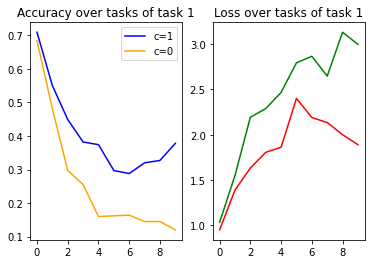

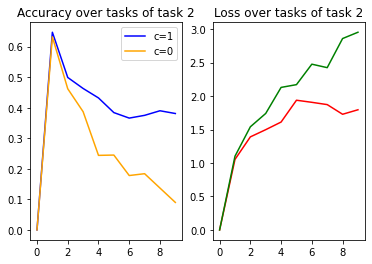

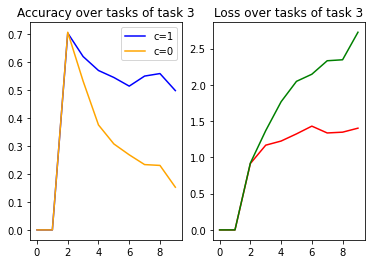

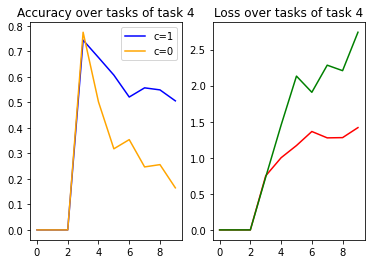

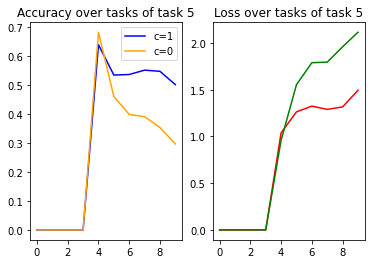

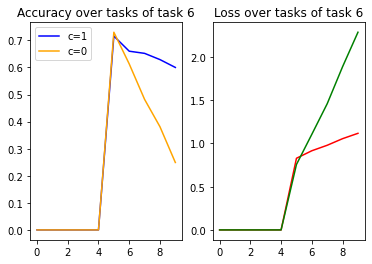

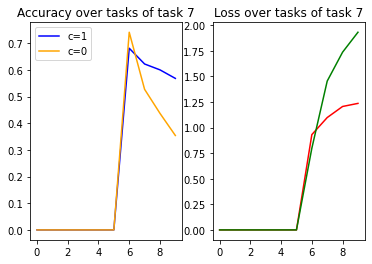

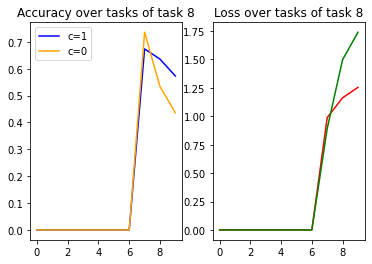

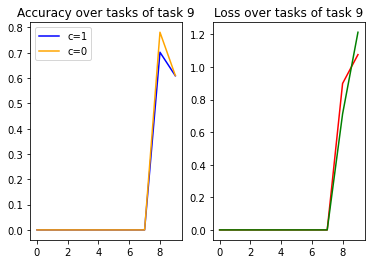

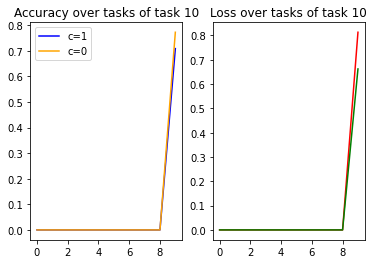

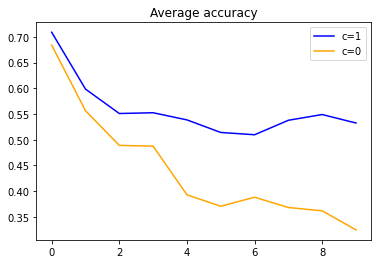

In [113]:
plot_res(
    task_cla_cf100,
    cf100_acc_w_c,
    cf100_acc_wo_c,
    cf100_loss_w_c,
    cf100_loss_wo_c
)

#Fix

In [ ]:
model = MLP(
    input_size= input_size,
    task_cla= task_cla
).to(device)

In [80]:
x_train = data_cf100[0]['train']['x'].to(device)
y_train = data_cf100[0]['train']['y'].to(device)
x_val = data_cf100[0]['valid']['x'].to(device)
y_val = data_cf100[0]['valid']['y'].to(device)

conv_net = ConvNet(
    input_size_cf100,
    task_cla_cf100
)

conv_net.train()

r=np.arange(x_train.size(0))
np.random.shuffle(r)
r=torch.LongTensor(r).to(device)

for i in range(0, len(r), 256):
    b = r[i: i + 256]
    
    x_b = x_train[b]
    y_b = y_train[b]

    print(y_b)

    out = conv_net.forward(x_b)[0]
    print(type(out))

    print(out)
    loss = nn.CrossEntropyLoss()
    print(loss(out, y_b))
    break

tensor([4, 6, 3, 2, 1, 8, 4, 5, 8, 3, 4, 9, 6, 5, 8, 4, 3, 3, 0, 9, 0, 4, 0, 3,
        8, 7, 7, 3, 2, 2, 9, 8, 7, 2, 1, 3, 2, 0, 1, 3, 0, 3, 2, 4, 8, 6, 8, 4,
        3, 1, 5, 2, 3, 2, 8, 3, 0, 0, 4, 9, 8, 2, 0, 4, 2, 7, 9, 1, 2, 5, 1, 2,
        9, 6, 2, 9, 7, 9, 6, 3, 8, 0, 8, 5, 4, 6, 8, 8, 4, 2, 1, 9, 4, 1, 3, 4,
        2, 6, 9, 9, 4, 9, 7, 7, 6, 6, 4, 6, 4, 7, 5, 8, 4, 2, 8, 4, 2, 2, 2, 1,
        8, 0, 0, 7, 4, 8, 3, 2, 7, 0, 7, 9, 7, 1, 0, 0, 0, 8, 3, 8, 0, 0, 5, 3,
        8, 3, 3, 1, 6, 4, 0, 2, 2, 8, 3, 6, 8, 2, 4, 1, 7, 9, 1, 0, 8, 1, 3, 7,
        4, 8, 4, 3, 9, 3, 3, 7, 6, 7, 1, 2, 4, 1, 1, 3, 5, 6, 0, 5, 0, 3, 2, 3,
        0, 3, 0, 0, 9, 5, 7, 5, 9, 1, 2, 2, 7, 6, 3, 4, 7, 2, 3, 0, 3, 1, 2, 0,
        0, 9, 1, 8, 7, 9, 8, 8, 9, 2, 8, 0, 4, 3, 4, 0, 4, 4, 9, 4, 9, 5, 4, 8,
        9, 4, 2, 8, 6, 6, 2, 0, 0, 0, 8, 9, 6, 7, 8, 1])
<class 'torch.Tensor'>
tensor([[ 0.0523, -0.0681, -0.0066,  ...,  0.0521,  0.0170,  0.0434],
        [ 0.0583, -0.0539, -0.0111,  ...,  0.0405,